In [3]:
!nvidia-smi

Sun Jul 10 15:37:21 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.68.02    Driver Version: 510.68.02    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| 30%   31C    P8    22W / 320W |    652MiB / 10240MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
from glob import glob
from sklearn.model_selection import GroupKFold, StratifiedKFold
import cv2
from skimage import io
import torch
from torch import nn
import os
# from datetime import datetime
import time, datetime
import random
import cv2
import torchvision
from torchvision import transforms
import pandas as pd
import numpy as np
from tqdm import tqdm
import shutil

import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from torch.cuda.amp import autocast, GradScaler
from torch.nn.modules.loss import _WeightedLoss
import torch.nn.functional as F
import timm

import sklearn
import warnings
import joblib
from sklearn.metrics import roc_auc_score, log_loss
from sklearn import metrics
import warnings
import cv2
import pydicom
#from efficientnet_pytorch import EfficientNet
from scipy.ndimage import zoom
from PIL import Image
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

#vit
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform
import wandb

In [2]:
wandb.login()

wandb: Currently logged in as: kyungbin (endoai-colonoscopy). Use `wandb login --relogin` to force relogin


True

In [3]:
timm.list_models(pretrained=False)

['adv_inception_v3',
 'bat_resnext26ts',
 'beit_base_patch16_224',
 'beit_base_patch16_224_in22k',
 'beit_base_patch16_384',
 'beit_large_patch16_224',
 'beit_large_patch16_224_in22k',
 'beit_large_patch16_384',
 'beit_large_patch16_512',
 'botnet26t_256',
 'botnet50ts_256',
 'cait_m36_384',
 'cait_m48_448',
 'cait_s24_224',
 'cait_s24_384',
 'cait_s36_384',
 'cait_xs24_384',
 'cait_xxs24_224',
 'cait_xxs24_384',
 'cait_xxs36_224',
 'cait_xxs36_384',
 'coat_lite_mini',
 'coat_lite_small',
 'coat_lite_tiny',
 'coat_mini',
 'coat_tiny',
 'convit_base',
 'convit_small',
 'convit_tiny',
 'convmixer_768_32',
 'convmixer_1024_20_ks9_p14',
 'convmixer_1536_20',
 'convnext_base',
 'convnext_base_384_in22ft1k',
 'convnext_base_in22ft1k',
 'convnext_base_in22k',
 'convnext_large',
 'convnext_large_384_in22ft1k',
 'convnext_large_in22ft1k',
 'convnext_large_in22k',
 'convnext_small',
 'convnext_tiny',
 'convnext_tiny_hnf',
 'convnext_xlarge_384_in22ft1k',
 'convnext_xlarge_in22ft1k',
 'convnext_x

In [4]:
model =timm.create_model('efficientnet_lite0', pretrained=True, num_classes=2)

config = resolve_data_config({}, model=model)
transform = create_transform(**config)

model

EfficientNet(
  (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU6(inplace=True)
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): ReLU6(inplace=True)
        (se): Identity()
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act2): Identity()
      )
    )
    (1): Sequential(
      (0): InvertedResidual(
        (conv_pw): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_

In [5]:
trn_dir = glob('D:/@image_data/nbi_wl(pacs+testvideo)/*.png')
trn_df = pd.DataFrame(trn_dir, columns=['image_id'])
trn_df['image_id'] = trn_df['image_id'].apply(lambda x: os.path.basename(x))
trn_df['label'] = trn_df['image_id'].apply(lambda x: 1 if 'N' in x else 0)
trn_df
train=trn_df

In [6]:
train=train.sample(frac=1, replace=False, random_state=0).reset_index(drop=True)
train

image_id  label
0      V1029_p1_0001_W.png      0
1          P01036_05_N.png      1
2       HP_S04394_03_N.png      1
3          S01161_02_W.png      0
4          S00742_06_N.png      1
...                    ...    ...
37959      S00908_02_N.png      1
37960  V0604_p6_0077_N.png      1
37961  V0529_p1_0010_N.png      1
37962      S01089_03_N.png      1
37963   AD_S05320_01_W.png      0

[37964 rows x 2 columns]

In [7]:
train.label.value_counts()

1    21548
0    16416
Name: label, dtype: int64

In [8]:
CFG = {
    'fold_num': 5,
    'seed': 0,
    'model_arch': 'efficientnet_lite0',
    'img_size': 384,
    'epochs': 100,
    'train_bs': 10,
    'valid_bs': 10,
    'T_0': 10,
    'lr': 1e-4,
    'min_lr': 1e-6,
    'weight_decay':1e-5,
    'num_workers': 0,
    'accum_iter': 2, # suppoprt to do batch accumulation for backprop with effectively larger batch size
    'verbose_step': 1,
    'device': 'cuda:0'
}

In [9]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [10]:
def get_img(path):
    im_bgr = cv2.imread(path)
    im_rgb = im_bgr[:, :, ::-1]
    #print(im_rgb)
    return im_rgb

In [11]:
def rand_bbox(size, lam):
    W = size[0]
    H = size[1]
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)
    return bbx1, bby1, bbx2, bby2


class ColonDataset(Dataset):
    def __init__(self, df, data_root, 
                 transforms=None, 
                 output_label=True, 
                 one_hot_label=False,
                 do_fmix=False, 
                 fmix_params={
                     'alpha': 1., 
                     'decay_power': 3., 
                     'shape': (CFG['img_size'], CFG['img_size']),
                     'max_soft': True, 
                     'reformulate': False
                 },
                 do_cutmix=False,
                 cutmix_params={
                     'alpha': 1,
                 }
                ):
        
        super().__init__()
        self.df = df.reset_index(drop=True).copy()
        self.transforms = transforms
        self.data_root = data_root
        self.do_fmix = do_fmix
        self.fmix_params = fmix_params
        self.do_cutmix = do_cutmix
        self.cutmix_params = cutmix_params
        
        self.output_label = output_label
        self.one_hot_label = one_hot_label
        
        if output_label == True:
            self.labels = self.df['label'].values
            #print(self.labels)
            
            if one_hot_label is True:
                self.labels = np.eye(self.df['label'].max()+1)[self.labels]
                #print(self.labels)
            
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, index: int):
        
        # get labels
        if self.output_label:
            target = self.labels[index]
          
        img  = get_img("{}/{}".format(self.data_root, self.df.loc[index]['image_id']))

        if self.transforms:
            img = self.transforms(image=img)['image']
        
        if self.do_fmix and np.random.uniform(0., 1., size=1)[0] > 0.5:
            with torch.no_grad():
                #lam, mask = sample_mask(**self.fmix_params)
                
                lam = np.clip(np.random.beta(self.fmix_params['alpha'], self.fmix_params['alpha']),0.6,0.7)
                
                # Make mask, get mean / std
                mask = make_low_freq_image(self.fmix_params['decay_power'], self.fmix_params['shape'])
                mask = binarise_mask(mask, lam, self.fmix_params['shape'], self.fmix_params['max_soft'])
    
                fmix_ix = np.random.choice(self.df.index, size=1)[0]
                fmix_img  = get_img("{}/{}".format(self.data_root, self.df.iloc[fmix_ix]['image_id']))

                if self.transforms:
                    fmix_img = self.transforms(image=fmix_img)['image']

                mask_torch = torch.from_numpy(mask)
                
                # mix image
                img = mask_torch*img+(1.-mask_torch)*fmix_img

                #print(mask.shape)

                #assert self.output_label==True and self.one_hot_label==True

                # mix target
                rate = mask.sum()/CFG['img_size']/CFG['img_size']
                target = rate*target + (1.-rate)*self.labels[fmix_ix]
                #print(target, mask, img)
                #assert False
        
        if self.do_cutmix and np.random.uniform(0., 1., size=1)[0] > 0.5:
            #print(img.sum(), img.shape)
            with torch.no_grad():
                cmix_ix = np.random.choice(self.df.index, size=1)[0]
                cmix_img  = get_img("{}/{}".format(self.data_root, self.df.iloc[cmix_ix]['image_id']))
                if self.transforms:
                    cmix_img = self.transforms(image=cmix_img)['image']
                    
                lam = np.clip(np.random.beta(self.cutmix_params['alpha'], self.cutmix_params['alpha']),0.3,0.4)
                bbx1, bby1, bbx2, bby2 = rand_bbox((CFG['img_size'], CFG['img_size']), lam)

                img[:, bbx1:bbx2, bby1:bby2] = cmix_img[:, bbx1:bbx2, bby1:bby2]

                rate = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (CFG['img_size'] * CFG['img_size']))
                target = rate*target + (1.-rate)*self.labels[cmix_ix]
                
            #print('-', img.sum())
            #print(target)
            #assert False
                            
        # do label smoothing
        #print(type(img), type(target))
        if self.output_label == True:
            return img, target
        else:
            return img

In [12]:
from albumentations import (
    HorizontalFlip, VerticalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine, RandomResizedCrop,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose, Normalize, Cutout, CoarseDropout, ShiftScaleRotate, CenterCrop, Resize, SmallestMaxSize
)

from albumentations.pytorch import ToTensorV2

def get_train_transforms():
    return Compose([
            #SmallestMaxSize(CFG['img_size']),
            RandomResizedCrop(CFG['img_size'], CFG['img_size'], p=0.5),
            #Resize(CFG['img_size'], CFG['img_size']),   # (h, w)
            Transpose(p=0.5),
            HorizontalFlip(p=0.5),
            VerticalFlip(p=0.5),
            ShiftScaleRotate(p=0.5),
            #HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
            RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
            CoarseDropout(p=0.5),
            #Cutout(p=0.5),
            ToTensorV2(p=1.0),
        ], p=1.)
  
        
def get_valid_transforms():
    return Compose([
            #Resize(CFG['img_size'], CFG['img_size']),
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.)

In [13]:
class ColonImgClassifier(nn.Module):
    def __init__(self, model_arch, n_class=2, pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_arch, pretrained=pretrained, num_classes=n_class)
        try :
            n_features = self.model.classifier.in_features
            self.model.classifier = nn.Linear(n_features, n_class)

        except :
            
            try : 
                n_features = self.model.fc.in_features
                self.model.fc = nn.Linear(n_features, n_class)
            
            except :
                try:
                    n_features = self.model.head.fc.in_channels
                    self.model.head.fc = nn.Conv2d(n_features,n_class,kernel_size=(1, 1), stride=(1, 1))
            
                except:
                    n_features = self.model.head.in_features
                    self.model.head = nn.Linear(n_features, n_class)
            
    def forward(self, x):
        x = self.model(x)
        return x

In [14]:
def prepare_dataloader(df, trn_idx, val_idx, data_root):
    
    from catalyst.data.sampler import BalanceClassSampler
    
    train_ = df.loc[trn_idx,:].reset_index(drop=True)
    valid_ = df.loc[val_idx,:].reset_index(drop=True)
        
    train_ds = ColonDataset(train_, data_root, transforms=get_train_transforms(), output_label=True, one_hot_label=False, do_fmix=False, do_cutmix=False)
    valid_ds = ColonDataset(valid_, data_root, transforms=get_valid_transforms(), output_label=True)
    
    train_loader = torch.utils.data.DataLoader(
        train_ds,
        batch_size=CFG['train_bs'],
        pin_memory=False,
        drop_last=False,
        shuffle=False,        
        num_workers=CFG['num_workers'],
        sampler=BalanceClassSampler(labels=train_['label'].values, mode="upsampling")
    )
    val_loader = torch.utils.data.DataLoader(
        valid_ds, 
        batch_size=CFG['valid_bs'],
        num_workers=CFG['num_workers'],
        shuffle=False,
        pin_memory=False,
    )
    return train_loader, val_loader

In [15]:
def train_one_epoch(epoch, model, loss_fn, optimizer, train_loader, device, scheduler=None, schd_batch_update=False):
    model.train()

    t = time.time()
    running_loss = None
    image_preds_all = []
    image_targets_all = []
    acc_list = []
    
    pbar = tqdm(enumerate(train_loader), total=len(train_loader))
    for step, (imgs, image_labels) in pbar:
        imgs = imgs.to(device).float()
        image_labels = image_labels.to(device).long()

        #print(image_labels.shape, exam_label.shape)
        with autocast():
            image_preds = model(imgs)   #output = model(input)
            #print(image_preds.shape, exam_pred.shape)

            loss = loss_fn(image_preds, image_labels)
            
            scaler.scale(loss).backward()

            if running_loss is None:
                running_loss = loss.item()
            else:
                running_loss = running_loss * .99 + loss.item() * .01

            if ((step + 1) %  CFG['accum_iter'] == 0) or ((step + 1) == len(train_loader)):
                # may unscale_ here if desired (e.g., to allow clipping unscaled gradients)

                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad() 
                
                if scheduler is not None and schd_batch_update:
                    scheduler.step()

            if ((step + 1) % CFG['verbose_step'] == 0) or ((step + 1) == len(train_loader)):
                description = f'epoch {epoch} loss: {running_loss:.4f}'
                
                pbar.set_description(description)
            
        image_preds_all += [torch.argmax(image_preds, 1).detach().cpu().numpy()]
        image_targets_all += [image_labels.detach().cpu().numpy()]
    
    image_preds_all = np.concatenate(image_preds_all)
    image_targets_all = np.concatenate(image_targets_all)
    matrix = confusion_matrix(image_targets_all,image_preds_all)
    accuracy = (image_preds_all==image_targets_all).mean()
    
    print('train 2class accuracy = {:.5f}'.format(accuracy))
    print(matrix)
    
    if scheduler is not None and not schd_batch_update:
        scheduler.step()
    
    return image_preds_all, accuracy, matrix, running_loss

def valid_one_epoch(epoch, model, loss_fn, val_loader, device, scheduler=None, schd_loss_update=False):
    model.eval()

    t = time.time()
    loss_sum = 0
    sample_num = 0
    image_preds_all = []
    image_targets_all = []
    
    acc_list = []
    
    pbar = tqdm(enumerate(val_loader), total=len(val_loader))
    for step, (imgs, image_labels) in pbar:
        imgs = imgs.to(device).float()
        image_labels = image_labels.to(device).long()
        
        image_preds = model(imgs)   #output = model(input)
        #print(image_preds.shape, exam_pred.shape)
        image_preds_all += [torch.argmax(image_preds, 1).detach().cpu().numpy()]
        image_targets_all += [image_labels.detach().cpu().numpy()]
        
        loss = loss_fn(image_preds, image_labels)
        
        loss_sum += loss.item()*image_labels.shape[0]
        sample_num += image_labels.shape[0]  

        if ((step + 1) % CFG['verbose_step'] == 0) or ((step + 1) == len(val_loader)):
            description = f'epoch {epoch} loss: {loss_sum/sample_num:.4f}'
            pbar.set_description(description)
            
    result_loss=loss_sum/sample_num
    
    image_preds_all = np.concatenate(image_preds_all)
    image_targets_all = np.concatenate(image_targets_all)
    matrix = confusion_matrix(image_targets_all,image_preds_all)
    acc = (image_preds_all==image_targets_all).mean()
    
    print('validation 2class accuracy = {:.5f}'.format(acc))
    print(matrix)
    
    if scheduler is not None:
        if schd_loss_update:
            scheduler.step(loss_sum/sample_num)
        else:
            scheduler.step()
            
    return image_preds_all, acc, matrix ,result_loss

In [16]:
# reference: https://www.kaggle.com/c/siim-isic-melanoma-classification/discussion/173733
class MyCrossEntropyLoss(_WeightedLoss):
    def __init__(self, weight=None, reduction='mean'):
        super().__init__(weight=weight, reduction=reduction)
        self.weight = weight
        self.reduction = reduction

    def forward(self, inputs, targets):
        lsm = F.log_softmax(inputs, -1)

        if self.weight is not None:
            lsm = lsm * self.weight.unsqueeze(0)

        loss = -(targets * lsm).sum(-1)

        if  self.reduction == 'sum':
            loss = loss.sum()
        elif  self.reduction == 'mean':
            loss = loss.mean()

        return loss

In [17]:
os.getcwd()

'C:\\Users\\user\\bini\\nbi\\train'

wandb: Currently logged in as: kyungbin. Use `wandb login --relogin` to force relogin


Training with 0 started
30371 7593


epoch 0 loss: 0.0401: 100%|████████████████████████████████████████████████████████| 3448/3448 [09:28<00:00,  6.07it/s]


train 2class accuracy = 0.97540
[[16866   373]
 [  475 16764]]


epoch 0 loss: 0.0189: 100%|██████████████████████████████████████████████████████████| 760/760 [01:44<00:00,  7.27it/s]

validation 2class accuracy = 0.99776
[[3277    7]
 [  10 4299]]


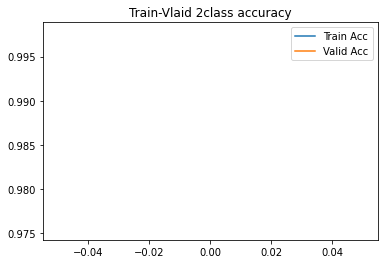

epoch 1 loss: 0.0455: 100%|████████████████████████████████████████████████████████| 3448/3448 [06:52<00:00,  8.36it/s]


train 2class accuracy = 0.99246
[[17109   130]
 [  130 17109]]


epoch 1 loss: 0.0220: 100%|██████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.46it/s]


validation 2class accuracy = 0.99631
[[3280    4]
 [  24 4285]]


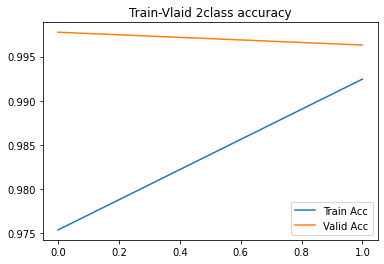

epoch 2 loss: 0.0401: 100%|████████████████████████████████████████████████████████| 3448/3448 [06:42<00:00,  8.56it/s]


train 2class accuracy = 0.99411
[[17146    93]
 [  110 17129]]


epoch 2 loss: 0.0120: 100%|██████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.37it/s]


validation 2class accuracy = 0.99842
[[3281    3]
 [   9 4300]]


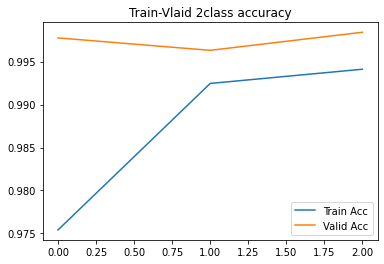

epoch 3 loss: 0.0138: 100%|████████████████████████████████████████████████████████| 3448/3448 [06:42<00:00,  8.57it/s]


train 2class accuracy = 0.99495
[[17155    84]
 [   90 17149]]


epoch 3 loss: 0.0163: 100%|██████████████████████████████████████████████████████████| 760/760 [00:57<00:00, 13.28it/s]

validation 2class accuracy = 0.99802
[[3279    5]
 [  10 4299]]


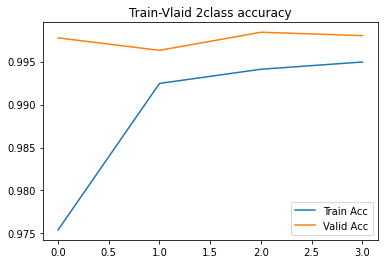

epoch 4 loss: 0.0175: 100%|████████████████████████████████████████████████████████| 3448/3448 [06:47<00:00,  8.45it/s]


train 2class accuracy = 0.99423
[[17138   101]
 [   98 17141]]


epoch 4 loss: 0.0142: 100%|██████████████████████████████████████████████████████████| 760/760 [00:57<00:00, 13.31it/s]


validation 2class accuracy = 0.99829
[[3280    4]
 [   9 4300]]


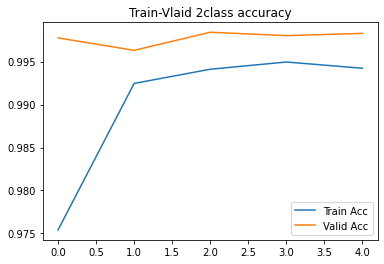

epoch 5 loss: 0.0187: 100%|████████████████████████████████████████████████████████| 3448/3448 [06:45<00:00,  8.50it/s]


train 2class accuracy = 0.99620
[[17185    54]
 [   77 17162]]


epoch 5 loss: 0.0126: 100%|██████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.42it/s]


validation 2class accuracy = 0.99855
[[3281    3]
 [   8 4301]]


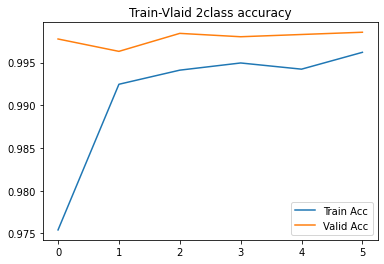

epoch 6 loss: 0.0177: 100%|████████████████████████████████████████████████████████| 3448/3448 [06:48<00:00,  8.45it/s]


train 2class accuracy = 0.99606
[[17175    64]
 [   72 17167]]


epoch 6 loss: 0.0148: 100%|██████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 12.90it/s]


validation 2class accuracy = 0.99842
[[3281    3]
 [   9 4300]]


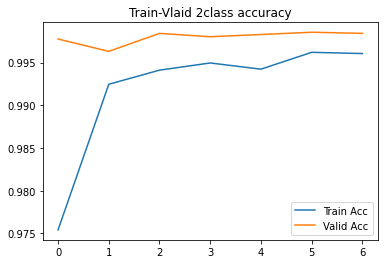

epoch 7 loss: 0.0101: 100%|████████████████████████████████████████████████████████| 3448/3448 [06:50<00:00,  8.39it/s]


train 2class accuracy = 0.99652
[[17182    57]
 [   63 17176]]


epoch 7 loss: 0.0135: 100%|██████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 12.94it/s]

validation 2class accuracy = 0.99842
[[3280    4]
 [   8 4301]]


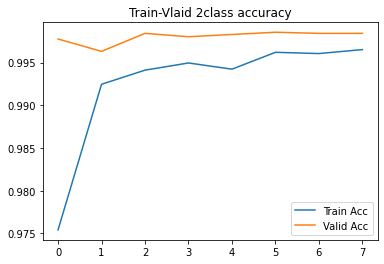

epoch 8 loss: 0.0037: 100%|████████████████████████████████████████████████████████| 3448/3448 [06:53<00:00,  8.33it/s]


train 2class accuracy = 0.99713
[[17195    44]
 [   55 17184]]


epoch 8 loss: 0.0138: 100%|██████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 12.97it/s]


validation 2class accuracy = 0.99855
[[3281    3]
 [   8 4301]]


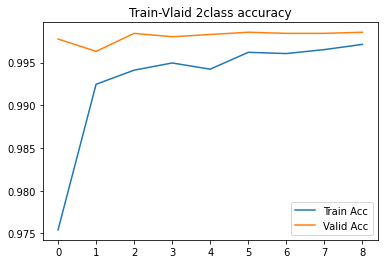

epoch 9 loss: 0.0061: 100%|████████████████████████████████████████████████████████| 3448/3448 [06:52<00:00,  8.36it/s]


train 2class accuracy = 0.99661
[[17195    44]
 [   73 17166]]


epoch 9 loss: 0.0139: 100%|██████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 13.00it/s]


validation 2class accuracy = 0.99855
[[3281    3]
 [   8 4301]]


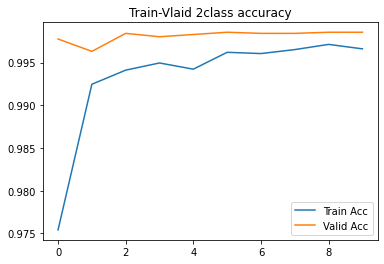

epoch 10 loss: 0.0057: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:49<00:00,  8.42it/s]


train 2class accuracy = 0.99632
[[17181    58]
 [   69 17170]]


epoch 10 loss: 0.0127: 100%|█████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 13.01it/s]

validation 2class accuracy = 0.99855
[[3281    3]
 [   8 4301]]


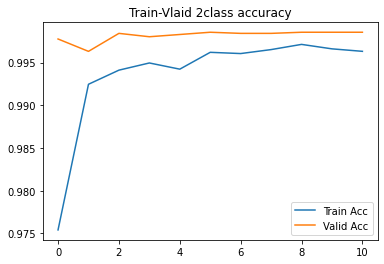

epoch 11 loss: 0.0162: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:45<00:00,  8.51it/s]


train 2class accuracy = 0.99661
[[17186    53]
 [   64 17175]]


epoch 11 loss: 0.0133: 100%|█████████████████████████████████████████████████████████| 760/760 [00:57<00:00, 13.16it/s]

validation 2class accuracy = 0.99842
[[3280    4]
 [   8 4301]]


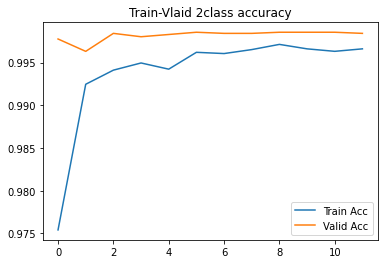

epoch 12 loss: 0.0111: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:48<00:00,  8.45it/s]


train 2class accuracy = 0.99713
[[17198    41]
 [   58 17181]]


epoch 12 loss: 0.0148: 100%|█████████████████████████████████████████████████████████| 760/760 [00:57<00:00, 13.15it/s]


validation 2class accuracy = 0.99829
[[3279    5]
 [   8 4301]]


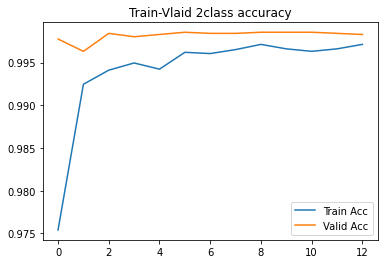

epoch 13 loss: 0.0148: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:47<00:00,  8.46it/s]


train 2class accuracy = 0.99736
[[17197    42]
 [   49 17190]]


epoch 13 loss: 0.0135: 100%|█████████████████████████████████████████████████████████| 760/760 [00:57<00:00, 13.14it/s]


validation 2class accuracy = 0.99829
[[3280    4]
 [   9 4300]]


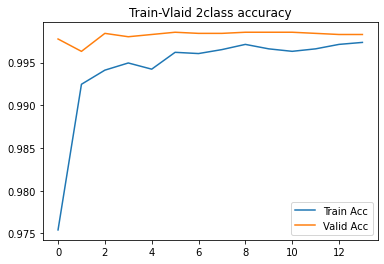

epoch 14 loss: 0.0107: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:49<00:00,  8.41it/s]


train 2class accuracy = 0.99716
[[17195    44]
 [   54 17185]]


epoch 14 loss: 0.0134: 100%|█████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 13.01it/s]


validation 2class accuracy = 0.99842
[[3281    3]
 [   9 4300]]


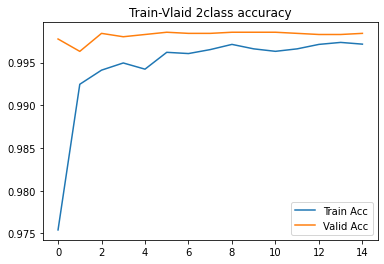

epoch 15 loss: 0.0160: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:50<00:00,  8.39it/s]


train 2class accuracy = 0.99678
[[17197    42]
 [   69 17170]]


epoch 15 loss: 0.0131: 100%|█████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 13.04it/s]

validation 2class accuracy = 0.99816
[[3280    4]
 [  10 4299]]


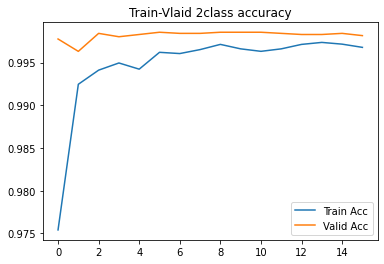

epoch 16 loss: 0.0095: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:50<00:00,  8.40it/s]


train 2class accuracy = 0.99745
[[17201    38]
 [   50 17189]]


epoch 16 loss: 0.0148: 100%|█████████████████████████████████████████████████████████| 760/760 [00:57<00:00, 13.13it/s]

validation 2class accuracy = 0.99842
[[3280    4]
 [   8 4301]]


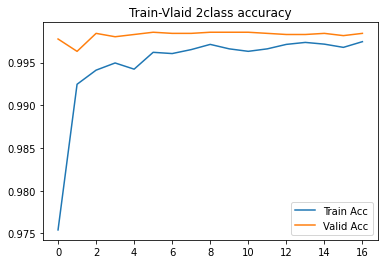

epoch 17 loss: 0.0092: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:42<00:00,  8.56it/s]


train 2class accuracy = 0.99748
[[17200    39]
 [   48 17191]]


epoch 17 loss: 0.0168: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.34it/s]


validation 2class accuracy = 0.99829
[[3280    4]
 [   9 4300]]


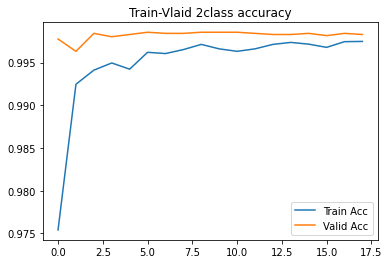

epoch 18 loss: 0.0112: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:43<00:00,  8.55it/s]


train 2class accuracy = 0.99733
[[17198    41]
 [   51 17188]]


epoch 18 loss: 0.0187: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.36it/s]


validation 2class accuracy = 0.99842
[[3281    3]
 [   9 4300]]


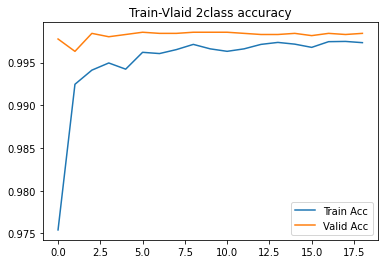

epoch 19 loss: 0.0146: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:43<00:00,  8.55it/s]


train 2class accuracy = 0.99716
[[17198    41]
 [   57 17182]]


epoch 19 loss: 0.0175: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.38it/s]

validation 2class accuracy = 0.99842
[[3281    3]
 [   9 4300]]


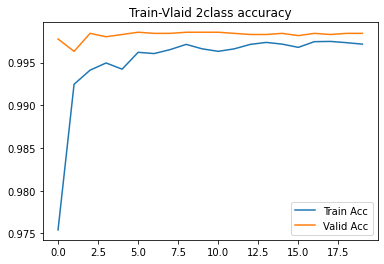

epoch 20 loss: 0.0106: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:43<00:00,  8.55it/s]


train 2class accuracy = 0.99771
[[17202    37]
 [   42 17197]]


epoch 20 loss: 0.0167: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.37it/s]

validation 2class accuracy = 0.99802
[[3281    3]
 [  12 4297]]


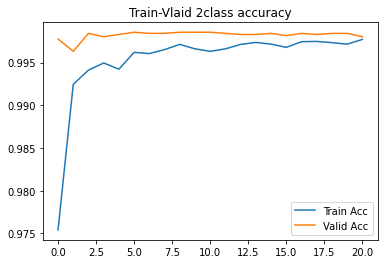

epoch 21 loss: 0.0169: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:45<00:00,  8.51it/s]


train 2class accuracy = 0.99739
[[17202    37]
 [   53 17186]]


epoch 21 loss: 0.0162: 100%|█████████████████████████████████████████████████████████| 760/760 [00:57<00:00, 13.18it/s]

validation 2class accuracy = 0.99789
[[3280    4]
 [  12 4297]]


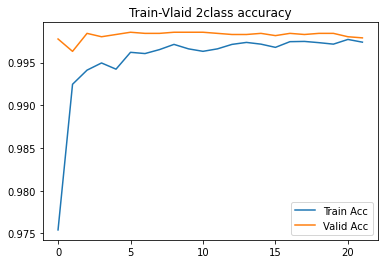

epoch 22 loss: 0.0108: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:49<00:00,  8.42it/s]


train 2class accuracy = 0.99777
[[17209    30]
 [   47 17192]]


epoch 22 loss: 0.0186: 100%|█████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 13.03it/s]


validation 2class accuracy = 0.99802
[[3281    3]
 [  12 4297]]


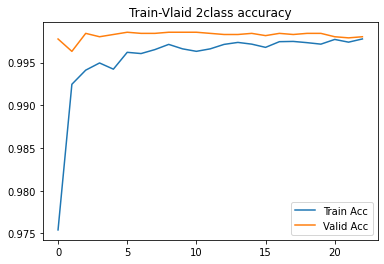

epoch 23 loss: 0.0043: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:49<00:00,  8.41it/s]


train 2class accuracy = 0.99727
[[17197    42]
 [   52 17187]]


epoch 23 loss: 0.0161: 100%|█████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 13.01it/s]

validation 2class accuracy = 0.99842
[[3281    3]
 [   9 4300]]


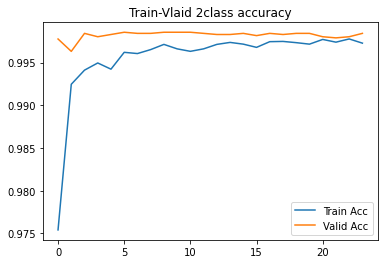

epoch 24 loss: 0.0091: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:50<00:00,  8.40it/s]


train 2class accuracy = 0.99774
[[17205    34]
 [   44 17195]]


epoch 24 loss: 0.0189: 100%|█████████████████████████████████████████████████████████| 760/760 [00:57<00:00, 13.21it/s]


validation 2class accuracy = 0.99829
[[3281    3]
 [  10 4299]]


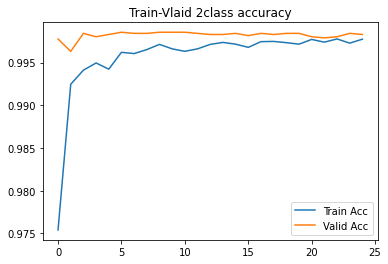

epoch 25 loss: 0.0071: 100%|███████████████████████████████████████████████████████| 3448/3448 [07:07<00:00,  8.06it/s]


train 2class accuracy = 0.99745
[[17202    37]
 [   51 17188]]


epoch 25 loss: 0.0177: 100%|█████████████████████████████████████████████████████████| 760/760 [01:24<00:00,  9.02it/s]


validation 2class accuracy = 0.99829
[[3281    3]
 [  10 4299]]


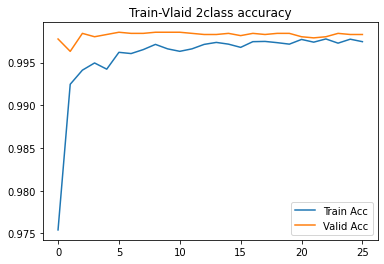

epoch 26 loss: 0.0049: 100%|███████████████████████████████████████████████████████| 3448/3448 [07:36<00:00,  7.55it/s]


train 2class accuracy = 0.99780
[[17214    25]
 [   51 17188]]


epoch 26 loss: 0.0226: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.42it/s]

validation 2class accuracy = 0.99723
[[3280    4]
 [  17 4292]]


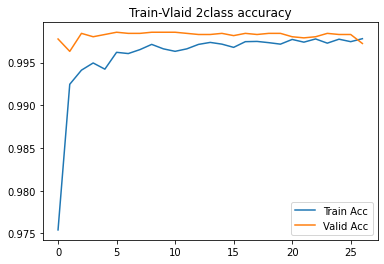

epoch 27 loss: 0.0093: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:46<00:00,  8.48it/s]


train 2class accuracy = 0.99771
[[17205    34]
 [   45 17194]]


epoch 27 loss: 0.0196: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.43it/s]


validation 2class accuracy = 0.99816
[[3281    3]
 [  11 4298]]


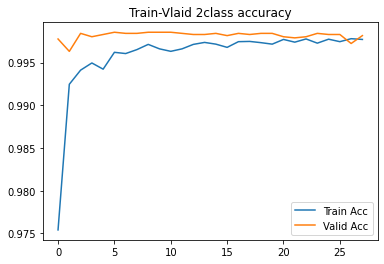

epoch 28 loss: 0.0038: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:43<00:00,  8.54it/s]


train 2class accuracy = 0.99780
[[17210    29]
 [   47 17192]]


epoch 28 loss: 0.0211: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.41it/s]

validation 2class accuracy = 0.99802
[[3281    3]
 [  12 4297]]


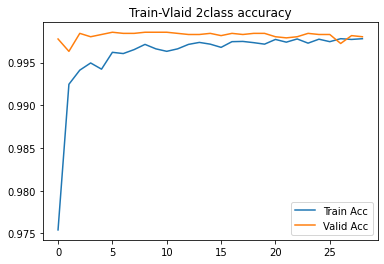

epoch 29 loss: 0.0127: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:42<00:00,  8.57it/s]


train 2class accuracy = 0.99742
[[17201    38]
 [   51 17188]]


epoch 29 loss: 0.0204: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.41it/s]


validation 2class accuracy = 0.99842
[[3280    4]
 [   8 4301]]


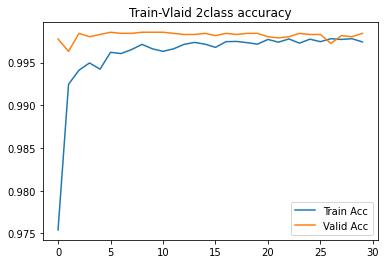

epoch 30 loss: 0.0132: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:42<00:00,  8.57it/s]


train 2class accuracy = 0.99777
[[17208    31]
 [   46 17193]]


epoch 30 loss: 0.0159: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.43it/s]

validation 2class accuracy = 0.99855
[[3281    3]
 [   8 4301]]


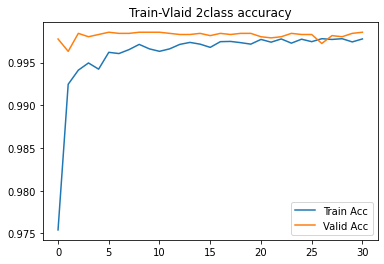

epoch 31 loss: 0.0103: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:42<00:00,  8.57it/s]


train 2class accuracy = 0.99794
[[17211    28]
 [   43 17196]]


epoch 31 loss: 0.0195: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.43it/s]

validation 2class accuracy = 0.99763
[[3281    3]
 [  15 4294]]


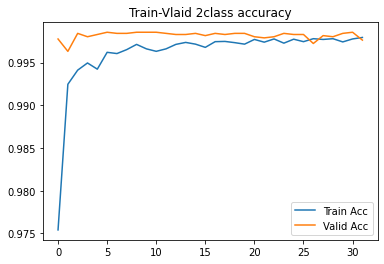

epoch 32 loss: 0.0099: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:42<00:00,  8.57it/s]


train 2class accuracy = 0.99782
[[17209    30]
 [   45 17194]]


epoch 32 loss: 0.0190: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.42it/s]

validation 2class accuracy = 0.99776
[[3281    3]
 [  14 4295]]


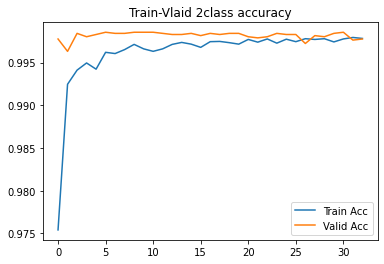

epoch 33 loss: 0.0112: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:42<00:00,  8.57it/s]


train 2class accuracy = 0.99797
[[17214    25]
 [   45 17194]]


epoch 33 loss: 0.0139: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.42it/s]


validation 2class accuracy = 0.99842
[[3281    3]
 [   9 4300]]


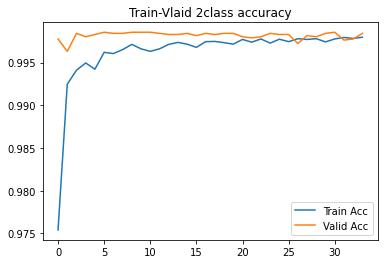

epoch 34 loss: 0.0089: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:42<00:00,  8.57it/s]


train 2class accuracy = 0.99782
[[17208    31]
 [   44 17195]]


epoch 34 loss: 0.0173: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.40it/s]


validation 2class accuracy = 0.99829
[[3281    3]
 [  10 4299]]


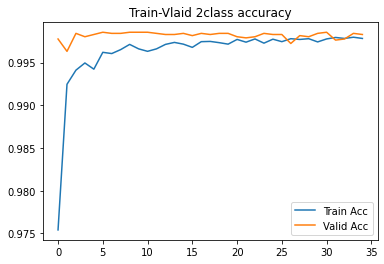

epoch 35 loss: 0.0045: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:41<00:00,  8.58it/s]


train 2class accuracy = 0.99820
[[17219    20]
 [   42 17197]]


epoch 35 loss: 0.0180: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.45it/s]


validation 2class accuracy = 0.99789
[[3281    3]
 [  13 4296]]


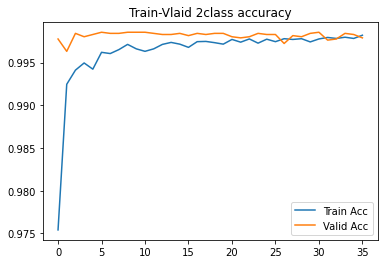

epoch 36 loss: 0.0065: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:41<00:00,  8.59it/s]


train 2class accuracy = 0.99774
[[17210    29]
 [   49 17190]]


epoch 36 loss: 0.0198: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.41it/s]

validation 2class accuracy = 0.99750
[[3278    6]
 [  13 4296]]


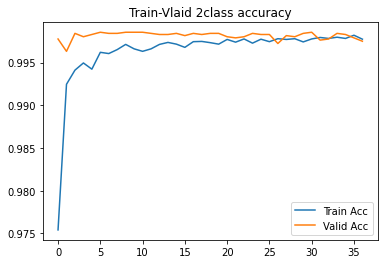

epoch 37 loss: 0.0098: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:41<00:00,  8.59it/s]


train 2class accuracy = 0.99759
[[17208    31]
 [   52 17187]]


epoch 37 loss: 0.0164: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.43it/s]


validation 2class accuracy = 0.99829
[[3281    3]
 [  10 4299]]


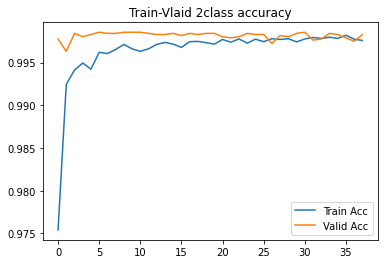

epoch 38 loss: 0.0063: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:41<00:00,  8.58it/s]


train 2class accuracy = 0.99797
[[17216    23]
 [   47 17192]]


epoch 38 loss: 0.0149: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.42it/s]


validation 2class accuracy = 0.99829
[[3279    5]
 [   8 4301]]


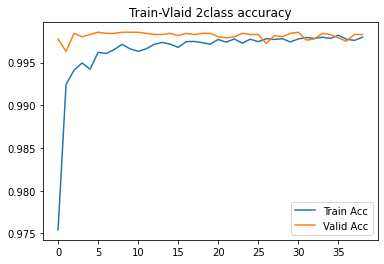

epoch 39 loss: 0.0049: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:41<00:00,  8.59it/s]


train 2class accuracy = 0.99835
[[17220    19]
 [   38 17201]]


epoch 39 loss: 0.0186: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.43it/s]


validation 2class accuracy = 0.99789
[[3276    8]
 [   8 4301]]


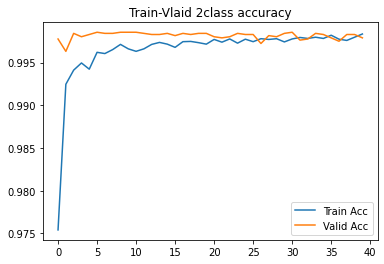

epoch 40 loss: 0.0063: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:44<00:00,  8.52it/s]


train 2class accuracy = 0.99811
[[17215    24]
 [   41 17198]]


epoch 40 loss: 0.0170: 100%|█████████████████████████████████████████████████████████| 760/760 [00:57<00:00, 13.15it/s]


validation 2class accuracy = 0.99816
[[3278    6]
 [   8 4301]]


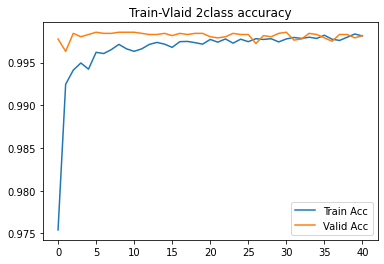

epoch 41 loss: 0.0070: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:41<00:00,  8.58it/s]


train 2class accuracy = 0.99817
[[17211    28]
 [   35 17204]]


epoch 41 loss: 0.0175: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.42it/s]

validation 2class accuracy = 0.99842
[[3281    3]
 [   9 4300]]


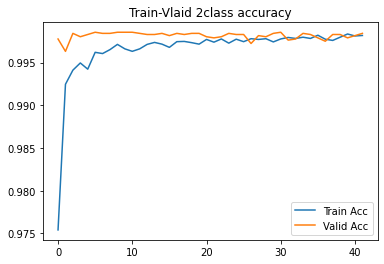

epoch 42 loss: 0.0059: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:41<00:00,  8.59it/s]


train 2class accuracy = 0.99803
[[17212    27]
 [   41 17198]]


epoch 42 loss: 0.0217: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.47it/s]


validation 2class accuracy = 0.99789
[[3278    6]
 [  10 4299]]


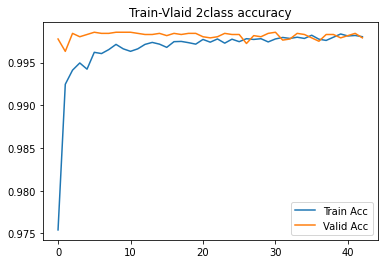

epoch 43 loss: 0.0086: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:40<00:00,  8.60it/s]


train 2class accuracy = 0.99771
[[17209    30]
 [   49 17190]]


epoch 43 loss: 0.0217: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.47it/s]

validation 2class accuracy = 0.99816
[[3279    5]
 [   9 4300]]


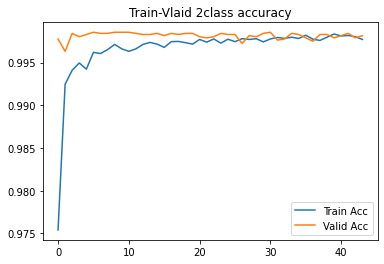

epoch 44 loss: 0.0195: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:41<00:00,  8.59it/s]


train 2class accuracy = 0.99820
[[17216    23]
 [   39 17200]]


epoch 44 loss: 0.0188: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.46it/s]


validation 2class accuracy = 0.99802
[[3279    5]
 [  10 4299]]


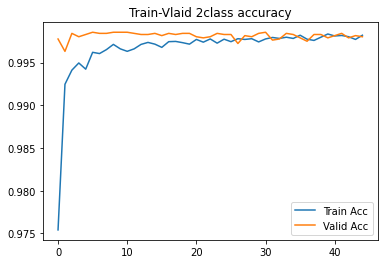

epoch 45 loss: 0.0053: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:41<00:00,  8.58it/s]


train 2class accuracy = 0.99846
[[17219    20]
 [   33 17206]]


epoch 45 loss: 0.0209: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.44it/s]


validation 2class accuracy = 0.99842
[[3281    3]
 [   9 4300]]


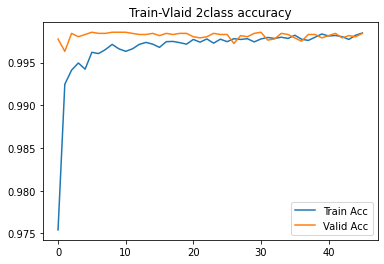

epoch 46 loss: 0.0121: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:42<00:00,  8.58it/s]


train 2class accuracy = 0.99820
[[17218    21]
 [   41 17198]]


epoch 46 loss: 0.0212: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.43it/s]


validation 2class accuracy = 0.99855
[[3281    3]
 [   8 4301]]


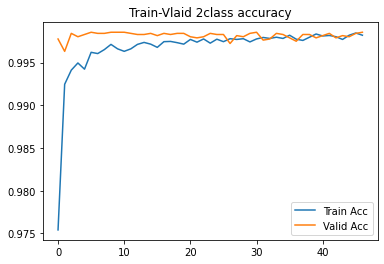

epoch 47 loss: 0.0069: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:41<00:00,  8.58it/s]


train 2class accuracy = 0.99806
[[17214    25]
 [   42 17197]]


epoch 47 loss: 0.0184: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.45it/s]


validation 2class accuracy = 0.99829
[[3281    3]
 [  10 4299]]


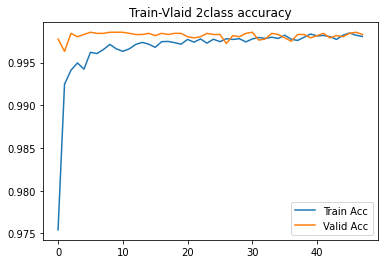

epoch 48 loss: 0.0082: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:41<00:00,  8.58it/s]


train 2class accuracy = 0.99840
[[17217    22]
 [   33 17206]]


epoch 48 loss: 0.0222: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.41it/s]

validation 2class accuracy = 0.99802
[[3280    4]
 [  11 4298]]


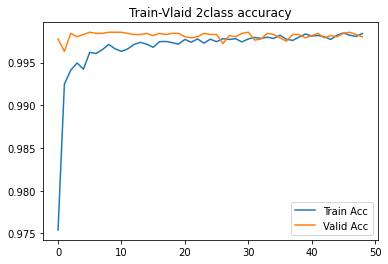

epoch 49 loss: 0.0031: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:41<00:00,  8.59it/s]


train 2class accuracy = 0.99829
[[17217    22]
 [   37 17202]]


epoch 49 loss: 0.0204: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.44it/s]


validation 2class accuracy = 0.99802
[[3280    4]
 [  11 4298]]


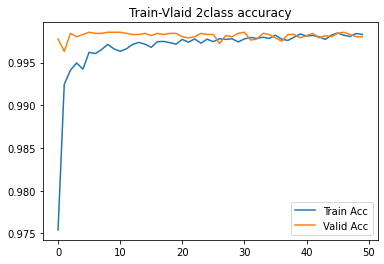

epoch 50 loss: 0.0050: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:42<00:00,  8.57it/s]


train 2class accuracy = 0.99829
[[17216    23]
 [   36 17203]]


epoch 50 loss: 0.0217: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.43it/s]


validation 2class accuracy = 0.99710
[[3280    4]
 [  18 4291]]


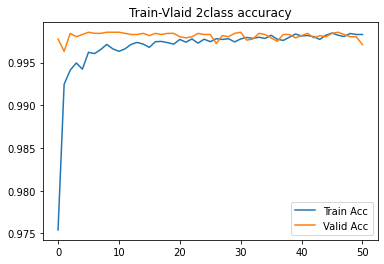

epoch 51 loss: 0.0062: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:41<00:00,  8.58it/s]


train 2class accuracy = 0.99855
[[17221    18]
 [   32 17207]]


epoch 51 loss: 0.0182: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.43it/s]


validation 2class accuracy = 0.99829
[[3281    3]
 [  10 4299]]


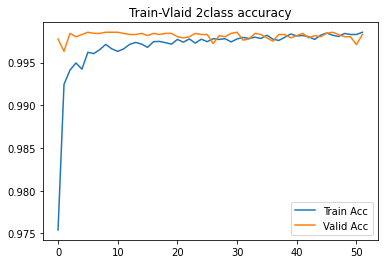

epoch 52 loss: 0.0042: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:42<00:00,  8.56it/s]


train 2class accuracy = 0.99838
[[17216    23]
 [   33 17206]]


epoch 52 loss: 0.0197: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.41it/s]

validation 2class accuracy = 0.99789
[[3281    3]
 [  13 4296]]


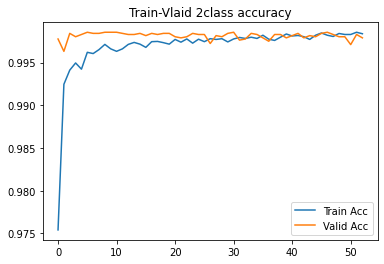

epoch 53 loss: 0.0085: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:42<00:00,  8.56it/s]


train 2class accuracy = 0.99811
[[17209    30]
 [   35 17204]]


epoch 53 loss: 0.0310: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.40it/s]

validation 2class accuracy = 0.99407
[[3278    6]
 [  39 4270]]


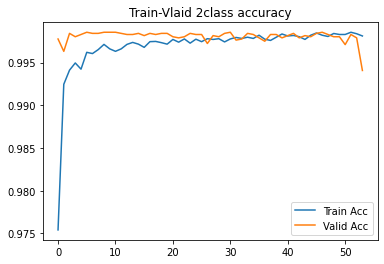

epoch 54 loss: 0.0090: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:43<00:00,  8.55it/s]


train 2class accuracy = 0.99864
[[17224    15]
 [   32 17207]]


epoch 54 loss: 0.0238: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.39it/s]

validation 2class accuracy = 0.99697
[[3279    5]
 [  18 4291]]


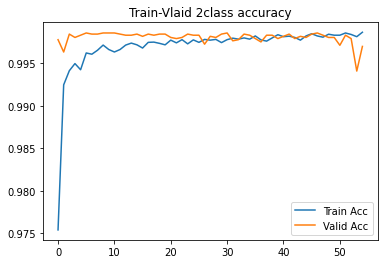

epoch 55 loss: 0.0028: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:43<00:00,  8.55it/s]


train 2class accuracy = 0.99832
[[17218    21]
 [   37 17202]]


epoch 55 loss: 0.0214: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.39it/s]


validation 2class accuracy = 0.99829
[[3281    3]
 [  10 4299]]


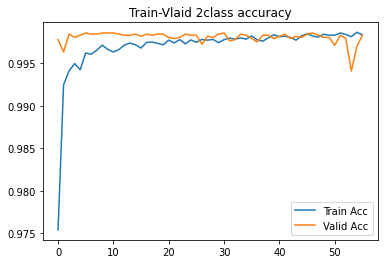

epoch 56 loss: 0.0049: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:43<00:00,  8.54it/s]


train 2class accuracy = 0.99823
[[17212    27]
 [   34 17205]]


epoch 56 loss: 0.0209: 100%|█████████████████████████████████████████████████████████| 760/760 [00:57<00:00, 13.33it/s]


validation 2class accuracy = 0.99789
[[3279    5]
 [  11 4298]]


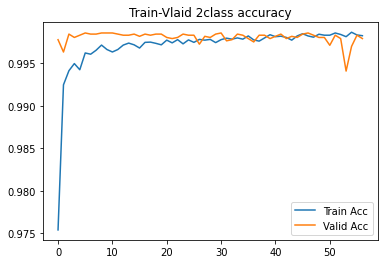

epoch 57 loss: 0.0013: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:48<00:00,  8.45it/s]


train 2class accuracy = 0.99864
[[17223    16]
 [   31 17208]]


epoch 57 loss: 0.0201: 100%|█████████████████████████████████████████████████████████| 760/760 [00:57<00:00, 13.24it/s]


validation 2class accuracy = 0.99855
[[3281    3]
 [   8 4301]]


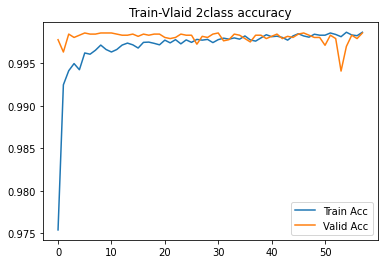

epoch 58 loss: 0.0041: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:48<00:00,  8.44it/s]


train 2class accuracy = 0.99840
[[17215    24]
 [   31 17208]]


epoch 58 loss: 0.0194: 100%|█████████████████████████████████████████████████████████| 760/760 [00:57<00:00, 13.11it/s]


validation 2class accuracy = 0.99829
[[3279    5]
 [   8 4301]]


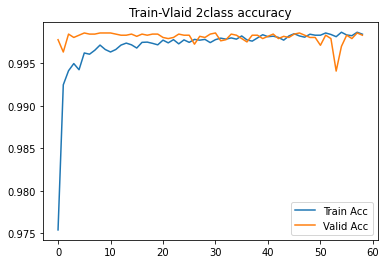

epoch 59 loss: 0.0012: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:48<00:00,  8.43it/s]


train 2class accuracy = 0.99887
[[17228    11]
 [   28 17211]]


epoch 59 loss: 0.0227: 100%|█████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 13.09it/s]


validation 2class accuracy = 0.99763
[[3277    7]
 [  11 4298]]


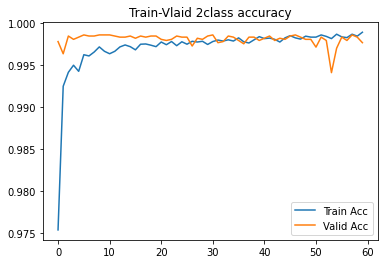

epoch 60 loss: 0.0029: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:48<00:00,  8.43it/s]


train 2class accuracy = 0.99869
[[17220    19]
 [   26 17213]]


epoch 60 loss: 0.0249: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.46it/s]


validation 2class accuracy = 0.99684
[[3269   15]
 [   9 4300]]


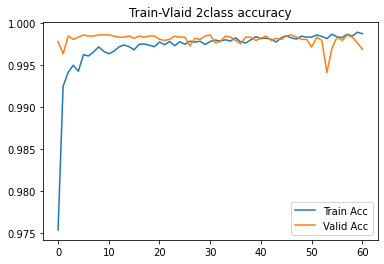

epoch 61 loss: 0.0036: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:41<00:00,  8.58it/s]


train 2class accuracy = 0.99867
[[17222    17]
 [   29 17210]]


epoch 61 loss: 0.0261: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.45it/s]


validation 2class accuracy = 0.99776
[[3277    7]
 [  10 4299]]


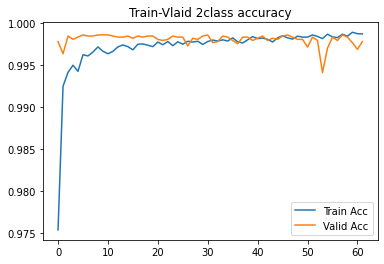

epoch 62 loss: 0.0036: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:41<00:00,  8.59it/s]


train 2class accuracy = 0.99872
[[17222    17]
 [   27 17212]]


epoch 62 loss: 0.0248: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.43it/s]


validation 2class accuracy = 0.99802
[[3280    4]
 [  11 4298]]


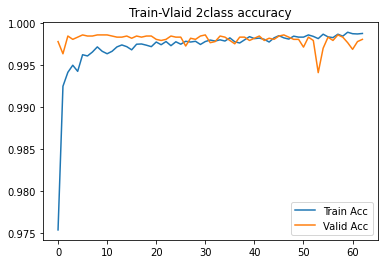

epoch 63 loss: 0.0063: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:41<00:00,  8.58it/s]


train 2class accuracy = 0.99840
[[17214    25]
 [   30 17209]]


epoch 63 loss: 0.0216: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.44it/s]

validation 2class accuracy = 0.99816
[[3281    3]
 [  11 4298]]


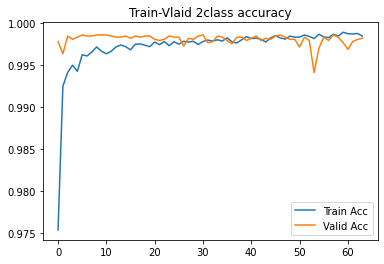

epoch 64 loss: 0.0069: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:41<00:00,  8.58it/s]


train 2class accuracy = 0.99852
[[17217    22]
 [   29 17210]]


epoch 64 loss: 0.0253: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.45it/s]

validation 2class accuracy = 0.99697
[[3271   13]
 [  10 4299]]


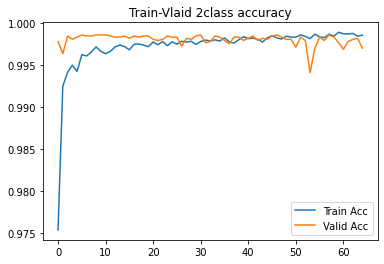

epoch 65 loss: 0.0103: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:41<00:00,  8.58it/s]


train 2class accuracy = 0.99849
[[17219    20]
 [   32 17207]]


epoch 65 loss: 0.0284: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.45it/s]


validation 2class accuracy = 0.99565
[[3266   18]
 [  15 4294]]


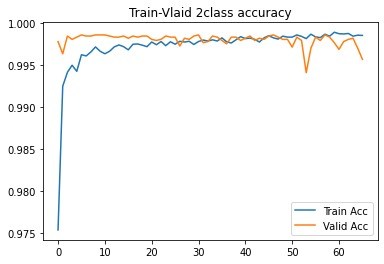

epoch 66 loss: 0.0055: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:42<00:00,  8.57it/s]


train 2class accuracy = 0.99869
[[17227    12]
 [   33 17206]]


epoch 66 loss: 0.0245: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.43it/s]


validation 2class accuracy = 0.99737
[[3279    5]
 [  15 4294]]


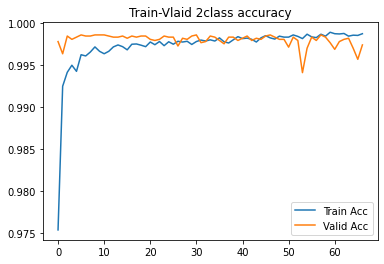

epoch 67 loss: 0.0031: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:42<00:00,  8.57it/s]


train 2class accuracy = 0.99829
[[17218    21]
 [   38 17201]]


epoch 67 loss: 0.0202: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.43it/s]


validation 2class accuracy = 0.99802
[[3278    6]
 [   9 4300]]


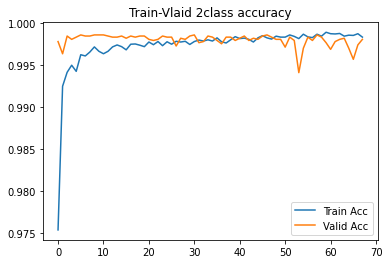

epoch 68 loss: 0.0016: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:42<00:00,  8.56it/s]


train 2class accuracy = 0.99858
[[17219    20]
 [   29 17210]]


epoch 68 loss: 0.0225: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.43it/s]


validation 2class accuracy = 0.99763
[[3280    4]
 [  14 4295]]


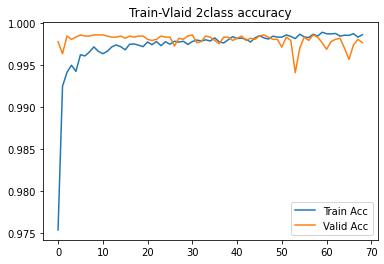

epoch 69 loss: 0.0051: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:42<00:00,  8.57it/s]


train 2class accuracy = 0.99838
[[17216    23]
 [   33 17206]]


epoch 69 loss: 0.0221: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.42it/s]


validation 2class accuracy = 0.99829
[[3281    3]
 [  10 4299]]


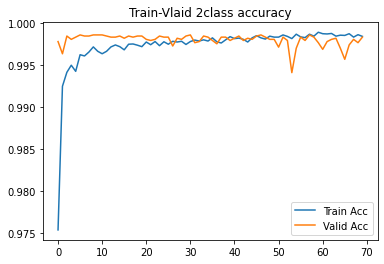

epoch 70 loss: 0.0005: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:42<00:00,  8.57it/s]


train 2class accuracy = 0.99890
[[17222    17]
 [   21 17218]]


epoch 70 loss: 0.0233: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.43it/s]


validation 2class accuracy = 0.99802
[[3281    3]
 [  12 4297]]


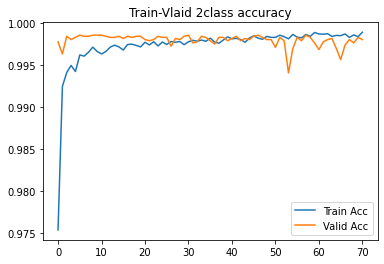

epoch 71 loss: 0.0037: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:42<00:00,  8.58it/s]


train 2class accuracy = 0.99823
[[17212    27]
 [   34 17205]]


epoch 71 loss: 0.0270: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.41it/s]


validation 2class accuracy = 0.99592
[[3273   11]
 [  20 4289]]


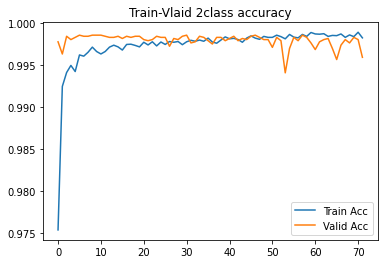

epoch 72 loss: 0.0107: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:44<00:00,  8.52it/s]


train 2class accuracy = 0.99867
[[17220    19]
 [   27 17212]]


epoch 72 loss: 0.0278: 100%|█████████████████████████████████████████████████████████| 760/760 [00:57<00:00, 13.31it/s]


validation 2class accuracy = 0.99513
[[3264   20]
 [  17 4292]]


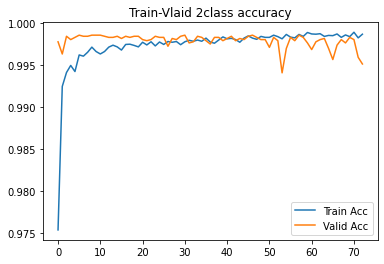

epoch 73 loss: 0.0069: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:46<00:00,  8.48it/s]


train 2class accuracy = 0.99878
[[17220    19]
 [   23 17216]]


epoch 73 loss: 0.0233: 100%|█████████████████████████████████████████████████████████| 760/760 [00:57<00:00, 13.24it/s]


validation 2class accuracy = 0.99697
[[3278    6]
 [  17 4292]]


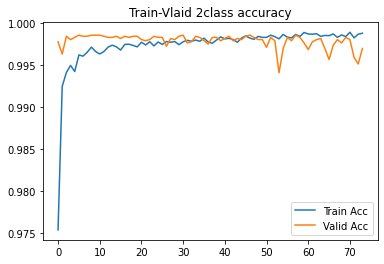

epoch 74 loss: 0.0080: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:47<00:00,  8.47it/s]


train 2class accuracy = 0.99864
[[17221    18]
 [   29 17210]]


epoch 74 loss: 0.0256: 100%|█████████████████████████████████████████████████████████| 760/760 [00:57<00:00, 13.13it/s]

validation 2class accuracy = 0.99671
[[3266   18]
 [   7 4302]]


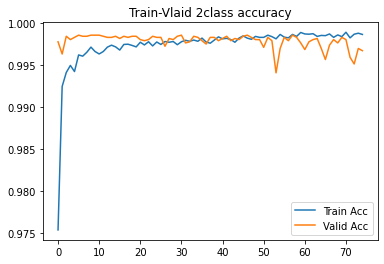

epoch 75 loss: 0.0037: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:49<00:00,  8.43it/s]


train 2class accuracy = 0.99887
[[17225    14]
 [   25 17214]]


epoch 75 loss: 0.0244: 100%|█████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 13.08it/s]


validation 2class accuracy = 0.99829
[[3281    3]
 [  10 4299]]


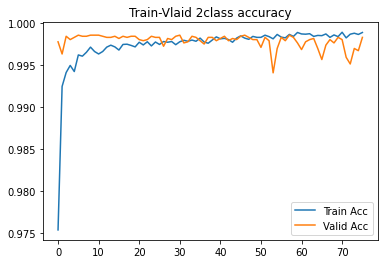

epoch 76 loss: 0.0052: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:49<00:00,  8.42it/s]


train 2class accuracy = 0.99878
[[17222    17]
 [   25 17214]]


epoch 76 loss: 0.0240: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.44it/s]


validation 2class accuracy = 0.99658
[[3273   11]
 [  15 4294]]


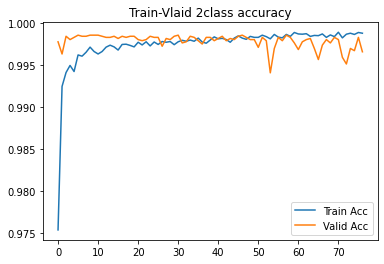

epoch 77 loss: 0.0034: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:41<00:00,  8.58it/s]


train 2class accuracy = 0.99852
[[17213    26]
 [   25 17214]]


epoch 77 loss: 0.0233: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.44it/s]


validation 2class accuracy = 0.99737
[[3275    9]
 [  11 4298]]


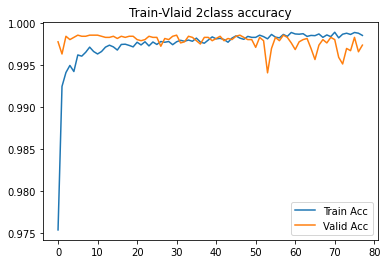

epoch 78 loss: 0.0077: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:41<00:00,  8.58it/s]


train 2class accuracy = 0.99867
[[17221    18]
 [   28 17211]]


epoch 78 loss: 0.0280: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.43it/s]

validation 2class accuracy = 0.99552
[[3264   20]
 [  14 4295]]


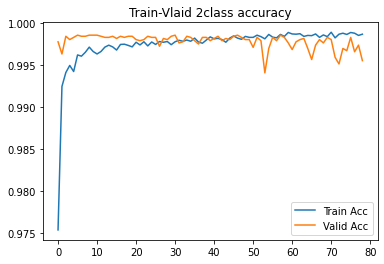

epoch 79 loss: 0.0111: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:41<00:00,  8.58it/s]


train 2class accuracy = 0.99855
[[17216    23]
 [   27 17212]]


epoch 79 loss: 0.0218: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.43it/s]

validation 2class accuracy = 0.99750
[[3275    9]
 [  10 4299]]


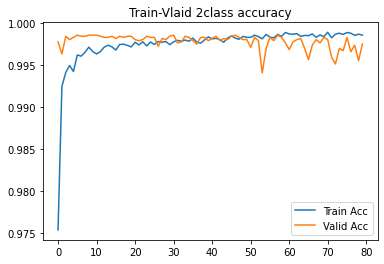

epoch 80 loss: 0.0040: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:42<00:00,  8.57it/s]


train 2class accuracy = 0.99907
[[17227    12]
 [   20 17219]]


epoch 80 loss: 0.0231: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.42it/s]


validation 2class accuracy = 0.99776
[[3279    5]
 [  12 4297]]


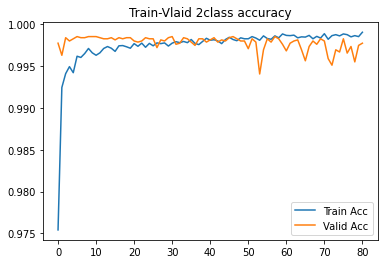

epoch 81 loss: 0.0017: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:42<00:00,  8.57it/s]


train 2class accuracy = 0.99878
[[17222    17]
 [   25 17214]]


epoch 81 loss: 0.0247: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.43it/s]

validation 2class accuracy = 0.99723
[[3274   10]
 [  11 4298]]


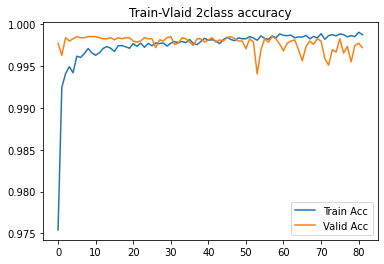

epoch 82 loss: 0.0053: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:42<00:00,  8.57it/s]


train 2class accuracy = 0.99878
[[17223    16]
 [   26 17213]]


epoch 82 loss: 0.0261: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.43it/s]


validation 2class accuracy = 0.99776
[[3280    4]
 [  13 4296]]


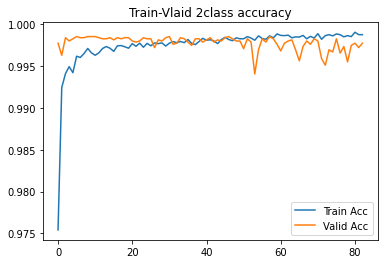

epoch 83 loss: 0.0015: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:42<00:00,  8.56it/s]


train 2class accuracy = 0.99904
[[17223    16]
 [   17 17222]]


epoch 83 loss: 0.0247: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.34it/s]


validation 2class accuracy = 0.99802
[[3280    4]
 [  11 4298]]


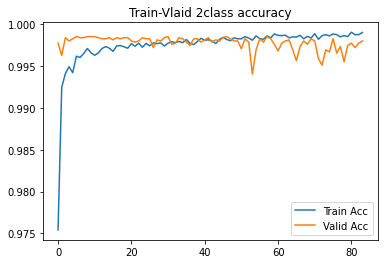

epoch 84 loss: 0.0017: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:50<00:00,  8.40it/s]


train 2class accuracy = 0.99893
[[17222    17]
 [   20 17219]]


epoch 84 loss: 0.0269: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.41it/s]


validation 2class accuracy = 0.99763
[[3278    6]
 [  12 4297]]


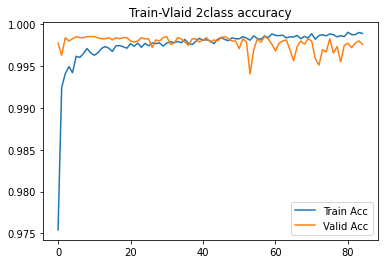

epoch 85 loss: 0.0037: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:42<00:00,  8.57it/s]


train 2class accuracy = 0.99861
[[17217    22]
 [   26 17213]]


epoch 85 loss: 0.0298: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.40it/s]

validation 2class accuracy = 0.99605
[[3280    4]
 [  26 4283]]


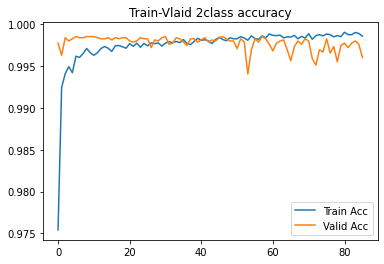

epoch 86 loss: 0.0016: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:41<00:00,  8.58it/s]


train 2class accuracy = 0.99858
[[17221    18]
 [   31 17208]]


epoch 86 loss: 0.0255: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.45it/s]


validation 2class accuracy = 0.99763
[[3280    4]
 [  14 4295]]


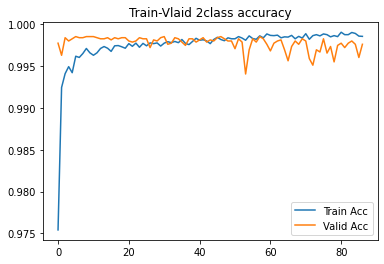

epoch 87 loss: 0.0039: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:41<00:00,  8.58it/s]


train 2class accuracy = 0.99901
[[17227    12]
 [   22 17217]]


epoch 87 loss: 0.0225: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.44it/s]


validation 2class accuracy = 0.99802
[[3278    6]
 [   9 4300]]


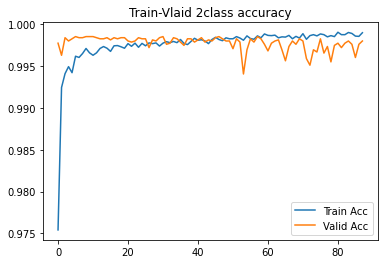

epoch 88 loss: 0.0023: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:42<00:00,  8.57it/s]


train 2class accuracy = 0.99852
[[17221    18]
 [   33 17206]]


epoch 88 loss: 0.0218: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.37it/s]

validation 2class accuracy = 0.99802
[[3279    5]
 [  10 4299]]


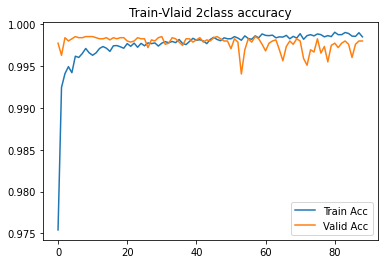

epoch 89 loss: 0.0079: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:42<00:00,  8.57it/s]


train 2class accuracy = 0.99907
[[17228    11]
 [   21 17218]]


epoch 89 loss: 0.0230: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.44it/s]


validation 2class accuracy = 0.99855
[[3281    3]
 [   8 4301]]


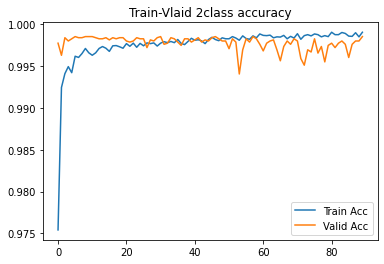

epoch 90 loss: 0.0011: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:41<00:00,  8.59it/s]


train 2class accuracy = 0.99861
[[17218    21]
 [   27 17212]]


epoch 90 loss: 0.0208: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.44it/s]


validation 2class accuracy = 0.99829
[[3281    3]
 [  10 4299]]


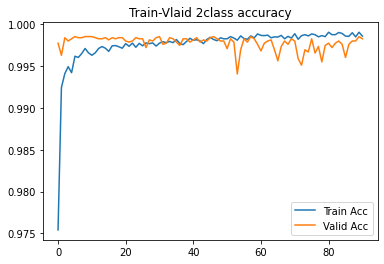

epoch 91 loss: 0.0034: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:41<00:00,  8.58it/s]


train 2class accuracy = 0.99878
[[17221    18]
 [   24 17215]]


epoch 91 loss: 0.0192: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.44it/s]

validation 2class accuracy = 0.99829
[[3280    4]
 [   9 4300]]


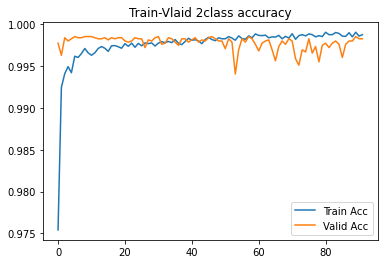

epoch 92 loss: 0.0037: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:42<00:00,  8.56it/s]


train 2class accuracy = 0.99869
[[17220    19]
 [   26 17213]]


epoch 92 loss: 0.0256: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.43it/s]


validation 2class accuracy = 0.99723
[[3281    3]
 [  18 4291]]


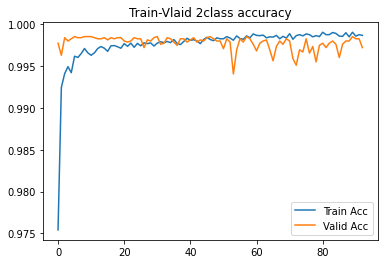

epoch 93 loss: 0.0027: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:42<00:00,  8.57it/s]


train 2class accuracy = 0.99893
[[17223    16]
 [   21 17218]]


epoch 93 loss: 0.0254: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.41it/s]


validation 2class accuracy = 0.99789
[[3280    4]
 [  12 4297]]


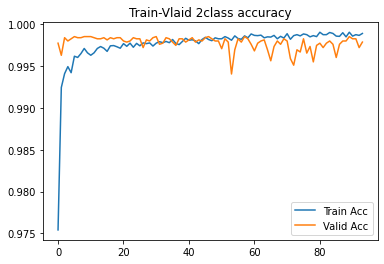

epoch 94 loss: 0.0006: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:42<00:00,  8.57it/s]


train 2class accuracy = 0.99884
[[17221    18]
 [   22 17217]]


epoch 94 loss: 0.0215: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.42it/s]


validation 2class accuracy = 0.99789
[[3279    5]
 [  11 4298]]


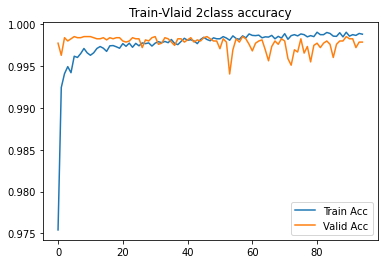

epoch 95 loss: 0.0033: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:42<00:00,  8.57it/s]


train 2class accuracy = 0.99878
[[17220    19]
 [   23 17216]]


epoch 95 loss: 0.0259: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.43it/s]


validation 2class accuracy = 0.99723
[[3280    4]
 [  17 4292]]


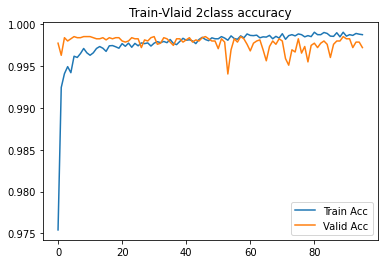

epoch 96 loss: 0.0039: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:42<00:00,  8.57it/s]


train 2class accuracy = 0.99904
[[17227    12]
 [   21 17218]]


epoch 96 loss: 0.0216: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.44it/s]


validation 2class accuracy = 0.99802
[[3281    3]
 [  12 4297]]


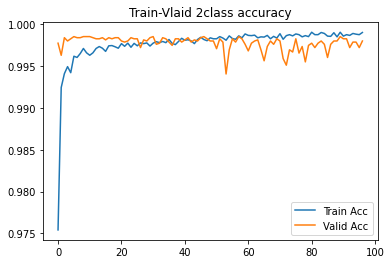

epoch 97 loss: 0.0137: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:42<00:00,  8.58it/s]


train 2class accuracy = 0.99904
[[17222    17]
 [   16 17223]]


epoch 97 loss: 0.0217: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.44it/s]


validation 2class accuracy = 0.99750
[[3279    5]
 [  14 4295]]


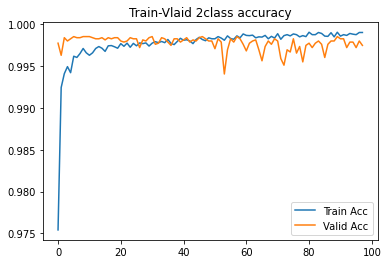

epoch 98 loss: 0.0041: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:42<00:00,  8.57it/s]


train 2class accuracy = 0.99875
[[17221    18]
 [   25 17214]]


epoch 98 loss: 0.0234: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.44it/s]


validation 2class accuracy = 0.99763
[[3274   10]
 [   8 4301]]


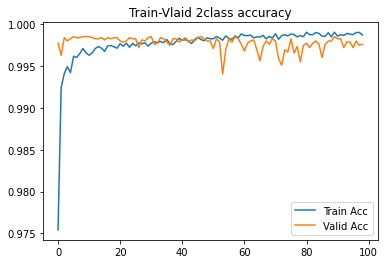

epoch 99 loss: 0.0111: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:42<00:00,  8.57it/s]


train 2class accuracy = 0.99901
[[17225    14]
 [   20 17219]]


epoch 99 loss: 0.0226: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.44it/s]

validation 2class accuracy = 0.99829
[[3281    3]
 [  10 4299]]


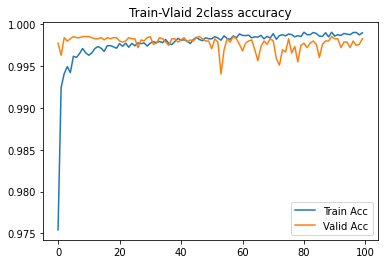

time : 12:54:02
Best Epoch : 5
Best Train Accuracy : 0.99620
[[17185    54]
 [   77 17162]]
Best Valid Accuracy : 0.99855
[[3281    3]
 [   8 4301]]
Training with 1 started
30371 7593


epoch 0 loss: 0.0427: 100%|████████████████████████████████████████████████████████| 3448/3448 [06:43<00:00,  8.55it/s]


train 2class accuracy = 0.97456
[[16841   397]
 [  480 16758]]


epoch 0 loss: 0.0124: 100%|██████████████████████████████████████████████████████████| 760/760 [00:57<00:00, 13.28it/s]

validation 2class accuracy = 0.99789
[[3278    5]
 [  11 4299]]


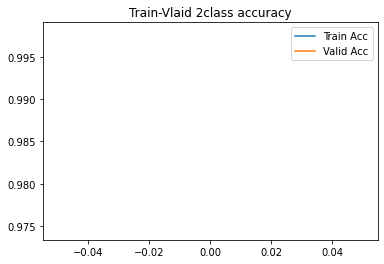

epoch 1 loss: 0.0263: 100%|████████████████████████████████████████████████████████| 3448/3448 [06:47<00:00,  8.47it/s]


train 2class accuracy = 0.99284
[[17120   118]
 [  129 17109]]


epoch 1 loss: 0.0111: 100%|██████████████████████████████████████████████████████████| 760/760 [00:57<00:00, 13.20it/s]

validation 2class accuracy = 0.99881
[[3278    5]
 [   4 4306]]


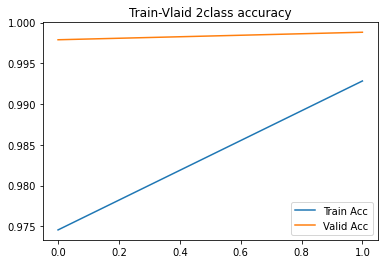

epoch 2 loss: 0.0486: 100%|████████████████████████████████████████████████████████| 3448/3448 [06:50<00:00,  8.41it/s]


train 2class accuracy = 0.99373
[[17120   118]
 [   98 17140]]


epoch 2 loss: 0.0108: 100%|██████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 13.02it/s]


validation 2class accuracy = 0.99789
[[3270   13]
 [   3 4307]]


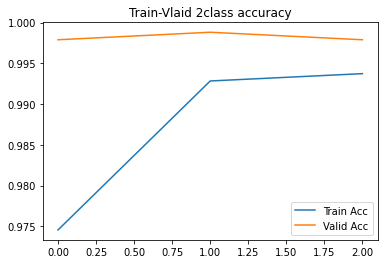

epoch 3 loss: 0.0257: 100%|████████████████████████████████████████████████████████| 3448/3448 [06:47<00:00,  8.47it/s]


train 2class accuracy = 0.99408
[[17141    97]
 [  107 17131]]


epoch 3 loss: 0.0089: 100%|██████████████████████████████████████████████████████████| 760/760 [00:57<00:00, 13.23it/s]

validation 2class accuracy = 0.99881
[[3279    4]
 [   5 4305]]


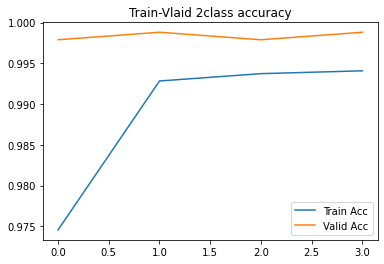

epoch 4 loss: 0.0131: 100%|████████████████████████████████████████████████████████| 3448/3448 [06:46<00:00,  8.49it/s]


train 2class accuracy = 0.99510
[[17161    77]
 [   92 17146]]


epoch 4 loss: 0.0061: 100%|██████████████████████████████████████████████████████████| 760/760 [00:57<00:00, 13.22it/s]

validation 2class accuracy = 0.99908
[[3279    4]
 [   3 4307]]


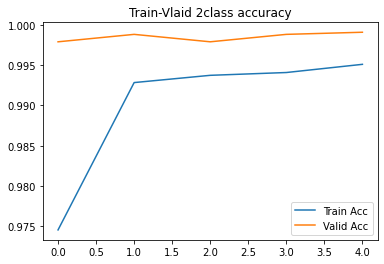

epoch 5 loss: 0.0310: 100%|████████████████████████████████████████████████████████| 3448/3448 [06:48<00:00,  8.43it/s]


train 2class accuracy = 0.99487
[[17151    87]
 [   90 17148]]


epoch 5 loss: 0.0134: 100%|██████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 13.04it/s]


validation 2class accuracy = 0.99868
[[3278    5]
 [   5 4305]]


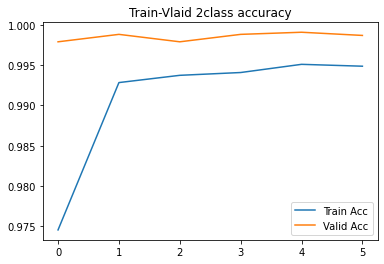

epoch 6 loss: 0.0200: 100%|████████████████████████████████████████████████████████| 3448/3448 [06:49<00:00,  8.43it/s]


train 2class accuracy = 0.99632
[[17181    57]
 [   70 17168]]


epoch 6 loss: 0.0089: 100%|██████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 13.07it/s]


validation 2class accuracy = 0.99855
[[3279    4]
 [   7 4303]]


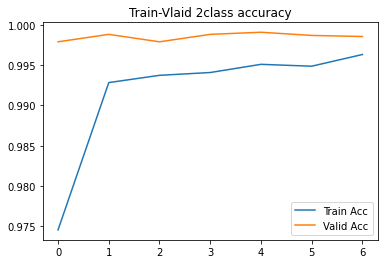

epoch 7 loss: 0.0206: 100%|████████████████████████████████████████████████████████| 3448/3448 [06:49<00:00,  8.43it/s]


train 2class accuracy = 0.99530
[[17175    63]
 [   99 17139]]


epoch 7 loss: 0.0069: 100%|██████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 13.05it/s]


validation 2class accuracy = 0.99908
[[3280    3]
 [   4 4306]]


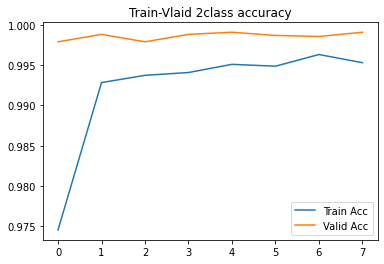

epoch 8 loss: 0.0095: 100%|████████████████████████████████████████████████████████| 3448/3448 [06:48<00:00,  8.43it/s]


train 2class accuracy = 0.99664
[[17189    49]
 [   67 17171]]


epoch 8 loss: 0.0071: 100%|██████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.41it/s]


validation 2class accuracy = 0.99895
[[3278    5]
 [   3 4307]]


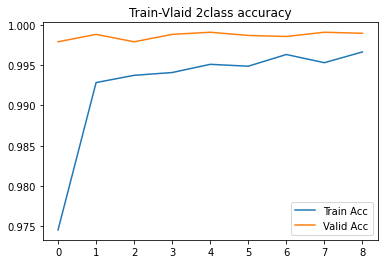

epoch 9 loss: 0.0094: 100%|████████████████████████████████████████████████████████| 3448/3448 [06:42<00:00,  8.57it/s]


train 2class accuracy = 0.99597
[[17182    56]
 [   83 17155]]


epoch 9 loss: 0.0116: 100%|██████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.42it/s]


validation 2class accuracy = 0.99763
[[3271   12]
 [   6 4304]]


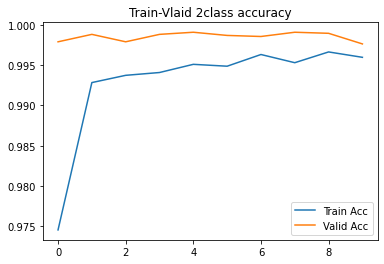

epoch 10 loss: 0.0117: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:42<00:00,  8.57it/s]


train 2class accuracy = 0.99646
[[17188    50]
 [   72 17166]]


epoch 10 loss: 0.0080: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.43it/s]


validation 2class accuracy = 0.99881
[[3277    6]
 [   3 4307]]


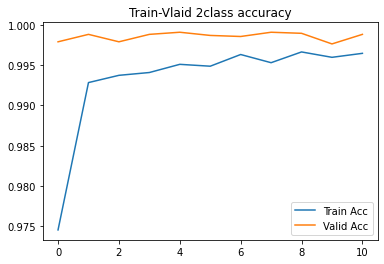

epoch 11 loss: 0.0192: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:42<00:00,  8.57it/s]


train 2class accuracy = 0.99617
[[17183    55]
 [   77 17161]]


epoch 11 loss: 0.0081: 100%|█████████████████████████████████████████████████████████| 760/760 [00:55<00:00, 13.74it/s]


validation 2class accuracy = 0.99895
[[3279    4]
 [   4 4306]]


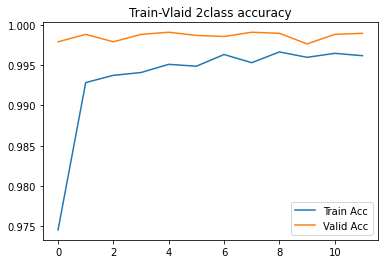

epoch 12 loss: 0.0122: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:42<00:00,  8.57it/s]


train 2class accuracy = 0.99655
[[17178    60]
 [   59 17179]]


epoch 12 loss: 0.0077: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.44it/s]


validation 2class accuracy = 0.99868
[[3279    4]
 [   6 4304]]


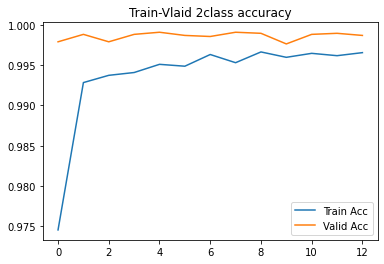

epoch 13 loss: 0.0223: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:42<00:00,  8.57it/s]


train 2class accuracy = 0.99661
[[17189    49]
 [   68 17170]]


epoch 13 loss: 0.0076: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.42it/s]


validation 2class accuracy = 0.99881
[[3279    4]
 [   5 4305]]


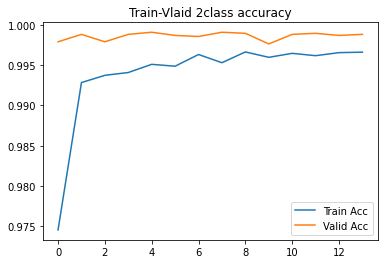

epoch 14 loss: 0.0190: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:42<00:00,  8.58it/s]


train 2class accuracy = 0.99649
[[17180    58]
 [   63 17175]]


epoch 14 loss: 0.0080: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.41it/s]

validation 2class accuracy = 0.99895
[[3280    3]
 [   5 4305]]


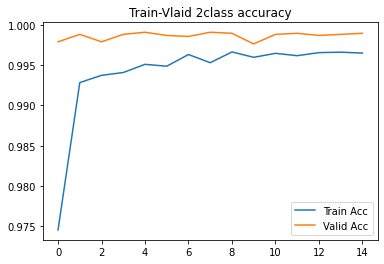

epoch 15 loss: 0.0133: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:42<00:00,  8.57it/s]


train 2class accuracy = 0.99687
[[17191    47]
 [   61 17177]]


epoch 15 loss: 0.0086: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.39it/s]


validation 2class accuracy = 0.99895
[[3279    4]
 [   4 4306]]


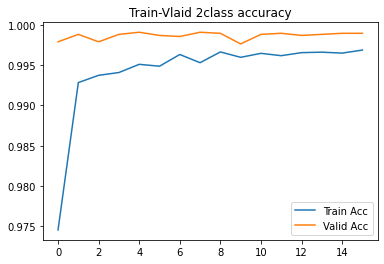

epoch 16 loss: 0.0077: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:44<00:00,  8.52it/s]


train 2class accuracy = 0.99719
[[17197    41]
 [   56 17182]]


epoch 16 loss: 0.0067: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.43it/s]


validation 2class accuracy = 0.99881
[[3279    4]
 [   5 4305]]


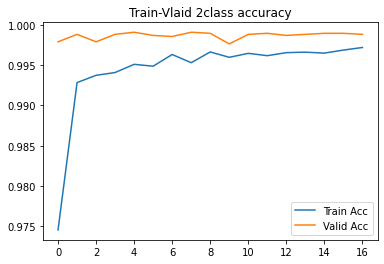

epoch 17 loss: 0.0062: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:41<00:00,  8.58it/s]


train 2class accuracy = 0.99719
[[17199    39]
 [   58 17180]]


epoch 17 loss: 0.0048: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.42it/s]


validation 2class accuracy = 0.99921
[[3280    3]
 [   3 4307]]


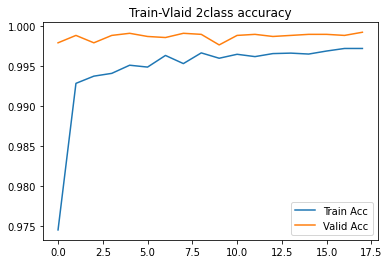

epoch 18 loss: 0.0122: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:41<00:00,  8.58it/s]


train 2class accuracy = 0.99719
[[17196    42]
 [   55 17183]]


epoch 18 loss: 0.0055: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.43it/s]

validation 2class accuracy = 0.99921
[[3280    3]
 [   3 4307]]


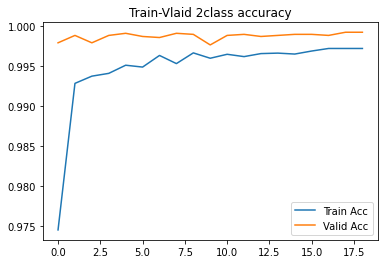

epoch 19 loss: 0.0058: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:41<00:00,  8.59it/s]


train 2class accuracy = 0.99771
[[17205    33]
 [   46 17192]]


epoch 19 loss: 0.0059: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.40it/s]


validation 2class accuracy = 0.99908
[[3278    5]
 [   2 4308]]


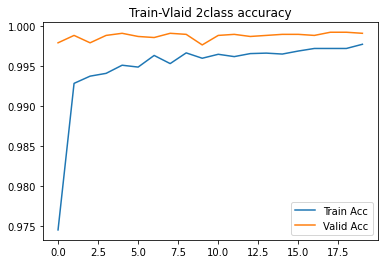

epoch 20 loss: 0.0072: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:42<00:00,  8.58it/s]


train 2class accuracy = 0.99707
[[17197    41]
 [   60 17178]]


epoch 20 loss: 0.0045: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.38it/s]


validation 2class accuracy = 0.99947
[[3281    2]
 [   2 4308]]


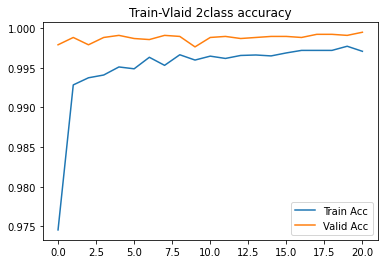

epoch 21 loss: 0.0073: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:41<00:00,  8.58it/s]


train 2class accuracy = 0.99774
[[17205    33]
 [   45 17193]]


epoch 21 loss: 0.0061: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.42it/s]

validation 2class accuracy = 0.99881
[[3278    5]
 [   4 4306]]


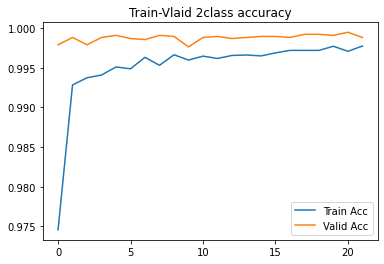

epoch 22 loss: 0.0118: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:41<00:00,  8.58it/s]


train 2class accuracy = 0.99739
[[17206    32]
 [   58 17180]]


epoch 22 loss: 0.0049: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.41it/s]

validation 2class accuracy = 0.99908
[[3279    4]
 [   3 4307]]


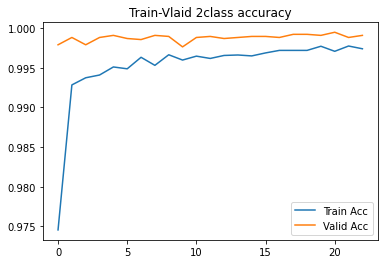

epoch 23 loss: 0.0102: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:42<00:00,  8.57it/s]


train 2class accuracy = 0.99759
[[17204    34]
 [   49 17189]]


epoch 23 loss: 0.0045: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.41it/s]


validation 2class accuracy = 0.99921
[[3280    3]
 [   3 4307]]


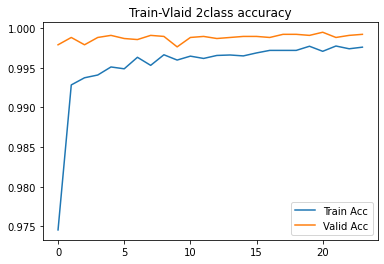

epoch 24 loss: 0.0120: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:44<00:00,  8.53it/s]


train 2class accuracy = 0.99727
[[17196    42]
 [   52 17186]]


epoch 24 loss: 0.0067: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.44it/s]


validation 2class accuracy = 0.99881
[[3280    3]
 [   6 4304]]


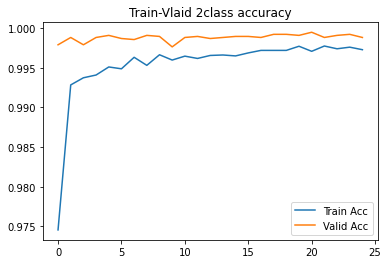

epoch 25 loss: 0.0147: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:42<00:00,  8.57it/s]


train 2class accuracy = 0.99727
[[17202    36]
 [   58 17180]]


epoch 25 loss: 0.0069: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.43it/s]

validation 2class accuracy = 0.99868
[[3279    4]
 [   6 4304]]


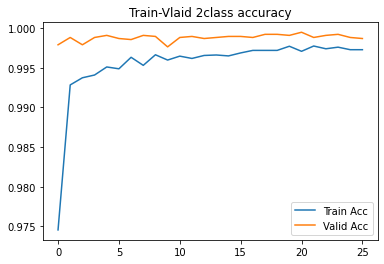

epoch 26 loss: 0.0051: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:43<00:00,  8.55it/s]


train 2class accuracy = 0.99748
[[17201    37]
 [   50 17188]]


epoch 26 loss: 0.0079: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.41it/s]


validation 2class accuracy = 0.99776
[[3280    3]
 [  14 4296]]


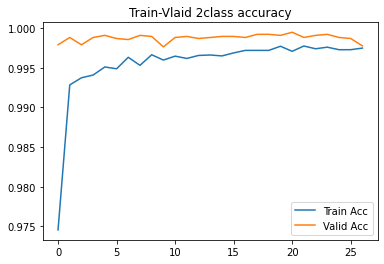

epoch 27 loss: 0.0073: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:42<00:00,  8.57it/s]


train 2class accuracy = 0.99768
[[17209    29]
 [   51 17187]]


epoch 27 loss: 0.0052: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.40it/s]

validation 2class accuracy = 0.99881
[[3281    2]
 [   7 4303]]


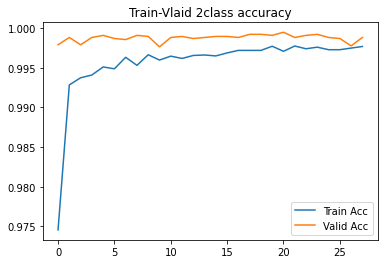

epoch 28 loss: 0.0076: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:42<00:00,  8.57it/s]


train 2class accuracy = 0.99748
[[17203    35]
 [   52 17186]]


epoch 28 loss: 0.0073: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.43it/s]


validation 2class accuracy = 0.99868
[[3279    4]
 [   6 4304]]


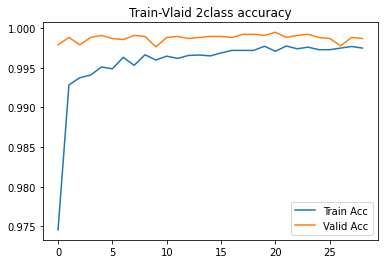

epoch 29 loss: 0.0167: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:41<00:00,  8.58it/s]


train 2class accuracy = 0.99733
[[17204    34]
 [   58 17180]]


epoch 29 loss: 0.0087: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.42it/s]


validation 2class accuracy = 0.99881
[[3276    7]
 [   2 4308]]


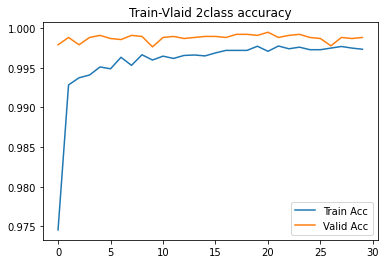

epoch 30 loss: 0.0054: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:42<00:00,  8.57it/s]


train 2class accuracy = 0.99780
[[17210    28]
 [   48 17190]]


epoch 30 loss: 0.0056: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.42it/s]


validation 2class accuracy = 0.99895
[[3280    3]
 [   5 4305]]


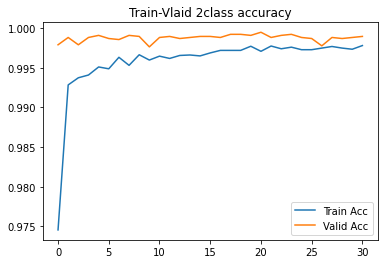

epoch 31 loss: 0.0180: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:41<00:00,  8.58it/s]


train 2class accuracy = 0.99736
[[17198    40]
 [   51 17187]]


epoch 31 loss: 0.0071: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.56it/s]


validation 2class accuracy = 0.99881
[[3279    4]
 [   5 4305]]


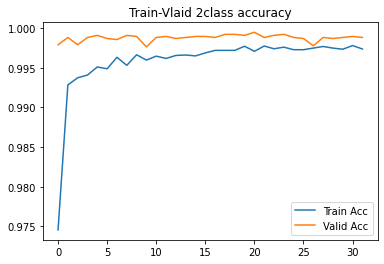

epoch 32 loss: 0.0137: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:47<00:00,  8.47it/s]


train 2class accuracy = 0.99768
[[17209    29]
 [   51 17187]]


epoch 32 loss: 0.0083: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.42it/s]

validation 2class accuracy = 0.99802
[[3278    5]
 [  10 4300]]


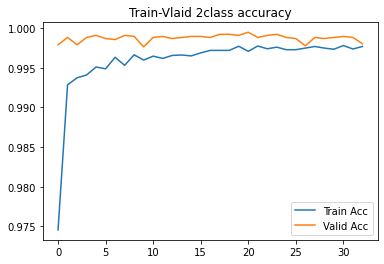

epoch 33 loss: 0.0083: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:41<00:00,  8.58it/s]


train 2class accuracy = 0.99771
[[17211    27]
 [   52 17186]]


epoch 33 loss: 0.0079: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.42it/s]

validation 2class accuracy = 0.99816
[[3278    5]
 [   9 4301]]


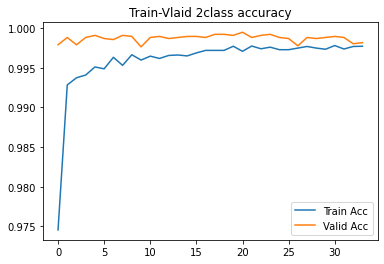

epoch 34 loss: 0.0078: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:44<00:00,  8.53it/s]


train 2class accuracy = 0.99791
[[17208    30]
 [   42 17196]]


epoch 34 loss: 0.0062: 100%|█████████████████████████████████████████████████████████| 760/760 [00:57<00:00, 13.13it/s]


validation 2class accuracy = 0.99868
[[3281    2]
 [   8 4302]]


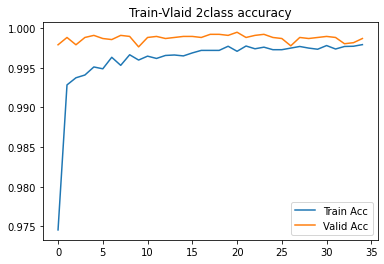

epoch 35 loss: 0.0027: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:49<00:00,  8.42it/s]


train 2class accuracy = 0.99777
[[17204    34]
 [   43 17195]]


epoch 35 loss: 0.0083: 100%|█████████████████████████████████████████████████████████| 760/760 [01:23<00:00,  9.10it/s]


validation 2class accuracy = 0.99816
[[3278    5]
 [   9 4301]]


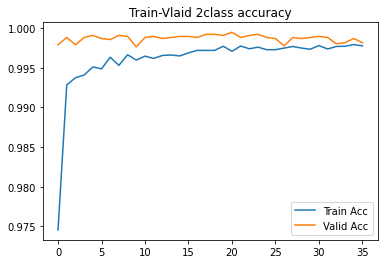

epoch 36 loss: 0.0097: 100%|███████████████████████████████████████████████████████| 3448/3448 [07:43<00:00,  7.44it/s]


train 2class accuracy = 0.99782
[[17209    29]
 [   46 17192]]


epoch 36 loss: 0.0072: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.39it/s]


validation 2class accuracy = 0.99855
[[3280    3]
 [   8 4302]]


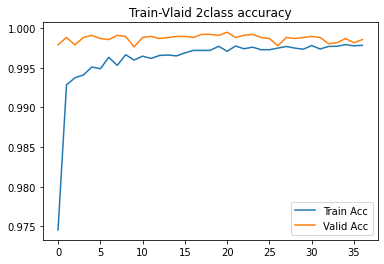

epoch 37 loss: 0.0041: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:49<00:00,  8.42it/s]


train 2class accuracy = 0.99774
[[17211    27]
 [   51 17187]]


epoch 37 loss: 0.0134: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.38it/s]


validation 2class accuracy = 0.99737
[[3279    4]
 [  16 4294]]


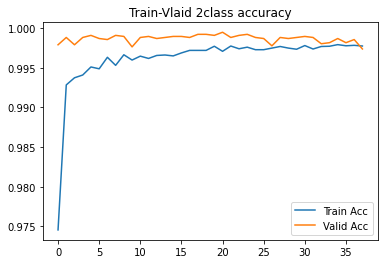

epoch 38 loss: 0.0084: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:44<00:00,  8.51it/s]


train 2class accuracy = 0.99788
[[17214    24]
 [   49 17189]]


epoch 38 loss: 0.0058: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.39it/s]

validation 2class accuracy = 0.99908
[[3280    3]
 [   4 4306]]


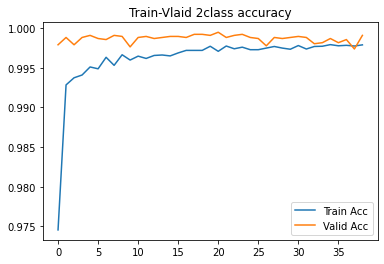

epoch 39 loss: 0.0059: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:43<00:00,  8.54it/s]


train 2class accuracy = 0.99785
[[17210    28]
 [   46 17192]]


epoch 39 loss: 0.0068: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.40it/s]


validation 2class accuracy = 0.99895
[[3279    4]
 [   4 4306]]


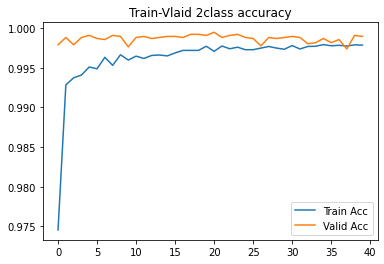

epoch 40 loss: 0.0070: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:43<00:00,  8.55it/s]


train 2class accuracy = 0.99774
[[17211    27]
 [   51 17187]]


epoch 40 loss: 0.0057: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.35it/s]


validation 2class accuracy = 0.99868
[[3279    4]
 [   6 4304]]


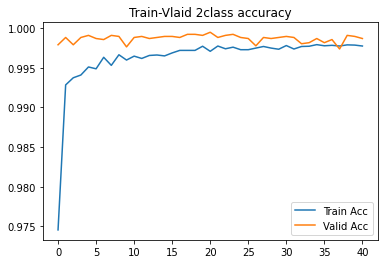

epoch 41 loss: 0.0050: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:48<00:00,  8.45it/s]


train 2class accuracy = 0.99785
[[17210    28]
 [   46 17192]]


epoch 41 loss: 0.0072: 100%|█████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 13.02it/s]

validation 2class accuracy = 0.99895
[[3279    4]
 [   4 4306]]


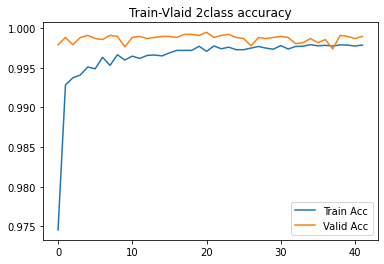

epoch 42 loss: 0.0040: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:48<00:00,  8.44it/s]


train 2class accuracy = 0.99838
[[17220    18]
 [   38 17200]]


epoch 42 loss: 0.0083: 100%|█████████████████████████████████████████████████████████| 760/760 [00:57<00:00, 13.18it/s]


validation 2class accuracy = 0.99855
[[3277    6]
 [   5 4305]]


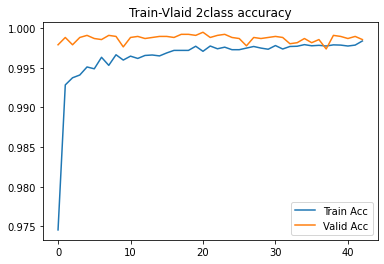

epoch 43 loss: 0.0141: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:49<00:00,  8.42it/s]


train 2class accuracy = 0.99765
[[17205    33]
 [   48 17190]]


epoch 43 loss: 0.0080: 100%|█████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 12.98it/s]

validation 2class accuracy = 0.99868
[[3277    6]
 [   4 4306]]


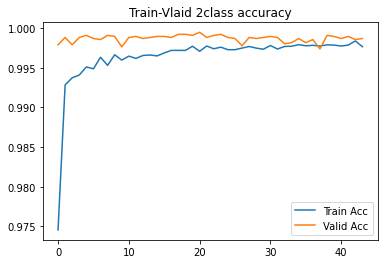

epoch 44 loss: 0.0089: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:50<00:00,  8.41it/s]


train 2class accuracy = 0.99803
[[17217    21]
 [   47 17191]]


epoch 44 loss: 0.0074: 100%|█████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 13.04it/s]

validation 2class accuracy = 0.99895
[[3279    4]
 [   4 4306]]


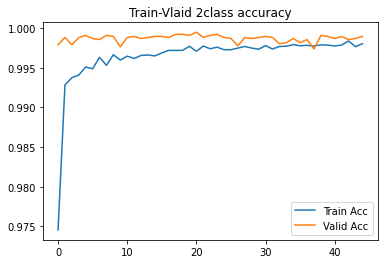

epoch 45 loss: 0.0025: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:49<00:00,  8.42it/s]


train 2class accuracy = 0.99826
[[17219    19]
 [   41 17197]]


epoch 45 loss: 0.0085: 100%|█████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 13.03it/s]


validation 2class accuracy = 0.99816
[[3277    6]
 [   8 4302]]


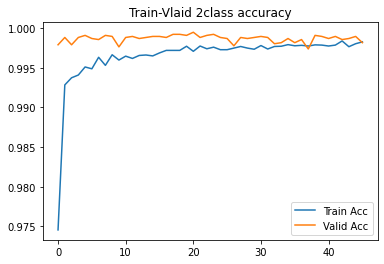

epoch 46 loss: 0.0033: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:49<00:00,  8.42it/s]


train 2class accuracy = 0.99803
[[17208    30]
 [   38 17200]]


epoch 46 loss: 0.0088: 100%|█████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 13.08it/s]


validation 2class accuracy = 0.99829
[[3281    2]
 [  11 4299]]


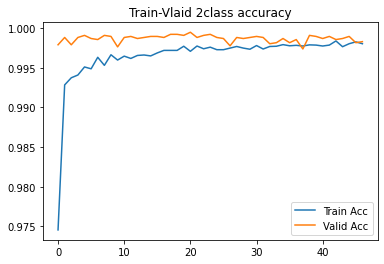

epoch 47 loss: 0.0064: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:42<00:00,  8.58it/s]


train 2class accuracy = 0.99829
[[17219    19]
 [   40 17198]]


epoch 47 loss: 0.0100: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.40it/s]


validation 2class accuracy = 0.99816
[[3274    9]
 [   5 4305]]


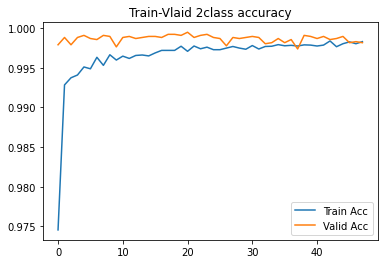

epoch 48 loss: 0.0097: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:42<00:00,  8.57it/s]


train 2class accuracy = 0.99840
[[17217    21]
 [   34 17204]]


epoch 48 loss: 0.0088: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.40it/s]


validation 2class accuracy = 0.99789
[[3276    7]
 [   9 4301]]


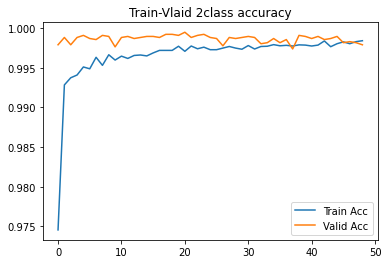

epoch 49 loss: 0.0046: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:42<00:00,  8.57it/s]


train 2class accuracy = 0.99832
[[17217    21]
 [   37 17201]]


epoch 49 loss: 0.0096: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.39it/s]

validation 2class accuracy = 0.99855
[[3277    6]
 [   5 4305]]


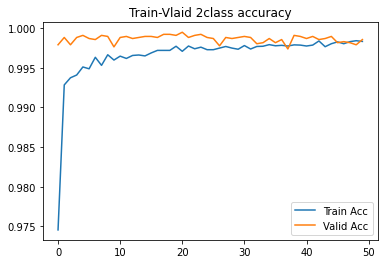

epoch 50 loss: 0.0049: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:42<00:00,  8.56it/s]


train 2class accuracy = 0.99811
[[17211    27]
 [   38 17200]]


epoch 50 loss: 0.0136: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.36it/s]


validation 2class accuracy = 0.99697
[[3272   11]
 [  12 4298]]


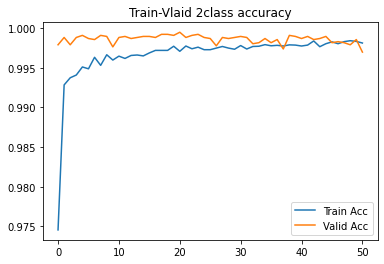

epoch 51 loss: 0.0079: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:45<00:00,  8.50it/s]


train 2class accuracy = 0.99820
[[17213    25]
 [   37 17201]]


epoch 51 loss: 0.0108: 100%|█████████████████████████████████████████████████████████| 760/760 [00:57<00:00, 13.29it/s]


validation 2class accuracy = 0.99802
[[3278    5]
 [  10 4300]]


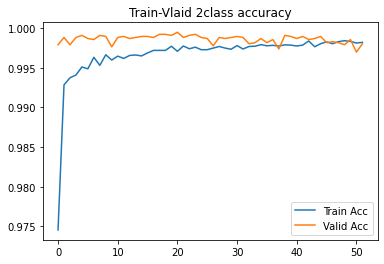

epoch 52 loss: 0.0049: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:47<00:00,  8.46it/s]


train 2class accuracy = 0.99820
[[17216    22]
 [   40 17198]]


epoch 52 loss: 0.0052: 100%|█████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 13.10it/s]


validation 2class accuracy = 0.99908
[[3281    2]
 [   5 4305]]


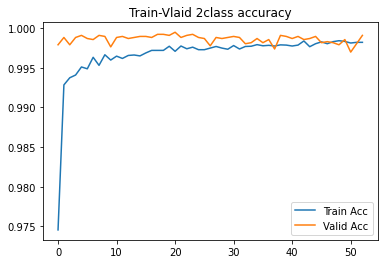

epoch 53 loss: 0.0039: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:48<00:00,  8.43it/s]


train 2class accuracy = 0.99820
[[17217    21]
 [   41 17197]]


epoch 53 loss: 0.0071: 100%|█████████████████████████████████████████████████████████| 760/760 [00:57<00:00, 13.16it/s]

validation 2class accuracy = 0.99881
[[3279    4]
 [   5 4305]]


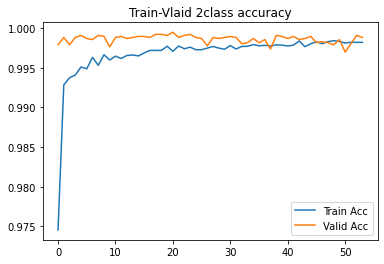

epoch 54 loss: 0.0061: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:49<00:00,  8.43it/s]


train 2class accuracy = 0.99817
[[17219    19]
 [   44 17194]]


epoch 54 loss: 0.0085: 100%|█████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 13.05it/s]


validation 2class accuracy = 0.99855
[[3281    2]
 [   9 4301]]


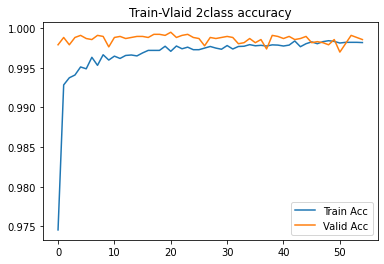

epoch 55 loss: 0.0035: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:50<00:00,  8.41it/s]


train 2class accuracy = 0.99797
[[17205    33]
 [   37 17201]]


epoch 55 loss: 0.0080: 100%|█████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 13.06it/s]

validation 2class accuracy = 0.99868
[[3278    5]
 [   5 4305]]


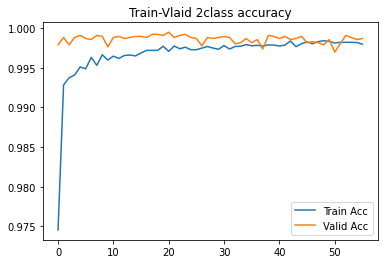

epoch 56 loss: 0.0043: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:49<00:00,  8.42it/s]


train 2class accuracy = 0.99814
[[17213    25]
 [   39 17199]]


epoch 56 loss: 0.0066: 100%|█████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 13.05it/s]

validation 2class accuracy = 0.99842
[[3278    5]
 [   7 4303]]


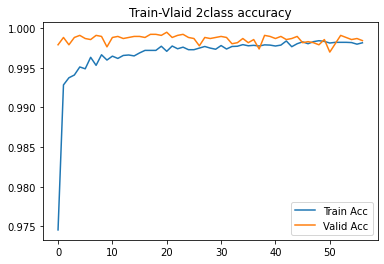

epoch 57 loss: 0.0031: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:49<00:00,  8.42it/s]


train 2class accuracy = 0.99846
[[17218    20]
 [   33 17205]]


epoch 57 loss: 0.0067: 100%|█████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 12.99it/s]


validation 2class accuracy = 0.99855
[[3279    4]
 [   7 4303]]


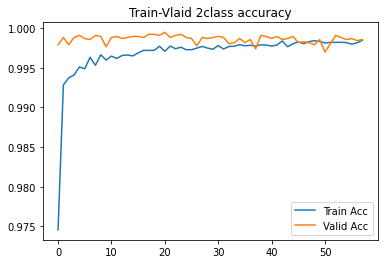

epoch 58 loss: 0.0089: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:50<00:00,  8.41it/s]


train 2class accuracy = 0.99881
[[17222    16]
 [   25 17213]]


epoch 58 loss: 0.0076: 100%|█████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 12.98it/s]

validation 2class accuracy = 0.99855
[[3280    3]
 [   8 4302]]


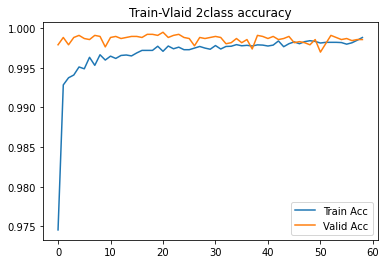

epoch 59 loss: 0.0125: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:50<00:00,  8.41it/s]


train 2class accuracy = 0.99800
[[17214    24]
 [   45 17193]]


epoch 59 loss: 0.0065: 100%|█████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 13.02it/s]


validation 2class accuracy = 0.99934
[[3282    1]
 [   4 4306]]


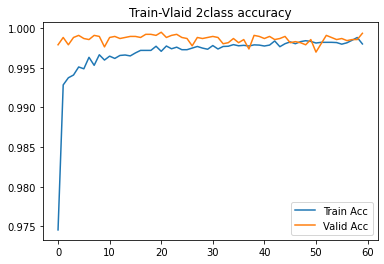

epoch 60 loss: 0.0064: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:49<00:00,  8.41it/s]


train 2class accuracy = 0.99832
[[17213    25]
 [   33 17205]]


epoch 60 loss: 0.0069: 100%|█████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 13.06it/s]

validation 2class accuracy = 0.99908
[[3280    3]
 [   4 4306]]


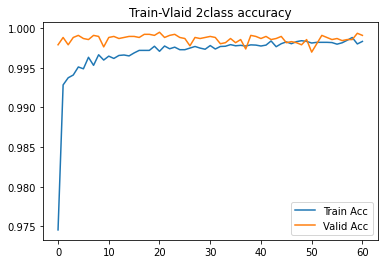

epoch 61 loss: 0.0017: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:49<00:00,  8.41it/s]


train 2class accuracy = 0.99829
[[17216    22]
 [   37 17201]]


epoch 61 loss: 0.0065: 100%|█████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 13.02it/s]

validation 2class accuracy = 0.99908
[[3281    2]
 [   5 4305]]


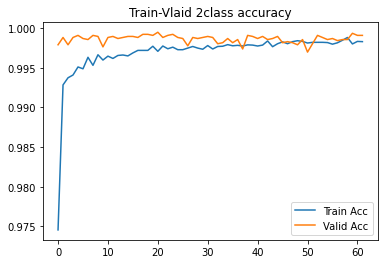

epoch 62 loss: 0.0030: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:50<00:00,  8.41it/s]


train 2class accuracy = 0.99840
[[17212    26]
 [   29 17209]]


epoch 62 loss: 0.0080: 100%|█████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 13.04it/s]


validation 2class accuracy = 0.99881
[[3280    3]
 [   6 4304]]


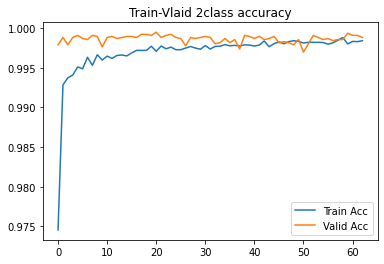

epoch 63 loss: 0.0058: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:50<00:00,  8.41it/s]


train 2class accuracy = 0.99838
[[17211    27]
 [   29 17209]]


epoch 63 loss: 0.0095: 100%|█████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 13.04it/s]

validation 2class accuracy = 0.99776
[[3281    2]
 [  15 4295]]


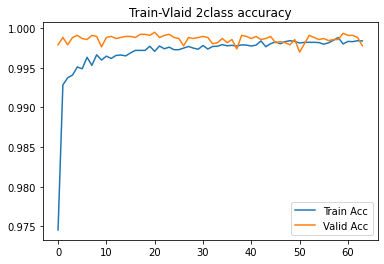

epoch 64 loss: 0.0083: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:50<00:00,  8.41it/s]


train 2class accuracy = 0.99838
[[17215    23]
 [   33 17205]]


epoch 64 loss: 0.0122: 100%|█████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 13.06it/s]


validation 2class accuracy = 0.99802
[[3280    3]
 [  12 4298]]


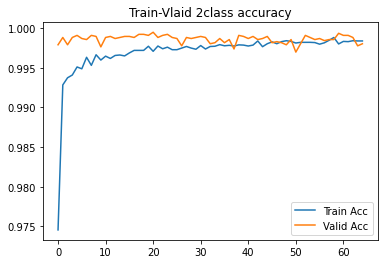

epoch 65 loss: 0.0020: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:49<00:00,  8.42it/s]


train 2class accuracy = 0.99869
[[17222    16]
 [   29 17209]]


epoch 65 loss: 0.0087: 100%|█████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 13.05it/s]

validation 2class accuracy = 0.99881
[[3279    4]
 [   5 4305]]


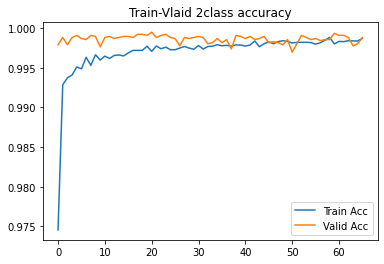

epoch 66 loss: 0.0088: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:50<00:00,  8.40it/s]


train 2class accuracy = 0.99867
[[17222    16]
 [   30 17208]]


epoch 66 loss: 0.0112: 100%|█████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 13.04it/s]


validation 2class accuracy = 0.99763
[[3278    5]
 [  13 4297]]


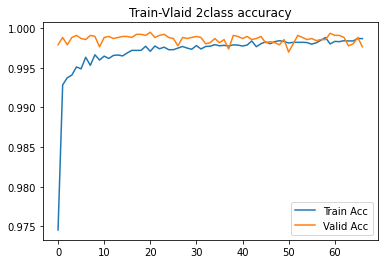

epoch 67 loss: 0.0080: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:49<00:00,  8.41it/s]


train 2class accuracy = 0.99829
[[17216    22]
 [   37 17201]]


epoch 67 loss: 0.0111: 100%|█████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 13.04it/s]


validation 2class accuracy = 0.99789
[[3277    6]
 [  10 4300]]


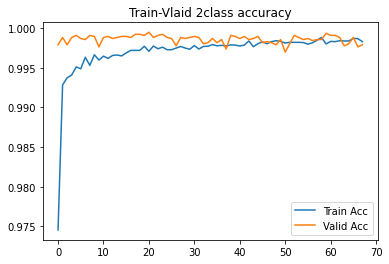

epoch 68 loss: 0.0090: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:49<00:00,  8.42it/s]


train 2class accuracy = 0.99893
[[17225    13]
 [   24 17214]]


epoch 68 loss: 0.0086: 100%|█████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 13.04it/s]


validation 2class accuracy = 0.99868
[[3278    5]
 [   5 4305]]


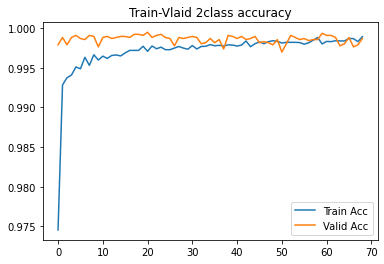

epoch 69 loss: 0.0022: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:49<00:00,  8.42it/s]


train 2class accuracy = 0.99855
[[17221    17]
 [   33 17205]]


epoch 69 loss: 0.0115: 100%|█████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 13.03it/s]


validation 2class accuracy = 0.99776
[[3278    5]
 [  12 4298]]


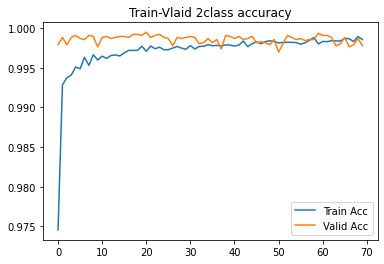

epoch 70 loss: 0.0070: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:50<00:00,  8.41it/s]


train 2class accuracy = 0.99861
[[17215    23]
 [   25 17213]]


epoch 70 loss: 0.0180: 100%|█████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 12.96it/s]

validation 2class accuracy = 0.99631
[[3268   15]
 [  13 4297]]


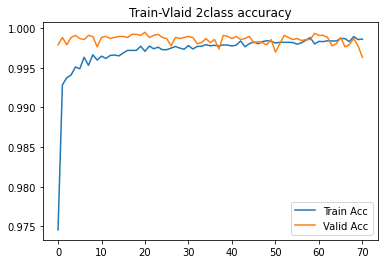

epoch 71 loss: 0.0055: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:50<00:00,  8.40it/s]


train 2class accuracy = 0.99849
[[17220    18]
 [   34 17204]]


epoch 71 loss: 0.0165: 100%|█████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 12.99it/s]

validation 2class accuracy = 0.99697
[[3264   19]
 [   4 4306]]


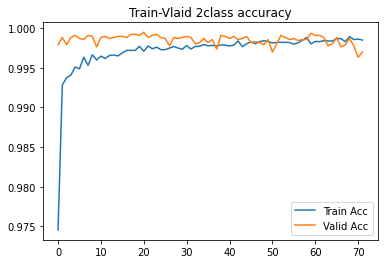

epoch 72 loss: 0.0030: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:49<00:00,  8.42it/s]


train 2class accuracy = 0.99878
[[17224    14]
 [   28 17210]]


epoch 72 loss: 0.0101: 100%|█████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 13.06it/s]


validation 2class accuracy = 0.99881
[[3277    6]
 [   3 4307]]


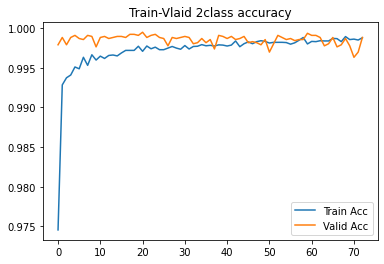

epoch 73 loss: 0.0026: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:50<00:00,  8.40it/s]


train 2class accuracy = 0.99869
[[17219    19]
 [   26 17212]]


epoch 73 loss: 0.0081: 100%|█████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 13.04it/s]


validation 2class accuracy = 0.99855
[[3278    5]
 [   6 4304]]


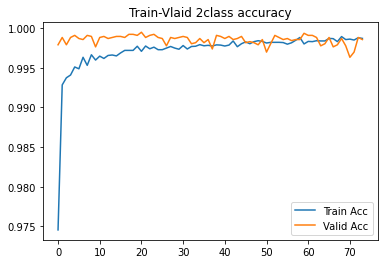

epoch 74 loss: 0.0027: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:49<00:00,  8.42it/s]


train 2class accuracy = 0.99849
[[17217    21]
 [   31 17207]]


epoch 74 loss: 0.0111: 100%|█████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 13.03it/s]


validation 2class accuracy = 0.99816
[[3271   12]
 [   2 4308]]


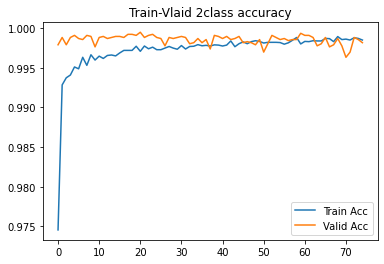

epoch 75 loss: 0.0065: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:49<00:00,  8.43it/s]


train 2class accuracy = 0.99846
[[17215    23]
 [   30 17208]]


epoch 75 loss: 0.0146: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.40it/s]


validation 2class accuracy = 0.99710
[[3266   17]
 [   5 4305]]


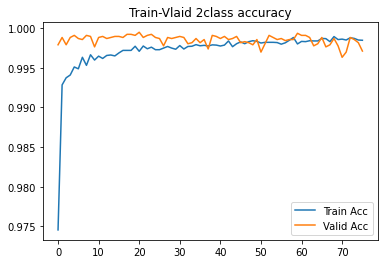

epoch 76 loss: 0.0034: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:42<00:00,  8.57it/s]


train 2class accuracy = 0.99849
[[17218    20]
 [   32 17206]]


epoch 76 loss: 0.0111: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.35it/s]


validation 2class accuracy = 0.99789
[[3279    4]
 [  12 4298]]


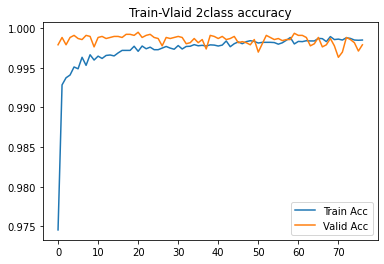

epoch 77 loss: 0.0028: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:42<00:00,  8.57it/s]


train 2class accuracy = 0.99832
[[17215    23]
 [   35 17203]]


epoch 77 loss: 0.0160: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.41it/s]


validation 2class accuracy = 0.99618
[[3259   24]
 [   5 4305]]


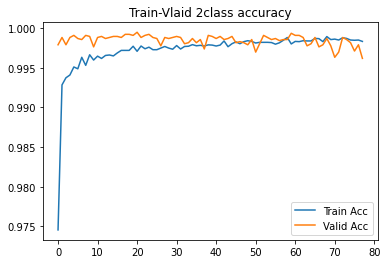

epoch 78 loss: 0.0084: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:42<00:00,  8.57it/s]


train 2class accuracy = 0.99869
[[17220    18]
 [   27 17211]]


epoch 78 loss: 0.0145: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.42it/s]

validation 2class accuracy = 0.99697
[[3276    7]
 [  16 4294]]


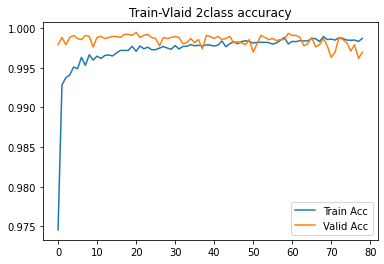

epoch 79 loss: 0.0108: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:42<00:00,  8.58it/s]


train 2class accuracy = 0.99910
[[17225    13]
 [   18 17220]]


epoch 79 loss: 0.0117: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.40it/s]


validation 2class accuracy = 0.99802
[[3271   12]
 [   3 4307]]


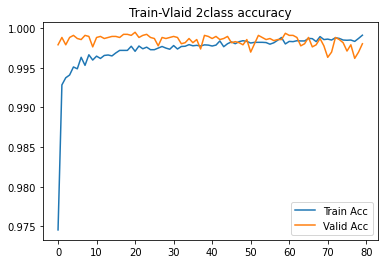

epoch 80 loss: 0.0081: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:45<00:00,  8.49it/s]


train 2class accuracy = 0.99835
[[17213    25]
 [   32 17206]]


epoch 80 loss: 0.0110: 100%|█████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 13.08it/s]

validation 2class accuracy = 0.99789
[[3277    6]
 [  10 4300]]


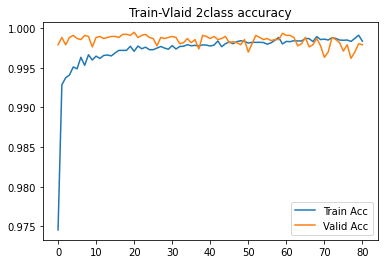

epoch 81 loss: 0.0081: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:49<00:00,  8.42it/s]


train 2class accuracy = 0.99855
[[17217    21]
 [   29 17209]]


epoch 81 loss: 0.0100: 100%|█████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 13.03it/s]


validation 2class accuracy = 0.99816
[[3279    4]
 [  10 4300]]


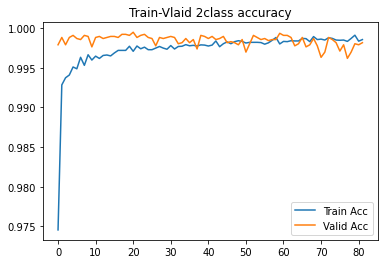

epoch 82 loss: 0.0135: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:50<00:00,  8.41it/s]


train 2class accuracy = 0.99890
[[17224    14]
 [   24 17214]]


epoch 82 loss: 0.0079: 100%|█████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 13.00it/s]


validation 2class accuracy = 0.99842
[[3277    6]
 [   6 4304]]


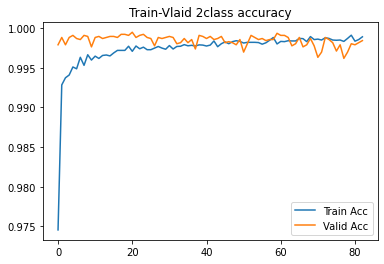

epoch 83 loss: 0.0147: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:50<00:00,  8.40it/s]


train 2class accuracy = 0.99869
[[17219    19]
 [   26 17212]]


epoch 83 loss: 0.0106: 100%|█████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 13.06it/s]


validation 2class accuracy = 0.99763
[[3270   13]
 [   5 4305]]


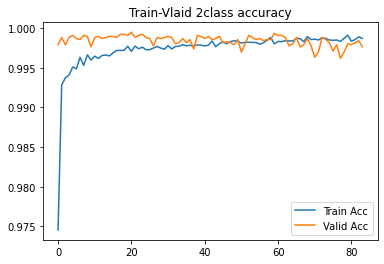

epoch 84 loss: 0.0017: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:49<00:00,  8.41it/s]


train 2class accuracy = 0.99910
[[17226    12]
 [   19 17219]]


epoch 84 loss: 0.0103: 100%|█████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 13.02it/s]

validation 2class accuracy = 0.99776
[[3274    9]
 [   8 4302]]


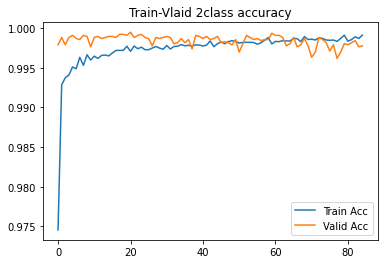

epoch 85 loss: 0.0051: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:49<00:00,  8.41it/s]


train 2class accuracy = 0.99887
[[17221    17]
 [   22 17216]]


epoch 85 loss: 0.0078: 100%|█████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 13.04it/s]


validation 2class accuracy = 0.99855
[[3277    6]
 [   5 4305]]


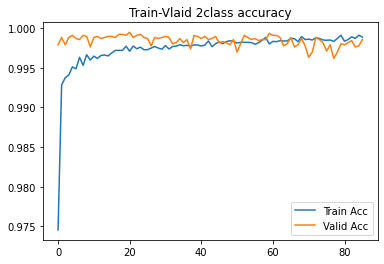

epoch 86 loss: 0.0085: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:49<00:00,  8.42it/s]


train 2class accuracy = 0.99869
[[17218    20]
 [   25 17213]]


epoch 86 loss: 0.0080: 100%|█████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 13.07it/s]


validation 2class accuracy = 0.99908
[[3280    3]
 [   4 4306]]


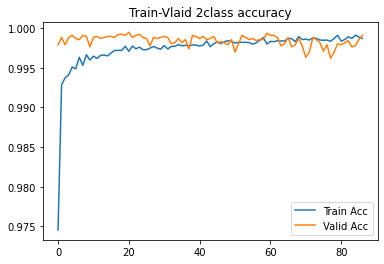

epoch 87 loss: 0.0060: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:50<00:00,  8.41it/s]


train 2class accuracy = 0.99852
[[17214    24]
 [   27 17211]]


epoch 87 loss: 0.0098: 100%|█████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 13.01it/s]

validation 2class accuracy = 0.99829
[[3280    3]
 [  10 4300]]


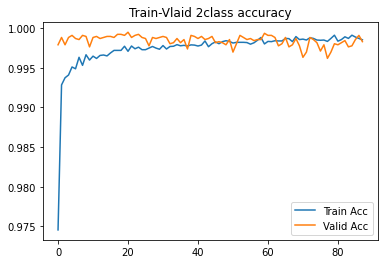

epoch 88 loss: 0.0036: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:49<00:00,  8.41it/s]


train 2class accuracy = 0.99887
[[17223    15]
 [   24 17214]]


epoch 88 loss: 0.0167: 100%|█████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 13.04it/s]

validation 2class accuracy = 0.99710
[[3271   12]
 [  10 4300]]


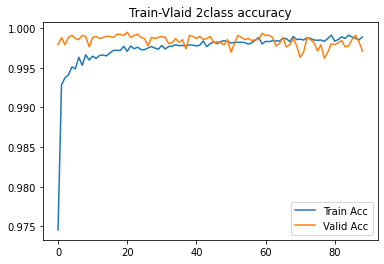

epoch 89 loss: 0.0066: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:49<00:00,  8.41it/s]


train 2class accuracy = 0.99893
[[17224    14]
 [   23 17215]]


epoch 89 loss: 0.0168: 100%|█████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 13.03it/s]


validation 2class accuracy = 0.99592
[[3281    2]
 [  29 4281]]


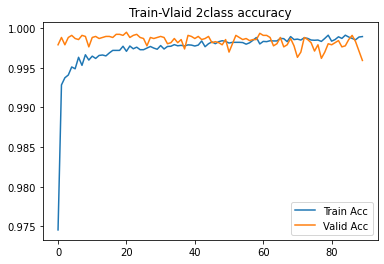

epoch 90 loss: 0.0038: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:50<00:00,  8.40it/s]


train 2class accuracy = 0.99849
[[17216    22]
 [   30 17208]]


epoch 90 loss: 0.0110: 100%|█████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 13.05it/s]

validation 2class accuracy = 0.99816
[[3274    9]
 [   5 4305]]


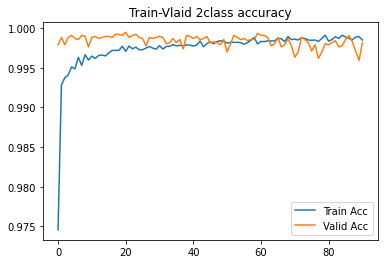

epoch 91 loss: 0.0046: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:50<00:00,  8.40it/s]


train 2class accuracy = 0.99887
[[17225    13]
 [   26 17212]]


epoch 91 loss: 0.0074: 100%|█████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 13.05it/s]


validation 2class accuracy = 0.99895
[[3280    3]
 [   5 4305]]


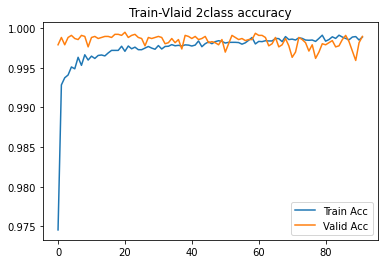

epoch 92 loss: 0.0116: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:49<00:00,  8.42it/s]


train 2class accuracy = 0.99878
[[17222    16]
 [   26 17212]]


epoch 92 loss: 0.0123: 100%|█████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 12.99it/s]


validation 2class accuracy = 0.99763
[[3272   11]
 [   7 4303]]


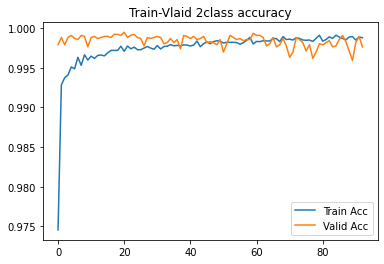

epoch 93 loss: 0.0050: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:50<00:00,  8.41it/s]


train 2class accuracy = 0.99887
[[17223    15]
 [   24 17214]]


epoch 93 loss: 0.0157: 100%|█████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 12.99it/s]

validation 2class accuracy = 0.99671
[[3274    9]
 [  16 4294]]


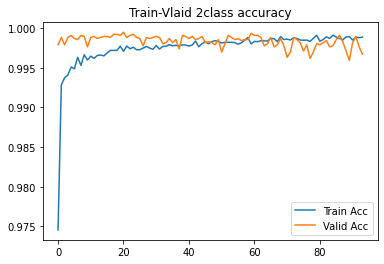

epoch 94 loss: 0.0109: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:49<00:00,  8.41it/s]


train 2class accuracy = 0.99843
[[17216    22]
 [   32 17206]]


epoch 94 loss: 0.0277: 100%|█████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 13.01it/s]

validation 2class accuracy = 0.99539
[[3276    7]
 [  28 4282]]


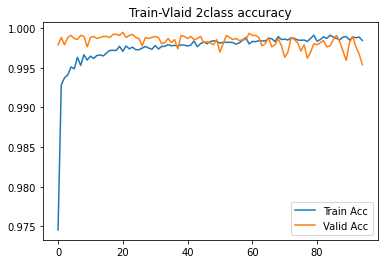

epoch 95 loss: 0.0112: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:50<00:00,  8.40it/s]


train 2class accuracy = 0.99829
[[17209    29]
 [   30 17208]]


epoch 95 loss: 0.0118: 100%|█████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 13.03it/s]

validation 2class accuracy = 0.99789
[[3277    6]
 [  10 4300]]


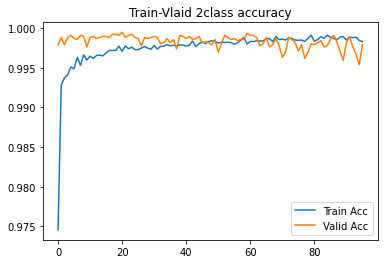

epoch 96 loss: 0.0015: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:49<00:00,  8.41it/s]


train 2class accuracy = 0.99843
[[17218    20]
 [   34 17204]]


epoch 96 loss: 0.0090: 100%|█████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 12.99it/s]


validation 2class accuracy = 0.99881
[[3278    5]
 [   4 4306]]


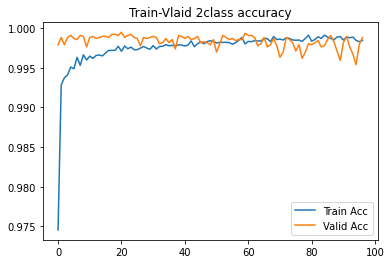

epoch 97 loss: 0.0008: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:50<00:00,  8.40it/s]


train 2class accuracy = 0.99896
[[17225    13]
 [   23 17215]]


epoch 97 loss: 0.0104: 100%|█████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 13.03it/s]


validation 2class accuracy = 0.99855
[[3276    7]
 [   4 4306]]


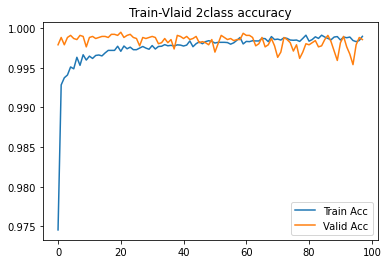

epoch 98 loss: 0.0093: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:50<00:00,  8.39it/s]


train 2class accuracy = 0.99884
[[17223    15]
 [   25 17213]]


epoch 98 loss: 0.0157: 100%|█████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 12.97it/s]


validation 2class accuracy = 0.99671
[[3264   19]
 [   6 4304]]


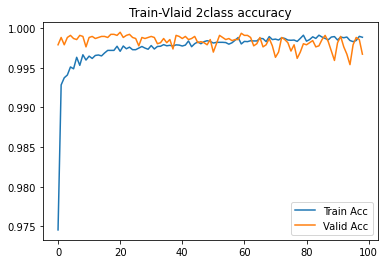

epoch 99 loss: 0.0078: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:50<00:00,  8.39it/s]


train 2class accuracy = 0.99861
[[17220    18]
 [   30 17208]]


epoch 99 loss: 0.0226: 100%|█████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 12.99it/s]


validation 2class accuracy = 0.99328
[[3241   42]
 [   9 4301]]


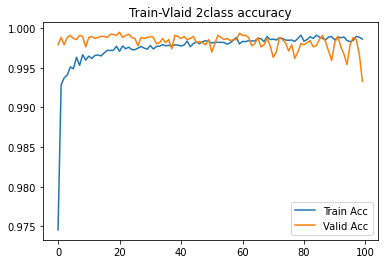

time : 12:55:37
Best Epoch : 20
Best Train Accuracy : 0.99707
[[17197    41]
 [   60 17178]]
Best Valid Accuracy : 0.99947
[[3281    2]
 [   2 4308]]
Training with 2 started
30371 7593


epoch 0 loss: 0.0468: 100%|████████████████████████████████████████████████████████| 3448/3448 [06:50<00:00,  8.41it/s]


train 2class accuracy = 0.97607
[[16885   353]
 [  472 16766]]


epoch 0 loss: 0.0223: 100%|██████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 12.97it/s]

validation 2class accuracy = 0.99658
[[3274    9]
 [  17 4293]]


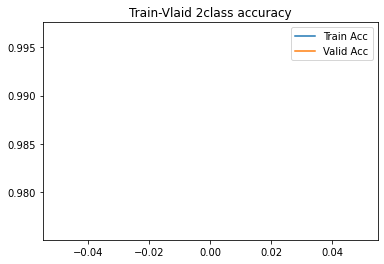

epoch 1 loss: 0.0309: 100%|████████████████████████████████████████████████████████| 3448/3448 [06:49<00:00,  8.41it/s]


train 2class accuracy = 0.99347
[[17135   103]
 [  122 17116]]


epoch 1 loss: 0.0245: 100%|██████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 13.03it/s]


validation 2class accuracy = 0.99658
[[3279    4]
 [  22 4288]]


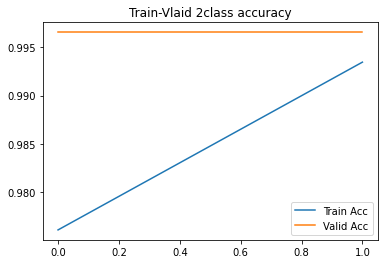

epoch 2 loss: 0.0106: 100%|████████████████████████████████████████████████████████| 3448/3448 [06:49<00:00,  8.41it/s]


train 2class accuracy = 0.99478
[[17146    92]
 [   88 17150]]


epoch 2 loss: 0.0148: 100%|██████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 13.02it/s]


validation 2class accuracy = 0.99802
[[3275    8]
 [   7 4303]]


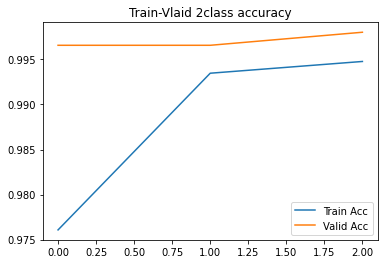

epoch 3 loss: 0.0083: 100%|████████████████████████████████████████████████████████| 3448/3448 [06:49<00:00,  8.41it/s]


train 2class accuracy = 0.99431
[[17153    85]
 [  111 17127]]


epoch 3 loss: 0.0138: 100%|██████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 13.02it/s]


validation 2class accuracy = 0.99789
[[3276    7]
 [   9 4301]]


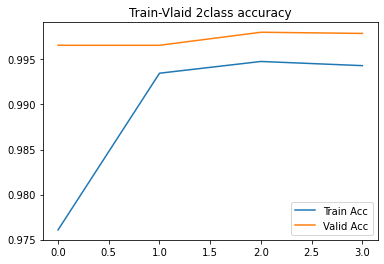

epoch 4 loss: 0.0244: 100%|████████████████████████████████████████████████████████| 3448/3448 [06:49<00:00,  8.42it/s]


train 2class accuracy = 0.99545
[[17169    69]
 [   88 17150]]


epoch 4 loss: 0.0132: 100%|██████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 12.99it/s]

validation 2class accuracy = 0.99829
[[3277    6]
 [   7 4303]]


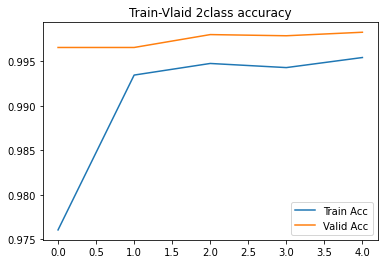

epoch 5 loss: 0.0189: 100%|████████████████████████████████████████████████████████| 3448/3448 [06:50<00:00,  8.40it/s]


train 2class accuracy = 0.99664
[[17182    56]
 [   60 17178]]


epoch 5 loss: 0.0123: 100%|██████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 13.00it/s]


validation 2class accuracy = 0.99855
[[3279    4]
 [   7 4303]]


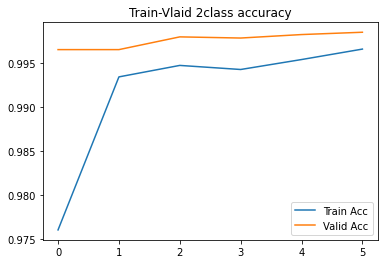

epoch 6 loss: 0.0165: 100%|████████████████████████████████████████████████████████| 3448/3448 [06:51<00:00,  8.39it/s]


train 2class accuracy = 0.99611
[[17165    73]
 [   61 17177]]


epoch 6 loss: 0.0144: 100%|██████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 13.03it/s]


validation 2class accuracy = 0.99737
[[3278    5]
 [  15 4295]]


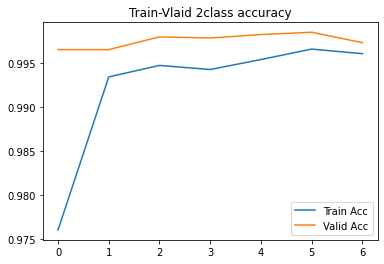

epoch 7 loss: 0.0174: 100%|████████████████████████████████████████████████████████| 3448/3448 [06:50<00:00,  8.39it/s]


train 2class accuracy = 0.99600
[[17180    58]
 [   80 17158]]


epoch 7 loss: 0.0153: 100%|██████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 12.98it/s]


validation 2class accuracy = 0.99710
[[3278    5]
 [  17 4293]]


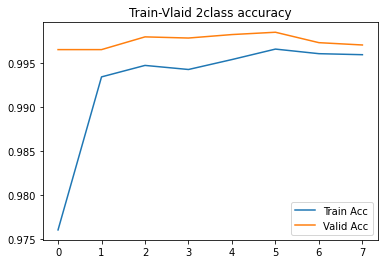

epoch 8 loss: 0.0219: 100%|████████████████████████████████████████████████████████| 3448/3448 [06:50<00:00,  8.40it/s]


train 2class accuracy = 0.99606
[[17177    61]
 [   75 17163]]


epoch 8 loss: 0.0132: 100%|██████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 12.97it/s]

validation 2class accuracy = 0.99763
[[3274    9]
 [   9 4301]]


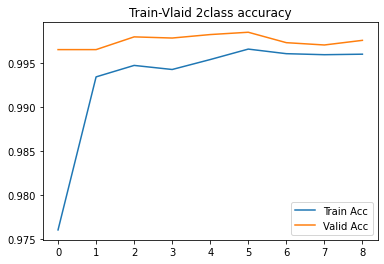

epoch 9 loss: 0.0101: 100%|████████████████████████████████████████████████████████| 3448/3448 [06:49<00:00,  8.41it/s]


train 2class accuracy = 0.99704
[[17194    44]
 [   58 17180]]


epoch 9 loss: 0.0122: 100%|██████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 13.02it/s]

validation 2class accuracy = 0.99829
[[3278    5]
 [   8 4302]]


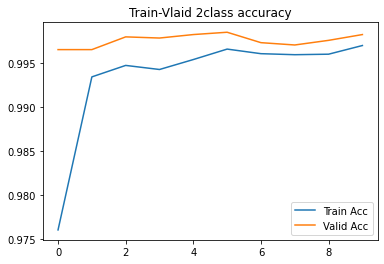

epoch 10 loss: 0.0162: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:50<00:00,  8.41it/s]


train 2class accuracy = 0.99684
[[17189    49]
 [   60 17178]]


epoch 10 loss: 0.0123: 100%|█████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 13.00it/s]

validation 2class accuracy = 0.99829
[[3278    5]
 [   8 4302]]


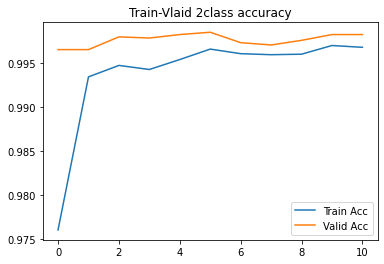

epoch 11 loss: 0.0090: 100%|███████████████████████████████████████████████████████| 3448/3448 [07:15<00:00,  7.92it/s]


train 2class accuracy = 0.99666
[[17180    58]
 [   57 17181]]


epoch 11 loss: 0.0123: 100%|█████████████████████████████████████████████████████████| 760/760 [01:25<00:00,  8.94it/s]


validation 2class accuracy = 0.99829
[[3278    5]
 [   8 4302]]


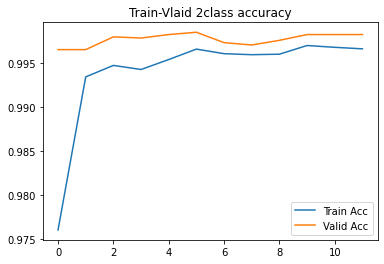

epoch 12 loss: 0.0149: 100%|███████████████████████████████████████████████████████| 3448/3448 [07:29<00:00,  7.67it/s]


train 2class accuracy = 0.99693
[[17194    44]
 [   62 17176]]


epoch 12 loss: 0.0121: 100%|█████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 13.04it/s]

validation 2class accuracy = 0.99816
[[3278    5]
 [   9 4301]]


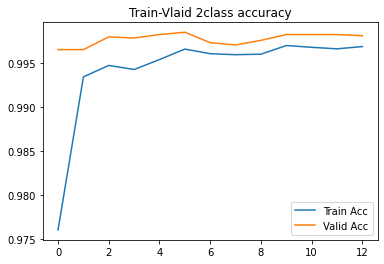

epoch 13 loss: 0.0151: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:53<00:00,  8.35it/s]


train 2class accuracy = 0.99690
[[17192    46]
 [   61 17177]]


epoch 13 loss: 0.0137: 100%|█████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 13.03it/s]

validation 2class accuracy = 0.99802
[[3276    7]
 [   8 4302]]


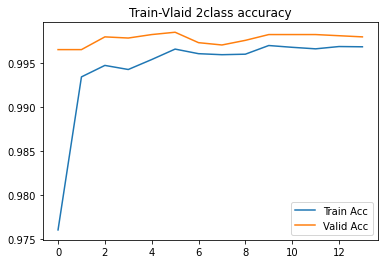

epoch 14 loss: 0.0074: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:50<00:00,  8.41it/s]


train 2class accuracy = 0.99666
[[17187    51]
 [   64 17174]]


epoch 14 loss: 0.0126: 100%|█████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 13.05it/s]

validation 2class accuracy = 0.99816
[[3276    7]
 [   7 4303]]


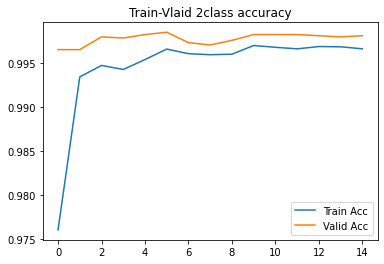

epoch 15 loss: 0.0044: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:49<00:00,  8.43it/s]


train 2class accuracy = 0.99649
[[17180    58]
 [   63 17175]]


epoch 15 loss: 0.0145: 100%|█████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 13.02it/s]


validation 2class accuracy = 0.99816
[[3278    5]
 [   9 4301]]


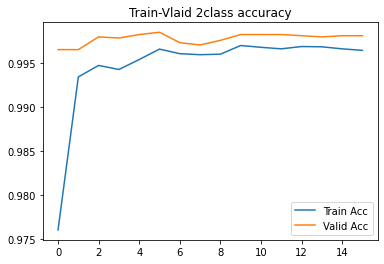

epoch 16 loss: 0.0067: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:50<00:00,  8.41it/s]


train 2class accuracy = 0.99722
[[17197    41]
 [   55 17183]]


epoch 16 loss: 0.0128: 100%|█████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 13.04it/s]


validation 2class accuracy = 0.99829
[[3277    6]
 [   7 4303]]


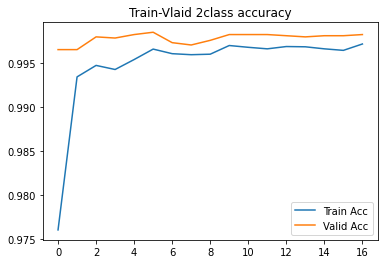

epoch 17 loss: 0.0202: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:50<00:00,  8.40it/s]


train 2class accuracy = 0.99719
[[17194    44]
 [   53 17185]]


epoch 17 loss: 0.0125: 100%|█████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 13.03it/s]

validation 2class accuracy = 0.99829
[[3278    5]
 [   8 4302]]


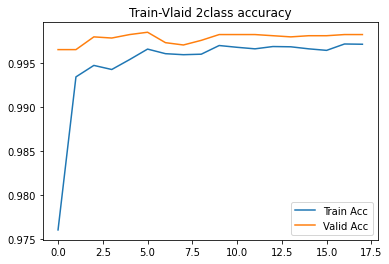

epoch 18 loss: 0.0142: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:50<00:00,  8.40it/s]


train 2class accuracy = 0.99698
[[17194    44]
 [   60 17178]]


epoch 18 loss: 0.0166: 100%|█████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 13.03it/s]

validation 2class accuracy = 0.99776
[[3274    9]
 [   8 4302]]


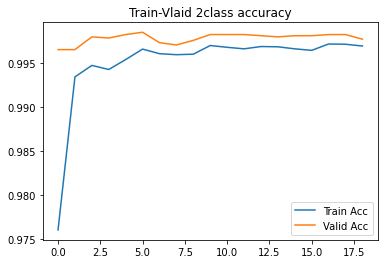

epoch 19 loss: 0.0116: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:50<00:00,  8.40it/s]


train 2class accuracy = 0.99774
[[17206    32]
 [   46 17192]]


epoch 19 loss: 0.0140: 100%|█████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 13.04it/s]

validation 2class accuracy = 0.99842
[[3279    4]
 [   8 4302]]


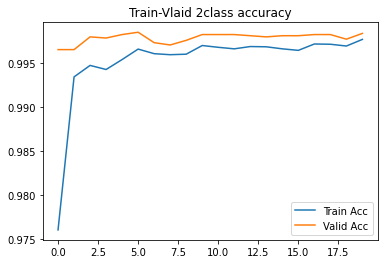

epoch 20 loss: 0.0228: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:50<00:00,  8.40it/s]


train 2class accuracy = 0.99742
[[17202    36]
 [   53 17185]]


epoch 20 loss: 0.0139: 100%|█████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 13.04it/s]


validation 2class accuracy = 0.99789
[[3277    6]
 [  10 4300]]


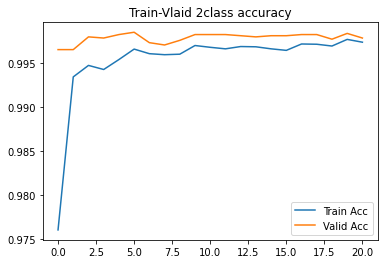

epoch 21 loss: 0.0354: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:50<00:00,  8.41it/s]


train 2class accuracy = 0.99780
[[17213    25]
 [   51 17187]]


epoch 21 loss: 0.0133: 100%|█████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 13.07it/s]


validation 2class accuracy = 0.99842
[[3278    5]
 [   7 4303]]


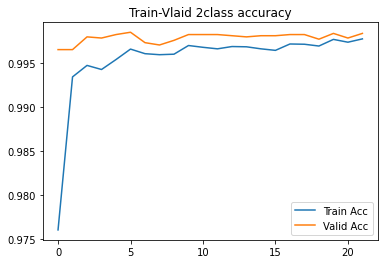

epoch 22 loss: 0.0109: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:49<00:00,  8.41it/s]


train 2class accuracy = 0.99780
[[17207    31]
 [   45 17193]]


epoch 22 loss: 0.0137: 100%|█████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 13.04it/s]

validation 2class accuracy = 0.99842
[[3279    4]
 [   8 4302]]


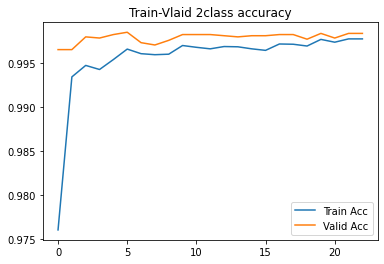

epoch 23 loss: 0.0105: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:50<00:00,  8.41it/s]


train 2class accuracy = 0.99713
[[17198    40]
 [   59 17179]]


epoch 23 loss: 0.0144: 100%|█████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 13.04it/s]

validation 2class accuracy = 0.99816
[[3277    6]
 [   8 4302]]


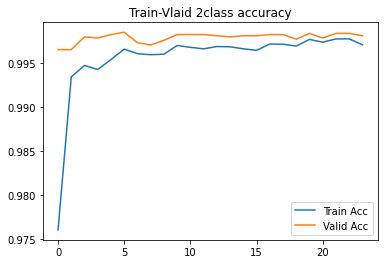

epoch 24 loss: 0.0076: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:49<00:00,  8.41it/s]


train 2class accuracy = 0.99771
[[17202    36]
 [   43 17195]]


epoch 24 loss: 0.0157: 100%|█████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 13.00it/s]


validation 2class accuracy = 0.99829
[[3278    5]
 [   8 4302]]


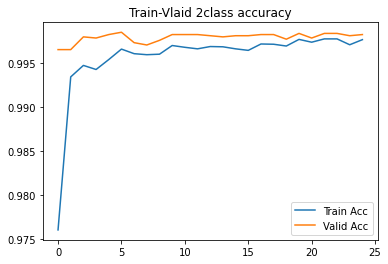

epoch 25 loss: 0.0061: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:49<00:00,  8.41it/s]


train 2class accuracy = 0.99765
[[17207    31]
 [   50 17188]]


epoch 25 loss: 0.0143: 100%|█████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 13.02it/s]


validation 2class accuracy = 0.99842
[[3278    5]
 [   7 4303]]


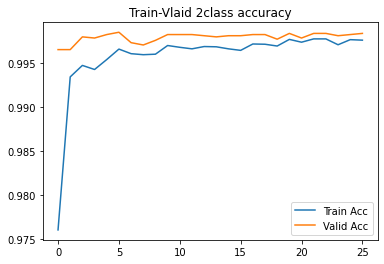

epoch 26 loss: 0.0059: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:51<00:00,  8.38it/s]


train 2class accuracy = 0.99788
[[17212    26]
 [   47 17191]]


epoch 26 loss: 0.0147: 100%|█████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 12.99it/s]

validation 2class accuracy = 0.99829
[[3278    5]
 [   8 4302]]


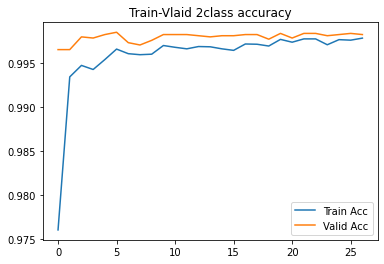

epoch 27 loss: 0.0154: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:49<00:00,  8.42it/s]


train 2class accuracy = 0.99768
[[17204    34]
 [   46 17192]]


epoch 27 loss: 0.0156: 100%|█████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 13.04it/s]

validation 2class accuracy = 0.99789
[[3277    6]
 [  10 4300]]


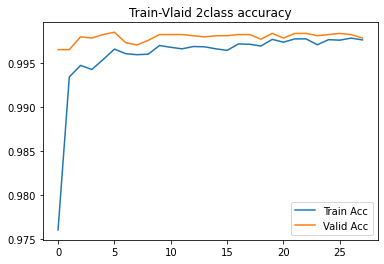

epoch 28 loss: 0.0110: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:49<00:00,  8.42it/s]


train 2class accuracy = 0.99774
[[17208    30]
 [   48 17190]]


epoch 28 loss: 0.0150: 100%|█████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 13.04it/s]

validation 2class accuracy = 0.99710
[[3278    5]
 [  17 4293]]


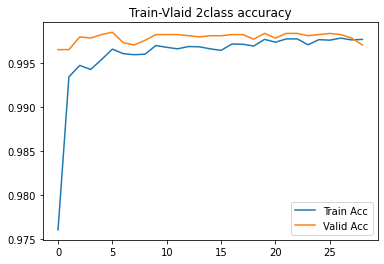

epoch 29 loss: 0.0059: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:49<00:00,  8.42it/s]


train 2class accuracy = 0.99780
[[17207    31]
 [   45 17193]]


epoch 29 loss: 0.0153: 100%|█████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 13.05it/s]

validation 2class accuracy = 0.99816
[[3279    4]
 [  10 4300]]


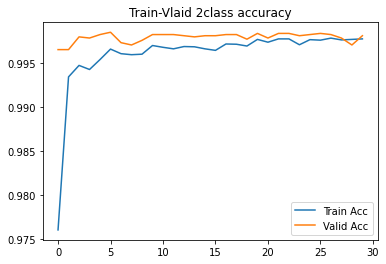

epoch 30 loss: 0.0072: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:49<00:00,  8.41it/s]


train 2class accuracy = 0.99782
[[17208    30]
 [   45 17193]]


epoch 30 loss: 0.0183: 100%|█████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 13.01it/s]

validation 2class accuracy = 0.99776
[[3277    6]
 [  11 4299]]


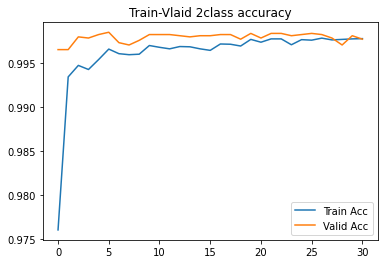

epoch 31 loss: 0.0046: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:50<00:00,  8.40it/s]


train 2class accuracy = 0.99777
[[17210    28]
 [   49 17189]]


epoch 31 loss: 0.0189: 100%|█████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 13.06it/s]


validation 2class accuracy = 0.99697
[[3271   12]
 [  11 4299]]


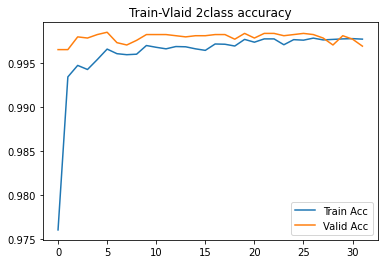

epoch 32 loss: 0.0029: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:49<00:00,  8.41it/s]


train 2class accuracy = 0.99794
[[17211    27]
 [   44 17194]]


epoch 32 loss: 0.0168: 100%|█████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 13.02it/s]

validation 2class accuracy = 0.99789
[[3277    6]
 [  10 4300]]


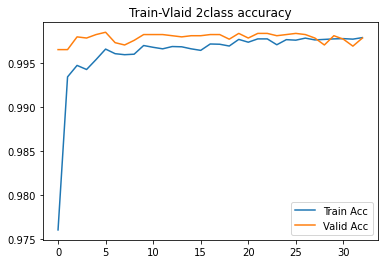

epoch 33 loss: 0.0111: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:50<00:00,  8.40it/s]


train 2class accuracy = 0.99785
[[17210    28]
 [   46 17192]]


epoch 33 loss: 0.0171: 100%|█████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 13.01it/s]

validation 2class accuracy = 0.99750
[[3274    9]
 [  10 4300]]


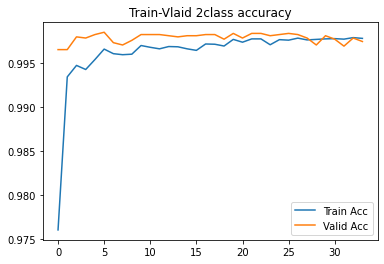

epoch 34 loss: 0.0023: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:49<00:00,  8.42it/s]


train 2class accuracy = 0.99794
[[17208    30]
 [   41 17197]]


epoch 34 loss: 0.0180: 100%|█████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 13.04it/s]


validation 2class accuracy = 0.99763
[[3275    8]
 [  10 4300]]


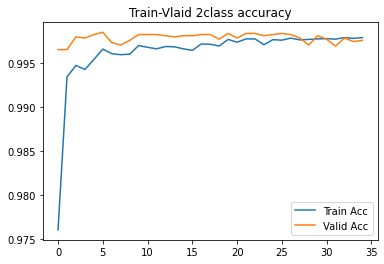

epoch 35 loss: 0.0078: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:49<00:00,  8.42it/s]


train 2class accuracy = 0.99811
[[17214    24]
 [   41 17197]]


epoch 35 loss: 0.0161: 100%|█████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 13.03it/s]

validation 2class accuracy = 0.99802
[[3277    6]
 [   9 4301]]


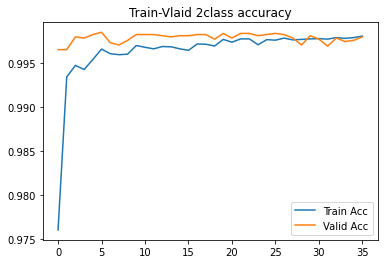

epoch 36 loss: 0.0053: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:49<00:00,  8.41it/s]


train 2class accuracy = 0.99777
[[17209    29]
 [   48 17190]]


epoch 36 loss: 0.0189: 100%|█████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 13.03it/s]

validation 2class accuracy = 0.99684
[[3271   12]
 [  12 4298]]


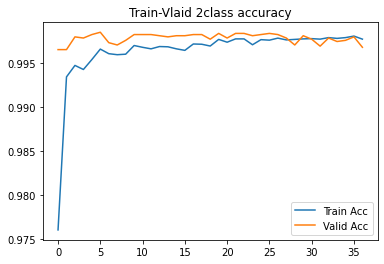

epoch 37 loss: 0.0087: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:49<00:00,  8.42it/s]


train 2class accuracy = 0.99806
[[17216    22]
 [   45 17193]]


epoch 37 loss: 0.0168: 100%|█████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 13.03it/s]


validation 2class accuracy = 0.99816
[[3275    8]
 [   6 4304]]


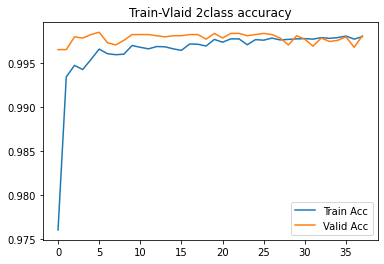

epoch 38 loss: 0.0088: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:44<00:00,  8.52it/s]


train 2class accuracy = 0.99835
[[17220    18]
 [   39 17199]]


epoch 38 loss: 0.0227: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.39it/s]

validation 2class accuracy = 0.99605
[[3262   21]
 [   9 4301]]


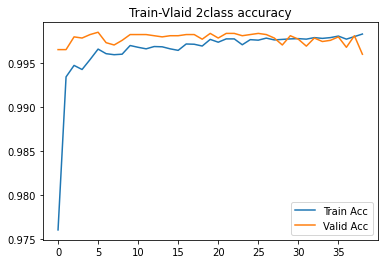

epoch 39 loss: 0.0036: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:42<00:00,  8.57it/s]


train 2class accuracy = 0.99777
[[17207    31]
 [   46 17192]]


epoch 39 loss: 0.0205: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.40it/s]

validation 2class accuracy = 0.99723
[[3276    7]
 [  14 4296]]


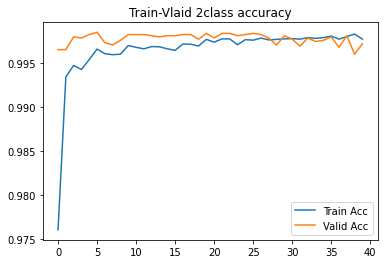

epoch 40 loss: 0.0081: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:42<00:00,  8.57it/s]


train 2class accuracy = 0.99814
[[17217    21]
 [   43 17195]]


epoch 40 loss: 0.0234: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.40it/s]


validation 2class accuracy = 0.99618
[[3272   11]
 [  18 4292]]


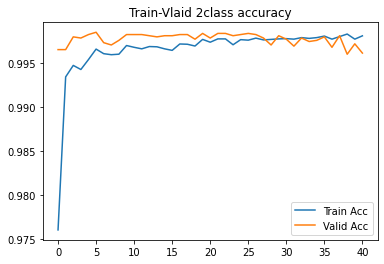

epoch 41 loss: 0.0117: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:42<00:00,  8.57it/s]


train 2class accuracy = 0.99806
[[17215    23]
 [   44 17194]]


epoch 41 loss: 0.0232: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.41it/s]


validation 2class accuracy = 0.99697
[[3274    9]
 [  14 4296]]


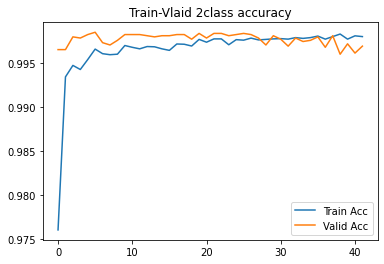

epoch 42 loss: 0.0098: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:42<00:00,  8.57it/s]


train 2class accuracy = 0.99832
[[17220    18]
 [   40 17198]]


epoch 42 loss: 0.0176: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.42it/s]

validation 2class accuracy = 0.99750
[[3271   12]
 [   7 4303]]


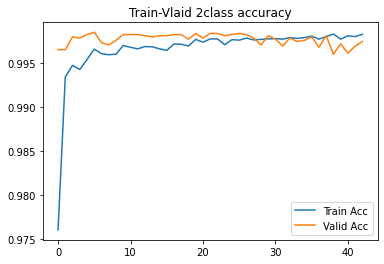

epoch 43 loss: 0.0127: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:43<00:00,  8.54it/s]


train 2class accuracy = 0.99840
[[17216    22]
 [   33 17205]]


epoch 43 loss: 0.0151: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.34it/s]

validation 2class accuracy = 0.99842
[[3278    5]
 [   7 4303]]


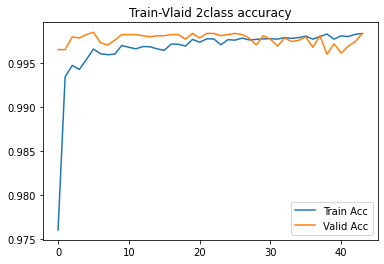

epoch 44 loss: 0.0058: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:44<00:00,  8.53it/s]


train 2class accuracy = 0.99832
[[17215    23]
 [   35 17203]]


epoch 44 loss: 0.0255: 100%|█████████████████████████████████████████████████████████| 760/760 [00:57<00:00, 13.33it/s]

validation 2class accuracy = 0.99631
[[3278    5]
 [  23 4287]]


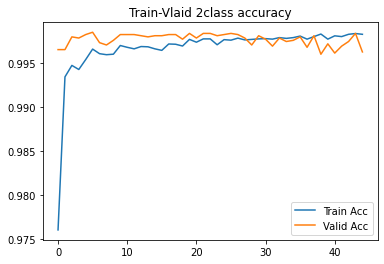

epoch 45 loss: 0.0035: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:45<00:00,  8.51it/s]


train 2class accuracy = 0.99864
[[17223    15]
 [   32 17206]]


epoch 45 loss: 0.0165: 100%|█████████████████████████████████████████████████████████| 760/760 [00:57<00:00, 13.29it/s]

validation 2class accuracy = 0.99776
[[3272   11]
 [   6 4304]]


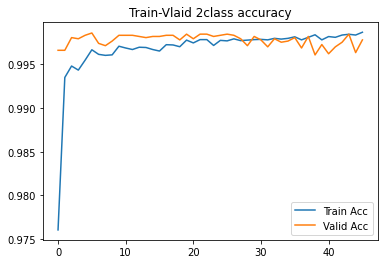

epoch 46 loss: 0.0023: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:43<00:00,  8.54it/s]


train 2class accuracy = 0.99811
[[17209    29]
 [   36 17202]]


epoch 46 loss: 0.0164: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.40it/s]

validation 2class accuracy = 0.99829
[[3278    5]
 [   8 4302]]


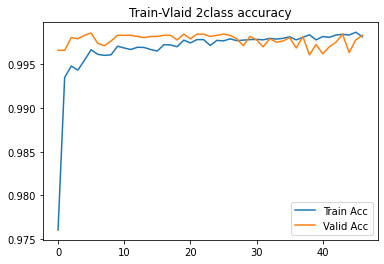

epoch 47 loss: 0.0046: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:42<00:00,  8.57it/s]


train 2class accuracy = 0.99817
[[17213    25]
 [   38 17200]]


epoch 47 loss: 0.0150: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.40it/s]


validation 2class accuracy = 0.99776
[[3277    6]
 [  11 4299]]


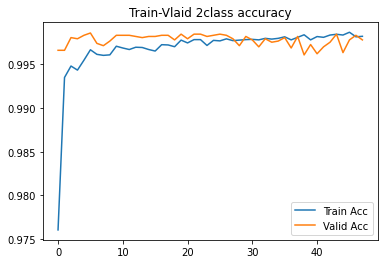

epoch 48 loss: 0.0078: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:42<00:00,  8.57it/s]


train 2class accuracy = 0.99840
[[17216    22]
 [   33 17205]]


epoch 48 loss: 0.0160: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.39it/s]


validation 2class accuracy = 0.99802
[[3276    7]
 [   8 4302]]


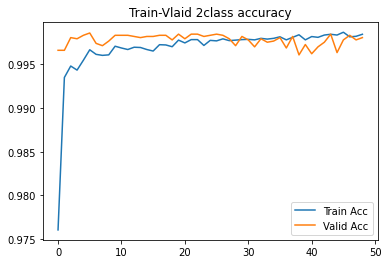

epoch 49 loss: 0.0094: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:42<00:00,  8.57it/s]


train 2class accuracy = 0.99843
[[17217    21]
 [   33 17205]]


epoch 49 loss: 0.0188: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.40it/s]


validation 2class accuracy = 0.99737
[[3275    8]
 [  12 4298]]


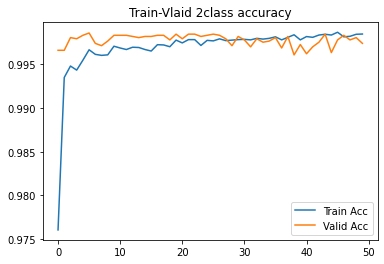

epoch 50 loss: 0.0043: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:42<00:00,  8.56it/s]


train 2class accuracy = 0.99846
[[17216    22]
 [   31 17207]]


epoch 50 loss: 0.0187: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.36it/s]


validation 2class accuracy = 0.99789
[[3276    7]
 [   9 4301]]


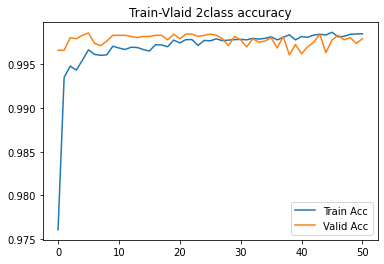

epoch 51 loss: 0.0056: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:42<00:00,  8.56it/s]


train 2class accuracy = 0.99829
[[17214    24]
 [   35 17203]]


epoch 51 loss: 0.0182: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.41it/s]

validation 2class accuracy = 0.99802
[[3278    5]
 [  10 4300]]


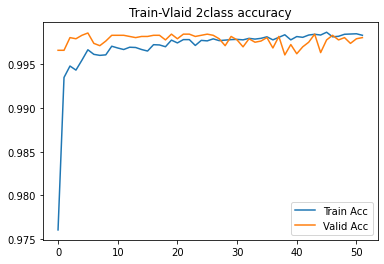

epoch 52 loss: 0.0041: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:42<00:00,  8.56it/s]


train 2class accuracy = 0.99858
[[17222    16]
 [   33 17205]]


epoch 52 loss: 0.0162: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.37it/s]


validation 2class accuracy = 0.99816
[[3277    6]
 [   8 4302]]


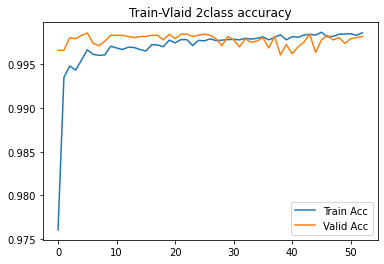

epoch 53 loss: 0.0107: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:43<00:00,  8.54it/s]


train 2class accuracy = 0.99820
[[17213    25]
 [   37 17201]]


epoch 53 loss: 0.0185: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.34it/s]


validation 2class accuracy = 0.99763
[[3275    8]
 [  10 4300]]


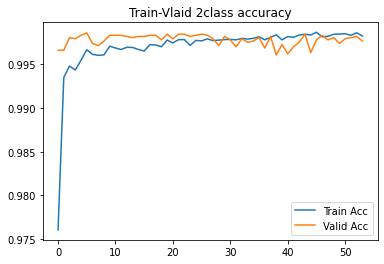

epoch 54 loss: 0.0122: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:47<00:00,  8.46it/s]


train 2class accuracy = 0.99838
[[17218    20]
 [   36 17202]]


epoch 54 loss: 0.0170: 100%|█████████████████████████████████████████████████████████| 760/760 [00:57<00:00, 13.23it/s]

validation 2class accuracy = 0.99723
[[3273   10]
 [  11 4299]]


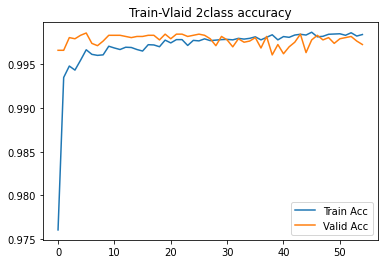

epoch 55 loss: 0.0009: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:48<00:00,  8.44it/s]


train 2class accuracy = 0.99887
[[17224    14]
 [   25 17213]]


epoch 55 loss: 0.0198: 100%|█████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 13.08it/s]

validation 2class accuracy = 0.99750
[[3275    8]
 [  11 4299]]


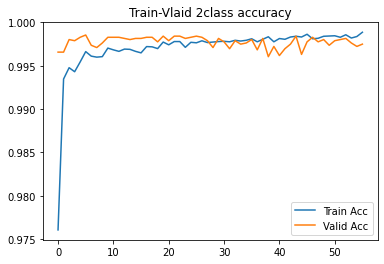

epoch 56 loss: 0.0067: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:49<00:00,  8.42it/s]


train 2class accuracy = 0.99849
[[17220    18]
 [   34 17204]]


epoch 56 loss: 0.0221: 100%|█████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 13.06it/s]


validation 2class accuracy = 0.99539
[[3259   24]
 [  11 4299]]


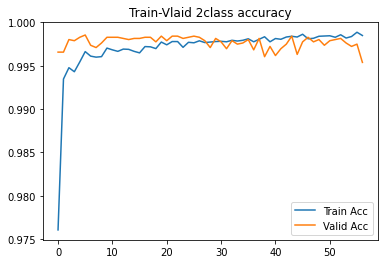

epoch 57 loss: 0.0039: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:49<00:00,  8.42it/s]


train 2class accuracy = 0.99855
[[17215    23]
 [   27 17211]]


epoch 57 loss: 0.0208: 100%|█████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 13.03it/s]

validation 2class accuracy = 0.99697
[[3275    8]
 [  15 4295]]


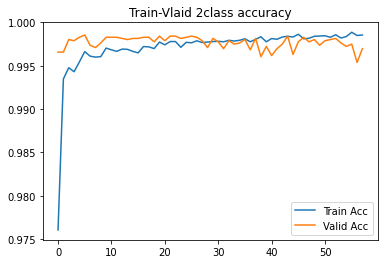

epoch 58 loss: 0.0069: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:49<00:00,  8.41it/s]


train 2class accuracy = 0.99823
[[17214    24]
 [   37 17201]]


epoch 58 loss: 0.0180: 100%|█████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 13.00it/s]


validation 2class accuracy = 0.99710
[[3272   11]
 [  11 4299]]


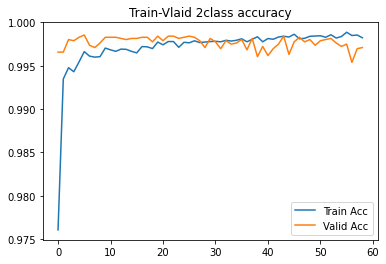

epoch 59 loss: 0.0039: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:50<00:00,  8.40it/s]


train 2class accuracy = 0.99864
[[17219    19]
 [   28 17210]]


epoch 59 loss: 0.0210: 100%|█████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 13.03it/s]


validation 2class accuracy = 0.99829
[[3278    5]
 [   8 4302]]


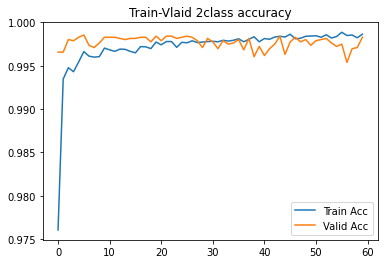

epoch 60 loss: 0.0026: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:49<00:00,  8.41it/s]


train 2class accuracy = 0.99872
[[17223    15]
 [   29 17209]]


epoch 60 loss: 0.0205: 100%|█████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 13.05it/s]

validation 2class accuracy = 0.99750
[[3274    9]
 [  10 4300]]


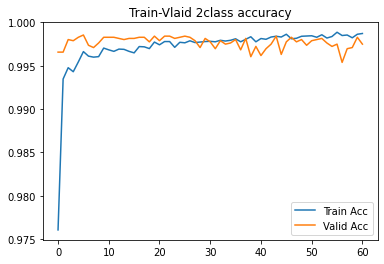

epoch 61 loss: 0.0041: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:49<00:00,  8.41it/s]


train 2class accuracy = 0.99858
[[17219    19]
 [   30 17208]]


epoch 61 loss: 0.0213: 100%|█████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 13.05it/s]


validation 2class accuracy = 0.99750
[[3274    9]
 [  10 4300]]


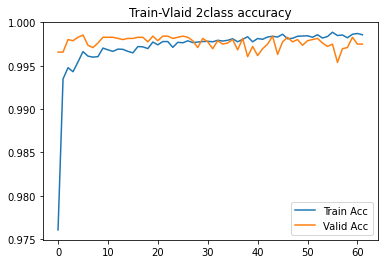

epoch 62 loss: 0.0066: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:43<00:00,  8.54it/s]


train 2class accuracy = 0.99832
[[17219    19]
 [   39 17199]]


epoch 62 loss: 0.0208: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.40it/s]


validation 2class accuracy = 0.99671
[[3271   12]
 [  13 4297]]


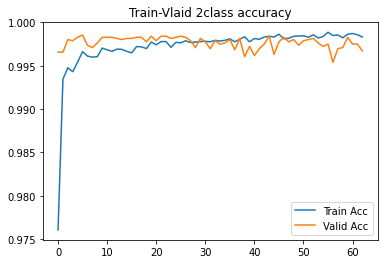

epoch 63 loss: 0.0058: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:41<00:00,  8.58it/s]


train 2class accuracy = 0.99855
[[17216    22]
 [   28 17210]]


epoch 63 loss: 0.0297: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.40it/s]


validation 2class accuracy = 0.99486
[[3276    7]
 [  32 4278]]


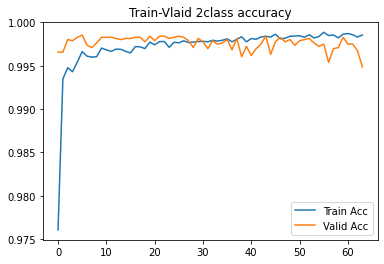

epoch 64 loss: 0.0019: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:42<00:00,  8.57it/s]


train 2class accuracy = 0.99858
[[17217    21]
 [   28 17210]]


epoch 64 loss: 0.0219: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.40it/s]


validation 2class accuracy = 0.99776
[[3276    7]
 [  10 4300]]


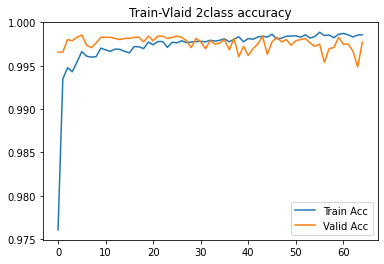

epoch 65 loss: 0.0053: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:42<00:00,  8.57it/s]


train 2class accuracy = 0.99829
[[17216    22]
 [   37 17201]]


epoch 65 loss: 0.0195: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.41it/s]


validation 2class accuracy = 0.99829
[[3277    6]
 [   7 4303]]


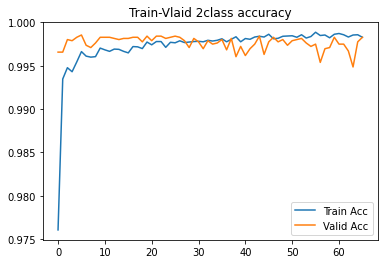

epoch 66 loss: 0.0056: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:42<00:00,  8.57it/s]


train 2class accuracy = 0.99893
[[17225    13]
 [   24 17214]]


epoch 66 loss: 0.0207: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.39it/s]


validation 2class accuracy = 0.99723
[[3269   14]
 [   7 4303]]


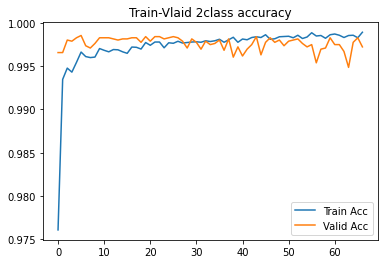

epoch 67 loss: 0.0034: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:42<00:00,  8.56it/s]


train 2class accuracy = 0.99864
[[17218    20]
 [   27 17211]]


epoch 67 loss: 0.0206: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.38it/s]


validation 2class accuracy = 0.99802
[[3277    6]
 [   9 4301]]


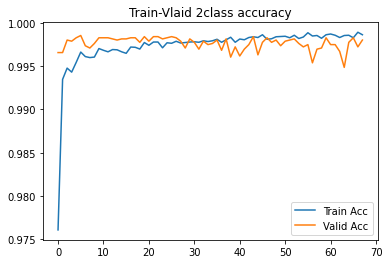

epoch 68 loss: 0.0064: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:42<00:00,  8.57it/s]


train 2class accuracy = 0.99867
[[17220    18]
 [   28 17210]]


epoch 68 loss: 0.0234: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.39it/s]


validation 2class accuracy = 0.99565
[[3275    8]
 [  25 4285]]


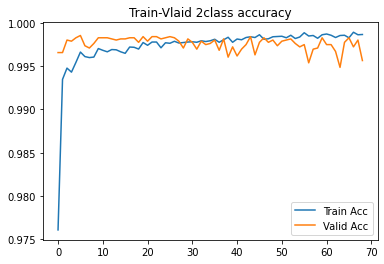

epoch 69 loss: 0.0034: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:42<00:00,  8.57it/s]


train 2class accuracy = 0.99890
[[17226    12]
 [   26 17212]]


epoch 69 loss: 0.0260: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.38it/s]


validation 2class accuracy = 0.99460
[[3250   33]
 [   8 4302]]


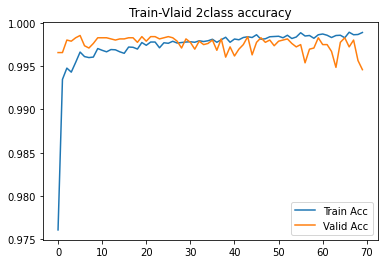

epoch 70 loss: 0.0101: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:42<00:00,  8.56it/s]


train 2class accuracy = 0.99852
[[17216    22]
 [   29 17209]]


epoch 70 loss: 0.0225: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.40it/s]


validation 2class accuracy = 0.99723
[[3270   13]
 [   8 4302]]


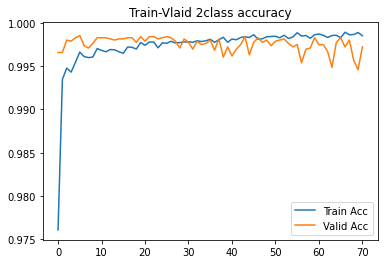

epoch 71 loss: 0.0027: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:42<00:00,  8.57it/s]


train 2class accuracy = 0.99875
[[17220    18]
 [   25 17213]]


epoch 71 loss: 0.0236: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.41it/s]


validation 2class accuracy = 0.99723
[[3277    6]
 [  15 4295]]


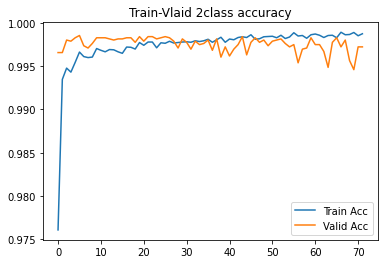

epoch 72 loss: 0.0104: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:42<00:00,  8.57it/s]


train 2class accuracy = 0.99875
[[17217    21]
 [   22 17216]]


epoch 72 loss: 0.0220: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.39it/s]

validation 2class accuracy = 0.99671
[[3272   11]
 [  14 4296]]


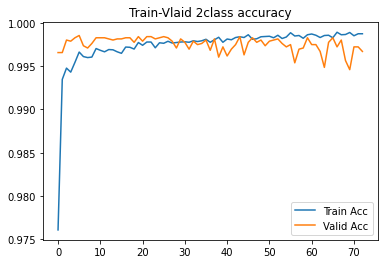

epoch 73 loss: 0.0029: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:42<00:00,  8.57it/s]


train 2class accuracy = 0.99887
[[17222    16]
 [   23 17215]]


epoch 73 loss: 0.0210: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.39it/s]


validation 2class accuracy = 0.99737
[[3275    8]
 [  12 4298]]


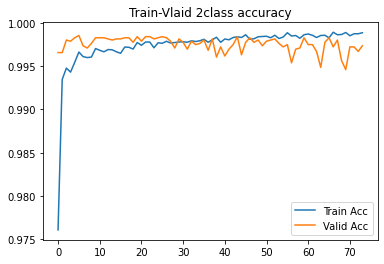

epoch 74 loss: 0.0095: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:42<00:00,  8.57it/s]


train 2class accuracy = 0.99869
[[17219    19]
 [   26 17212]]


epoch 74 loss: 0.0211: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.39it/s]


validation 2class accuracy = 0.99710
[[3270   13]
 [   9 4301]]


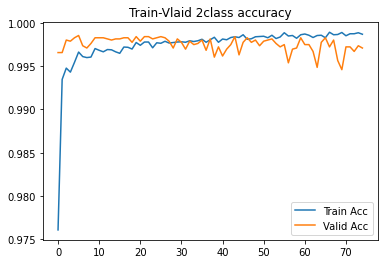

epoch 75 loss: 0.0032: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:41<00:00,  8.58it/s]


train 2class accuracy = 0.99881
[[17220    18]
 [   23 17215]]


epoch 75 loss: 0.0214: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.43it/s]


validation 2class accuracy = 0.99776
[[3274    9]
 [   8 4302]]


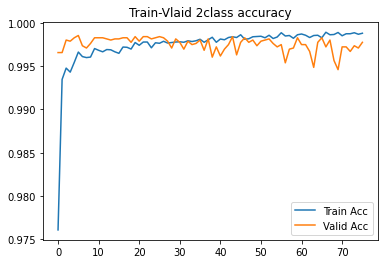

epoch 76 loss: 0.0036: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:41<00:00,  8.58it/s]


train 2class accuracy = 0.99849
[[17214    24]
 [   28 17210]]


epoch 76 loss: 0.0323: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.40it/s]

validation 2class accuracy = 0.99539
[[3276    7]
 [  28 4282]]


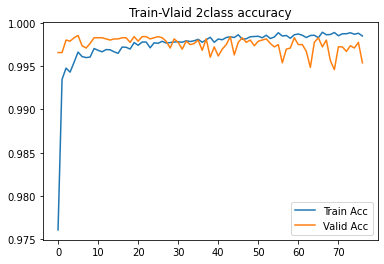

epoch 77 loss: 0.0054: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:43<00:00,  8.55it/s]


train 2class accuracy = 0.99890
[[17223    15]
 [   23 17215]]


epoch 77 loss: 0.0214: 100%|█████████████████████████████████████████████████████████| 760/760 [00:57<00:00, 13.32it/s]


validation 2class accuracy = 0.99710
[[3273   10]
 [  12 4298]]


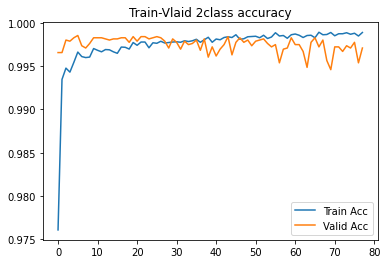

epoch 78 loss: 0.0044: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:43<00:00,  8.54it/s]


train 2class accuracy = 0.99872
[[17222    16]
 [   28 17210]]


epoch 78 loss: 0.0214: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.41it/s]


validation 2class accuracy = 0.99710
[[3270   13]
 [   9 4301]]


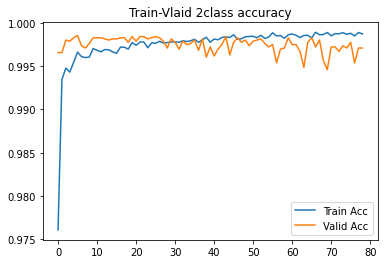

epoch 79 loss: 0.0023: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:42<00:00,  8.57it/s]


train 2class accuracy = 0.99878
[[17220    18]
 [   24 17214]]


epoch 79 loss: 0.0238: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.40it/s]


validation 2class accuracy = 0.99697
[[3267   16]
 [   7 4303]]


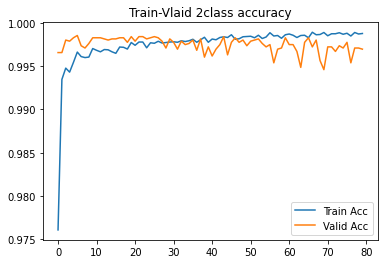

epoch 80 loss: 0.0145: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:42<00:00,  8.57it/s]


train 2class accuracy = 0.99890
[[17225    13]
 [   25 17213]]


epoch 80 loss: 0.0204: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.40it/s]

validation 2class accuracy = 0.99737
[[3271   12]
 [   8 4302]]


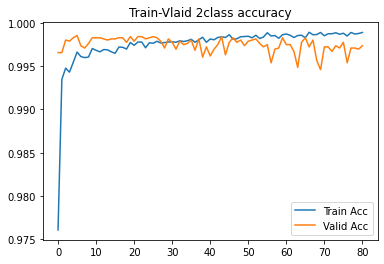

epoch 81 loss: 0.0057: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:43<00:00,  8.55it/s]


train 2class accuracy = 0.99898
[[17223    15]
 [   20 17218]]


epoch 81 loss: 0.0201: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.39it/s]


validation 2class accuracy = 0.99789
[[3275    8]
 [   8 4302]]


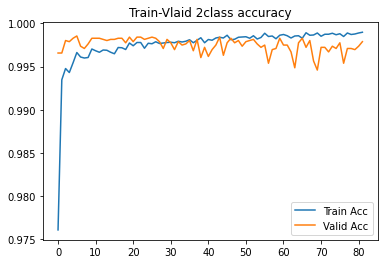

epoch 82 loss: 0.0068: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:42<00:00,  8.56it/s]


train 2class accuracy = 0.99864
[[17220    18]
 [   29 17209]]


epoch 82 loss: 0.0285: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.39it/s]


validation 2class accuracy = 0.99552
[[3272   11]
 [  23 4287]]


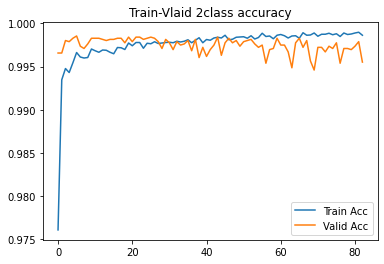

epoch 83 loss: 0.0044: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:42<00:00,  8.56it/s]


train 2class accuracy = 0.99901
[[17226    12]
 [   22 17216]]


epoch 83 loss: 0.0220: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.39it/s]


validation 2class accuracy = 0.99776
[[3275    8]
 [   9 4301]]


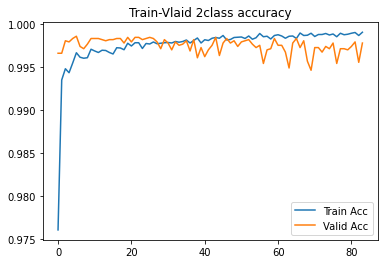

epoch 84 loss: 0.0015: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:43<00:00,  8.55it/s]


train 2class accuracy = 0.99913
[[17224    14]
 [   16 17222]]


epoch 84 loss: 0.0218: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.38it/s]

validation 2class accuracy = 0.99776
[[3274    9]
 [   8 4302]]


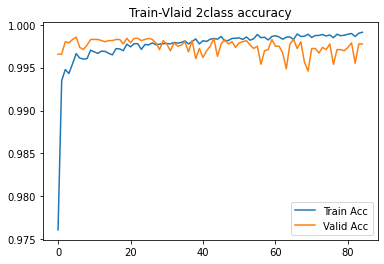

epoch 85 loss: 0.0151: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:47<00:00,  8.47it/s]


train 2class accuracy = 0.99887
[[17222    16]
 [   23 17215]]


epoch 85 loss: 0.0221: 100%|█████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 13.09it/s]


validation 2class accuracy = 0.99697
[[3272   11]
 [  12 4298]]


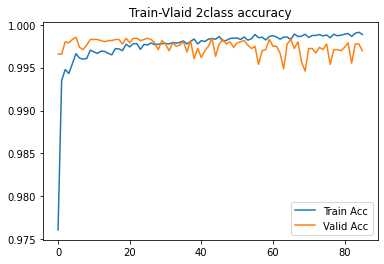

epoch 86 loss: 0.0086: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:43<00:00,  8.54it/s]


train 2class accuracy = 0.99864
[[17218    20]
 [   27 17211]]


epoch 86 loss: 0.0220: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.40it/s]


validation 2class accuracy = 0.99697
[[3270   13]
 [  10 4300]]


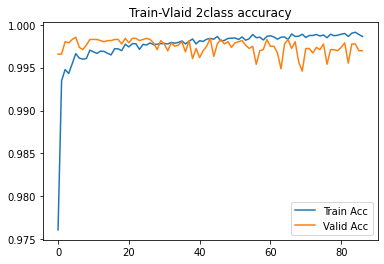

epoch 87 loss: 0.0051: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:42<00:00,  8.57it/s]


train 2class accuracy = 0.99907
[[17227    11]
 [   21 17217]]


epoch 87 loss: 0.0220: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.40it/s]

validation 2class accuracy = 0.99763
[[3274    9]
 [   9 4301]]


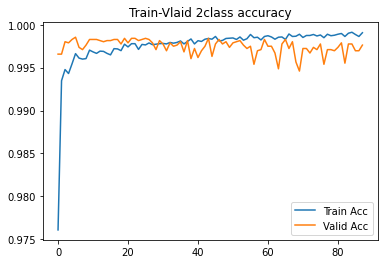

epoch 88 loss: 0.0073: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:42<00:00,  8.56it/s]


train 2class accuracy = 0.99878
[[17222    16]
 [   26 17212]]


epoch 88 loss: 0.0201: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.38it/s]


validation 2class accuracy = 0.99816
[[3277    6]
 [   8 4302]]


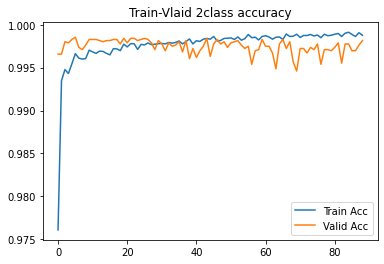

epoch 89 loss: 0.0041: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:42<00:00,  8.56it/s]


train 2class accuracy = 0.99893
[[17223    15]
 [   22 17216]]


epoch 89 loss: 0.0235: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.37it/s]

validation 2class accuracy = 0.99710
[[3275    8]
 [  14 4296]]


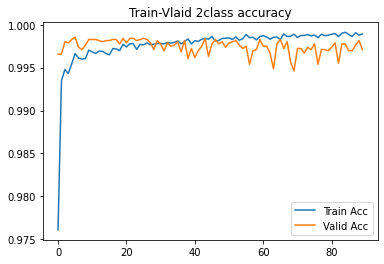

epoch 90 loss: 0.0049: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:43<00:00,  8.55it/s]


train 2class accuracy = 0.99890
[[17223    15]
 [   23 17215]]


epoch 90 loss: 0.0215: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.39it/s]

validation 2class accuracy = 0.99776
[[3274    9]
 [   8 4302]]


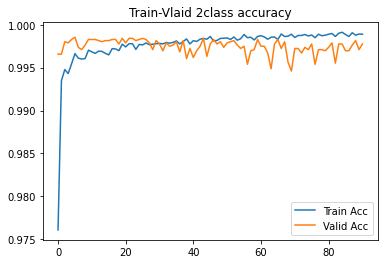

epoch 91 loss: 0.0063: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:42<00:00,  8.56it/s]


train 2class accuracy = 0.99878
[[17220    18]
 [   24 17214]]


epoch 91 loss: 0.0191: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.39it/s]


validation 2class accuracy = 0.99763
[[3276    7]
 [  11 4299]]


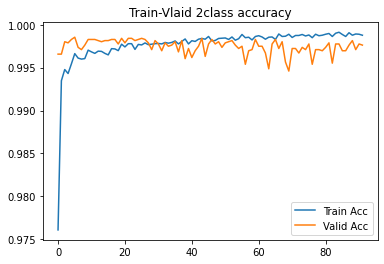

epoch 92 loss: 0.0067: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:42<00:00,  8.57it/s]


train 2class accuracy = 0.99893
[[17223    15]
 [   22 17216]]


epoch 92 loss: 0.0228: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.38it/s]


validation 2class accuracy = 0.99710
[[3276    7]
 [  15 4295]]


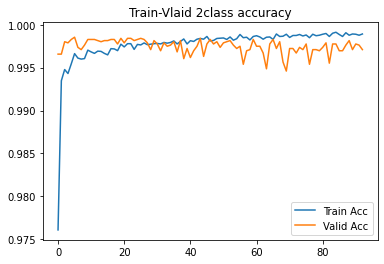

epoch 93 loss: 0.0044: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:42<00:00,  8.57it/s]


train 2class accuracy = 0.99884
[[17222    16]
 [   24 17214]]


epoch 93 loss: 0.0194: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.38it/s]

validation 2class accuracy = 0.99737
[[3272   11]
 [   9 4301]]


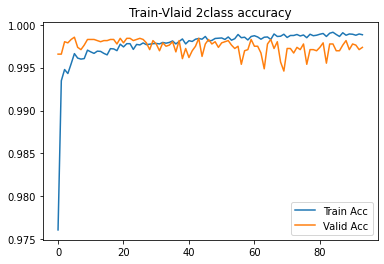

epoch 94 loss: 0.0034: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:44<00:00,  8.53it/s]


train 2class accuracy = 0.99904
[[17224    14]
 [   19 17219]]


epoch 94 loss: 0.0208: 100%|█████████████████████████████████████████████████████████| 760/760 [00:57<00:00, 13.30it/s]


validation 2class accuracy = 0.99671
[[3268   15]
 [  10 4300]]


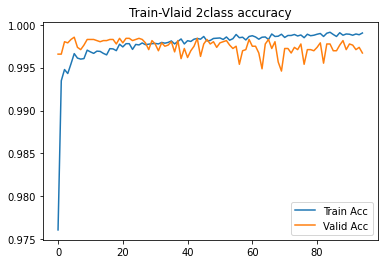

epoch 95 loss: 0.0045: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:44<00:00,  8.52it/s]


train 2class accuracy = 0.99881
[[17219    19]
 [   22 17216]]


epoch 95 loss: 0.0264: 100%|█████████████████████████████████████████████████████████| 760/760 [00:57<00:00, 13.30it/s]


validation 2class accuracy = 0.99592
[[3277    6]
 [  25 4285]]


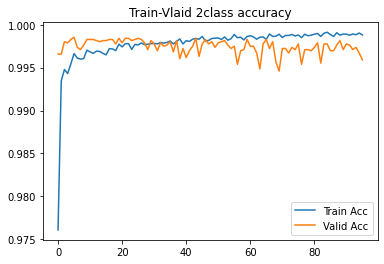

epoch 96 loss: 0.0020: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:44<00:00,  8.51it/s]


train 2class accuracy = 0.99887
[[17223    15]
 [   24 17214]]


epoch 96 loss: 0.0203: 100%|█████████████████████████████████████████████████████████| 760/760 [00:57<00:00, 13.30it/s]


validation 2class accuracy = 0.99723
[[3271   12]
 [   9 4301]]


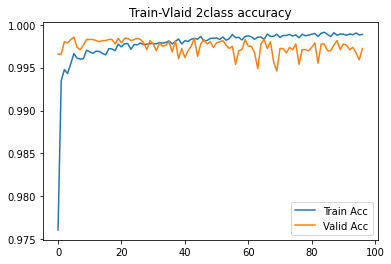

epoch 97 loss: 0.0048: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:45<00:00,  8.51it/s]


train 2class accuracy = 0.99893
[[17222    16]
 [   21 17217]]


epoch 97 loss: 0.0206: 100%|█████████████████████████████████████████████████████████| 760/760 [00:57<00:00, 13.25it/s]


validation 2class accuracy = 0.99750
[[3273   10]
 [   9 4301]]


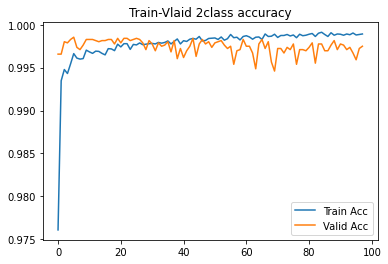

epoch 98 loss: 0.0014: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:46<00:00,  8.48it/s]


train 2class accuracy = 0.99930
[[17228    10]
 [   14 17224]]


epoch 98 loss: 0.0296: 100%|█████████████████████████████████████████████████████████| 760/760 [00:57<00:00, 13.20it/s]

validation 2class accuracy = 0.99565
[[3260   23]
 [  10 4300]]


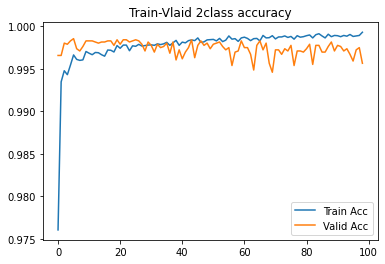

epoch 99 loss: 0.0029: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:48<00:00,  8.44it/s]


train 2class accuracy = 0.99887
[[17217    21]
 [   18 17220]]


epoch 99 loss: 0.0215: 100%|█████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 13.05it/s]


validation 2class accuracy = 0.99816
[[3279    4]
 [  10 4300]]


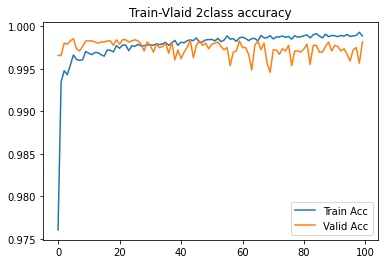

time : 12:54:50
Best Epoch : 5
Best Train Accuracy : 0.99664
[[17182    56]
 [   60 17178]]
Best Valid Accuracy : 0.99855
[[3279    4]
 [   7 4303]]
Training with 3 started
30371 7593


epoch 0 loss: 0.0366: 100%|████████████████████████████████████████████████████████| 3448/3448 [06:50<00:00,  8.41it/s]


train 2class accuracy = 0.97830
[[16879   359]
 [  389 16849]]


epoch 0 loss: 0.0228: 100%|██████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 13.01it/s]

validation 2class accuracy = 0.99710
[[3272   11]
 [  11 4299]]


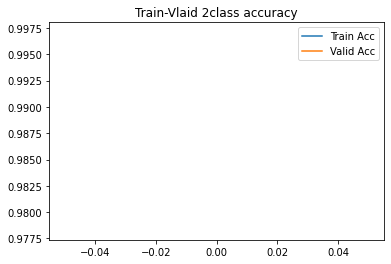

epoch 1 loss: 0.0263: 100%|████████████████████████████████████████████████████████| 3448/3448 [06:50<00:00,  8.40it/s]


train 2class accuracy = 0.99289
[[17130   108]
 [  137 17101]]


epoch 1 loss: 0.0223: 100%|██████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 13.00it/s]

validation 2class accuracy = 0.99750
[[3274    9]
 [  10 4300]]


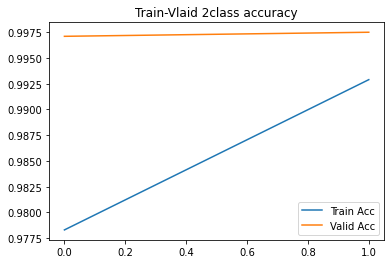

epoch 2 loss: 0.0235: 100%|████████████████████████████████████████████████████████| 3448/3448 [06:43<00:00,  8.55it/s]


train 2class accuracy = 0.99495
[[17163    75]
 [   99 17139]]


epoch 2 loss: 0.0242: 100%|██████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.37it/s]


validation 2class accuracy = 0.99776
[[3274    9]
 [   8 4302]]


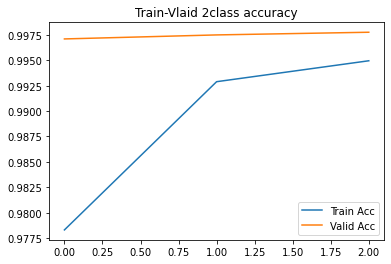

epoch 3 loss: 0.0177: 100%|████████████████████████████████████████████████████████| 3448/3448 [06:42<00:00,  8.57it/s]


train 2class accuracy = 0.99524
[[17155    83]
 [   81 17157]]


epoch 3 loss: 0.0187: 100%|██████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.38it/s]


validation 2class accuracy = 0.99789
[[3275    8]
 [   8 4302]]


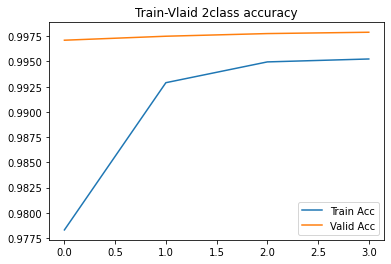

epoch 4 loss: 0.0225: 100%|████████████████████████████████████████████████████████| 3448/3448 [06:42<00:00,  8.56it/s]


train 2class accuracy = 0.99608
[[17181    57]
 [   78 17160]]


epoch 4 loss: 0.0189: 100%|██████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.40it/s]


validation 2class accuracy = 0.99776
[[3273   10]
 [   7 4303]]


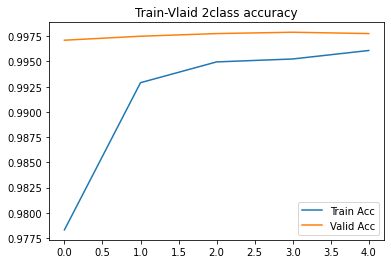

epoch 5 loss: 0.0092: 100%|████████████████████████████████████████████████████████| 3448/3448 [06:43<00:00,  8.55it/s]


train 2class accuracy = 0.99626
[[17181    57]
 [   72 17166]]


epoch 5 loss: 0.0168: 100%|██████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.37it/s]


validation 2class accuracy = 0.99802
[[3276    7]
 [   8 4302]]


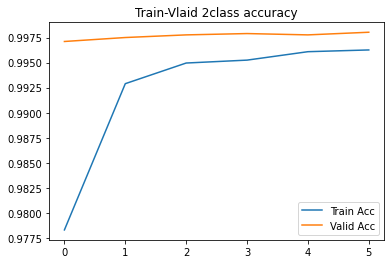

epoch 6 loss: 0.0185: 100%|████████████████████████████████████████████████████████| 3448/3448 [06:43<00:00,  8.53it/s]


train 2class accuracy = 0.99577
[[17167    71]
 [   75 17163]]


epoch 6 loss: 0.0175: 100%|██████████████████████████████████████████████████████████| 760/760 [00:57<00:00, 13.30it/s]


validation 2class accuracy = 0.99763
[[3274    9]
 [   9 4301]]


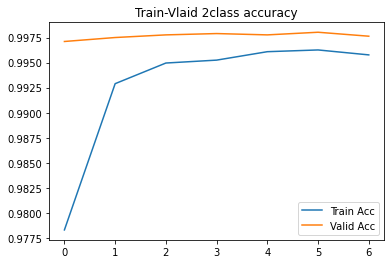

epoch 7 loss: 0.0100: 100%|████████████████████████████████████████████████████████| 3448/3448 [06:48<00:00,  8.44it/s]


train 2class accuracy = 0.99664
[[17187    51]
 [   65 17173]]


epoch 7 loss: 0.0200: 100%|██████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 13.06it/s]


validation 2class accuracy = 0.99658
[[3276    7]
 [  19 4291]]


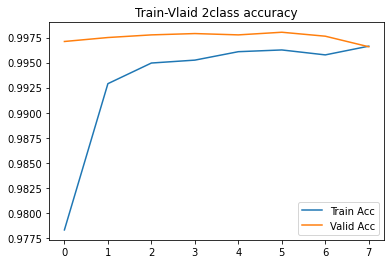

epoch 8 loss: 0.0139: 100%|████████████████████████████████████████████████████████| 3448/3448 [06:50<00:00,  8.41it/s]


train 2class accuracy = 0.99608
[[17180    58]
 [   77 17161]]


epoch 8 loss: 0.0227: 100%|██████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 13.04it/s]


validation 2class accuracy = 0.99789
[[3276    7]
 [   9 4301]]


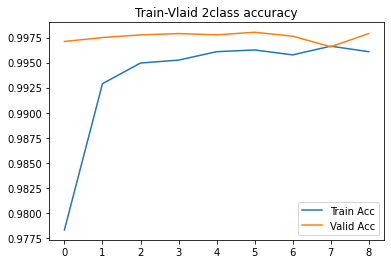

epoch 9 loss: 0.0084: 100%|████████████████████████████████████████████████████████| 3448/3448 [06:50<00:00,  8.41it/s]


train 2class accuracy = 0.99646
[[17188    50]
 [   72 17166]]


epoch 9 loss: 0.0188: 100%|██████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 13.01it/s]


validation 2class accuracy = 0.99763
[[3273   10]
 [   8 4302]]


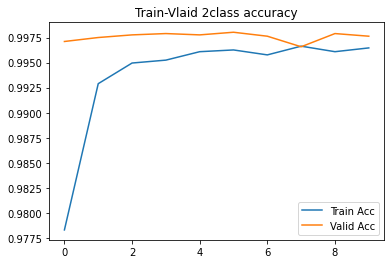

epoch 10 loss: 0.0110: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:49<00:00,  8.41it/s]


train 2class accuracy = 0.99710
[[17198    40]
 [   60 17178]]


epoch 10 loss: 0.0181: 100%|█████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 13.01it/s]


validation 2class accuracy = 0.99776
[[3274    9]
 [   8 4302]]


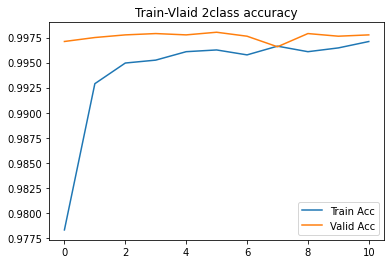

epoch 11 loss: 0.0221: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:49<00:00,  8.41it/s]


train 2class accuracy = 0.99678
[[17193    45]
 [   66 17172]]


epoch 11 loss: 0.0167: 100%|█████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 13.05it/s]


validation 2class accuracy = 0.99776
[[3274    9]
 [   8 4302]]


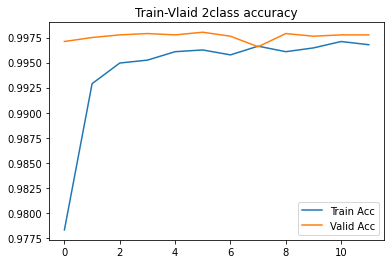

epoch 12 loss: 0.0075: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:48<00:00,  8.44it/s]


train 2class accuracy = 0.99753
[[17198    40]
 [   45 17193]]


epoch 12 loss: 0.0209: 100%|█████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 13.00it/s]


validation 2class accuracy = 0.99750
[[3274    9]
 [  10 4300]]


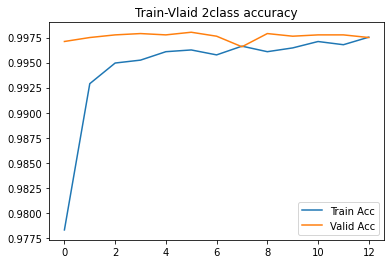

epoch 13 loss: 0.0159: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:49<00:00,  8.42it/s]


train 2class accuracy = 0.99652
[[17192    46]
 [   74 17164]]


epoch 13 loss: 0.0197: 100%|█████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 13.08it/s]

validation 2class accuracy = 0.99802
[[3275    8]
 [   7 4303]]


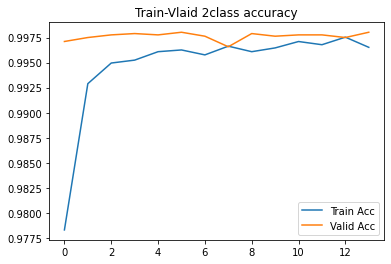

epoch 14 loss: 0.0047: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:49<00:00,  8.42it/s]


train 2class accuracy = 0.99684
[[17189    49]
 [   60 17178]]


epoch 14 loss: 0.0187: 100%|█████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 13.05it/s]


validation 2class accuracy = 0.99802
[[3275    8]
 [   7 4303]]


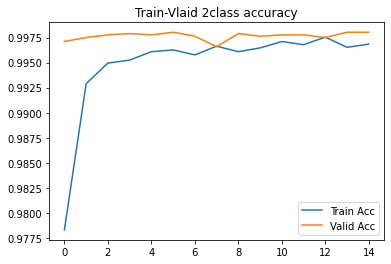

epoch 15 loss: 0.0164: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:49<00:00,  8.42it/s]


train 2class accuracy = 0.99765
[[17204    34]
 [   47 17191]]


epoch 15 loss: 0.0173: 100%|█████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 13.04it/s]


validation 2class accuracy = 0.99789
[[3275    8]
 [   8 4302]]


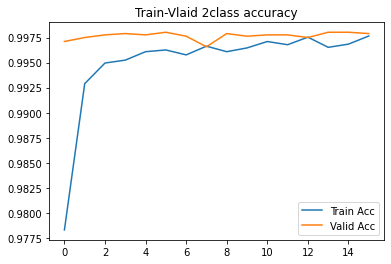

epoch 16 loss: 0.0049: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:49<00:00,  8.42it/s]


train 2class accuracy = 0.99765
[[17205    33]
 [   48 17190]]


epoch 16 loss: 0.0194: 100%|█████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 13.04it/s]


validation 2class accuracy = 0.99802
[[3274    9]
 [   6 4304]]


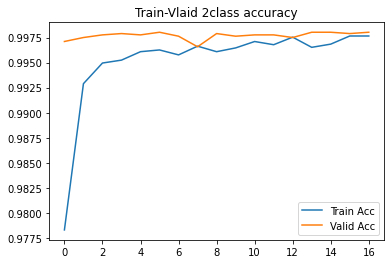

epoch 17 loss: 0.0123: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:49<00:00,  8.41it/s]


train 2class accuracy = 0.99719
[[17201    37]
 [   60 17178]]


epoch 17 loss: 0.0179: 100%|█████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 12.95it/s]


validation 2class accuracy = 0.99802
[[3275    8]
 [   7 4303]]


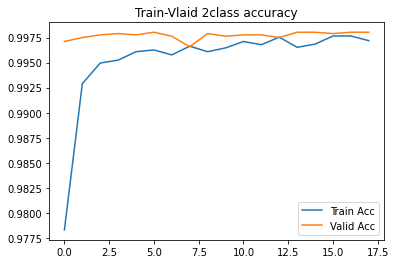

epoch 18 loss: 0.0104: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:50<00:00,  8.41it/s]


train 2class accuracy = 0.99771
[[17208    30]
 [   49 17189]]


epoch 18 loss: 0.0182: 100%|█████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 13.02it/s]


validation 2class accuracy = 0.99776
[[3274    9]
 [   8 4302]]


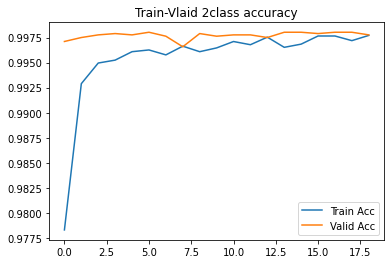

epoch 19 loss: 0.0106: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:50<00:00,  8.41it/s]


train 2class accuracy = 0.99742
[[17205    33]
 [   56 17182]]


epoch 19 loss: 0.0192: 100%|█████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 12.98it/s]


validation 2class accuracy = 0.99737
[[3271   12]
 [   8 4302]]


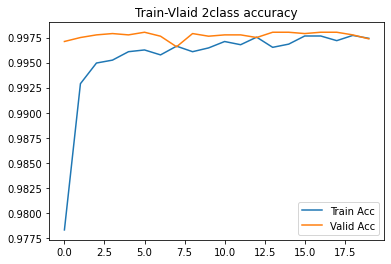

epoch 20 loss: 0.0159: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:51<00:00,  8.38it/s]


train 2class accuracy = 0.99736
[[17203    35]
 [   56 17182]]


epoch 20 loss: 0.0228: 100%|█████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 13.00it/s]


validation 2class accuracy = 0.99763
[[3272   11]
 [   7 4303]]


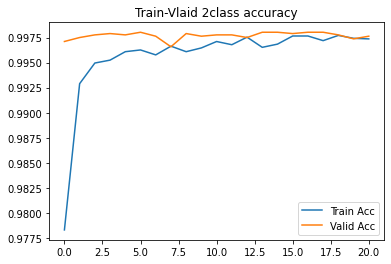

epoch 21 loss: 0.0118: 100%|███████████████████████████████████████████████████████| 3448/3448 [07:37<00:00,  7.53it/s]


train 2class accuracy = 0.99745
[[17204    34]
 [   54 17184]]


epoch 21 loss: 0.0179: 100%|█████████████████████████████████████████████████████████| 760/760 [01:23<00:00,  9.09it/s]


validation 2class accuracy = 0.99710
[[3274    9]
 [  13 4297]]


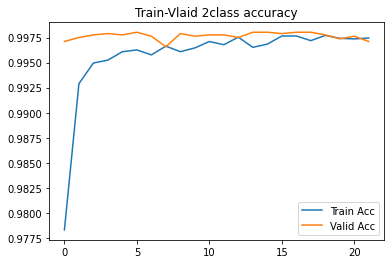

epoch 22 loss: 0.0154: 100%|███████████████████████████████████████████████████████| 3448/3448 [07:02<00:00,  8.15it/s]


train 2class accuracy = 0.99753
[[17205    33]
 [   52 17186]]


epoch 22 loss: 0.0203: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.37it/s]


validation 2class accuracy = 0.99776
[[3274    9]
 [   8 4302]]


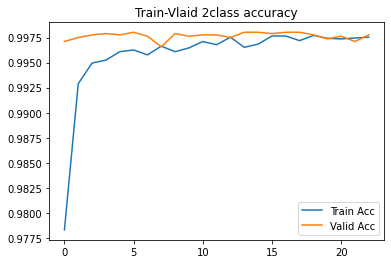

epoch 23 loss: 0.0072: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:46<00:00,  8.48it/s]


train 2class accuracy = 0.99768
[[17206    32]
 [   48 17190]]


epoch 23 loss: 0.0205: 100%|█████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 13.02it/s]


validation 2class accuracy = 0.99763
[[3273   10]
 [   8 4302]]


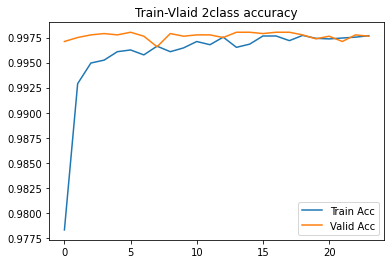

epoch 24 loss: 0.0090: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:51<00:00,  8.39it/s]


train 2class accuracy = 0.99777
[[17212    26]
 [   51 17187]]


epoch 24 loss: 0.0339: 100%|█████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 13.04it/s]

validation 2class accuracy = 0.99368
[[3274    9]
 [  39 4271]]


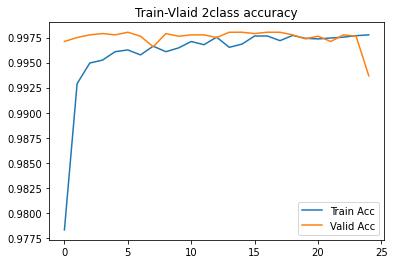

epoch 25 loss: 0.0199: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:50<00:00,  8.40it/s]


train 2class accuracy = 0.99817
[[17215    23]
 [   40 17198]]


epoch 25 loss: 0.0222: 100%|█████████████████████████████████████████████████████████| 760/760 [00:57<00:00, 13.18it/s]


validation 2class accuracy = 0.99763
[[3274    9]
 [   9 4301]]


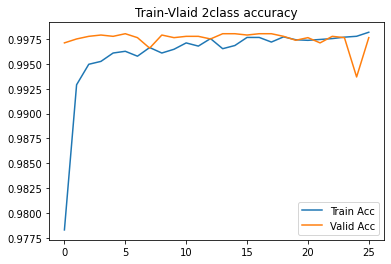

epoch 26 loss: 0.0137: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:49<00:00,  8.41it/s]


train 2class accuracy = 0.99788
[[17209    29]
 [   44 17194]]


epoch 26 loss: 0.0217: 100%|█████████████████████████████████████████████████████████| 760/760 [00:57<00:00, 13.11it/s]


validation 2class accuracy = 0.99697
[[3274    9]
 [  14 4296]]


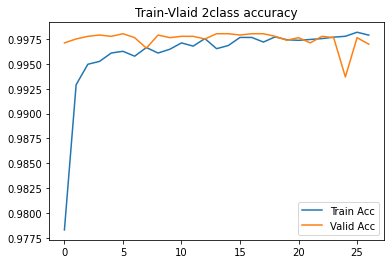

epoch 27 loss: 0.0028: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:50<00:00,  8.40it/s]


train 2class accuracy = 0.99806
[[17214    24]
 [   43 17195]]


epoch 27 loss: 0.0249: 100%|█████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 13.03it/s]

validation 2class accuracy = 0.99671
[[3273   10]
 [  15 4295]]


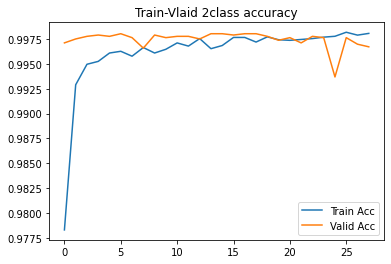

epoch 28 loss: 0.0087: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:50<00:00,  8.40it/s]


train 2class accuracy = 0.99791
[[17210    28]
 [   44 17194]]


epoch 28 loss: 0.0186: 100%|█████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 13.02it/s]

validation 2class accuracy = 0.99776
[[3274    9]
 [   8 4302]]


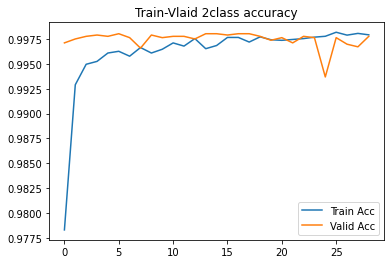

epoch 29 loss: 0.0037: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:49<00:00,  8.41it/s]


train 2class accuracy = 0.99835
[[17222    16]
 [   41 17197]]


epoch 29 loss: 0.0219: 100%|█████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 13.03it/s]

validation 2class accuracy = 0.99763
[[3274    9]
 [   9 4301]]


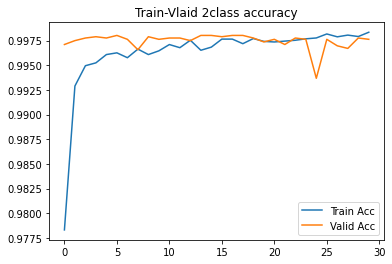

epoch 30 loss: 0.0027: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:50<00:00,  8.41it/s]


train 2class accuracy = 0.99797
[[17209    29]
 [   41 17197]]


epoch 30 loss: 0.0225: 100%|█████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 13.01it/s]


validation 2class accuracy = 0.99789
[[3275    8]
 [   8 4302]]


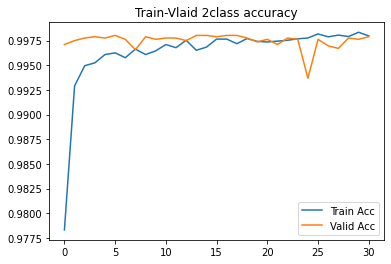

epoch 31 loss: 0.0130: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:49<00:00,  8.41it/s]


train 2class accuracy = 0.99785
[[17207    31]
 [   43 17195]]


epoch 31 loss: 0.0196: 100%|█████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 13.01it/s]

validation 2class accuracy = 0.99750
[[3272   11]
 [   8 4302]]


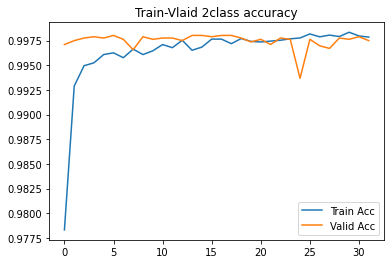

epoch 32 loss: 0.0187: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:48<00:00,  8.44it/s]


train 2class accuracy = 0.99756
[[17202    36]
 [   48 17190]]


epoch 32 loss: 0.0224: 100%|█████████████████████████████████████████████████████████| 760/760 [00:57<00:00, 13.21it/s]


validation 2class accuracy = 0.99723
[[3274    9]
 [  12 4298]]


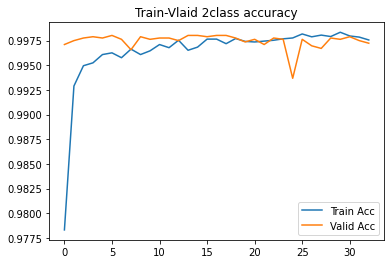

epoch 33 loss: 0.0074: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:46<00:00,  8.48it/s]


train 2class accuracy = 0.99814
[[17215    23]
 [   41 17197]]


epoch 33 loss: 0.0217: 100%|█████████████████████████████████████████████████████████| 760/760 [00:57<00:00, 13.24it/s]


validation 2class accuracy = 0.99789
[[3275    8]
 [   8 4302]]


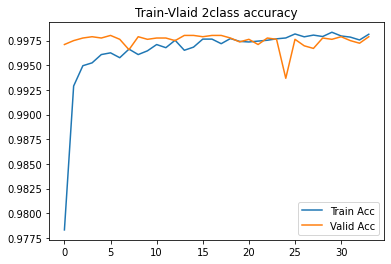

epoch 34 loss: 0.0089: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:48<00:00,  8.45it/s]


train 2class accuracy = 0.99785
[[17206    32]
 [   42 17196]]


epoch 34 loss: 0.0240: 100%|█████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 13.09it/s]


validation 2class accuracy = 0.99776
[[3274    9]
 [   8 4302]]


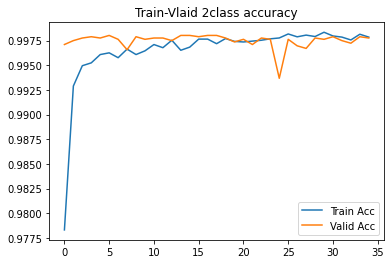

epoch 35 loss: 0.0016: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:49<00:00,  8.42it/s]


train 2class accuracy = 0.99817
[[17212    26]
 [   37 17201]]


epoch 35 loss: 0.0282: 100%|█████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 13.02it/s]


validation 2class accuracy = 0.99802
[[3275    8]
 [   7 4303]]


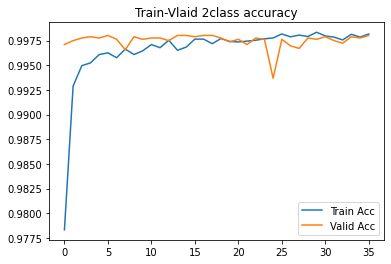

epoch 36 loss: 0.0123: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:49<00:00,  8.41it/s]


train 2class accuracy = 0.99809
[[17219    19]
 [   47 17191]]


epoch 36 loss: 0.0243: 100%|█████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 13.06it/s]

validation 2class accuracy = 0.99710
[[3274    9]
 [  13 4297]]


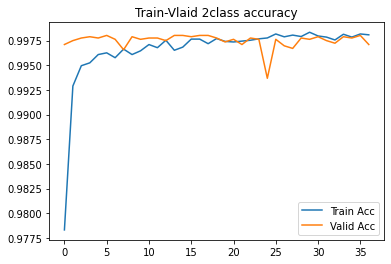

epoch 37 loss: 0.0085: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:49<00:00,  8.42it/s]


train 2class accuracy = 0.99803
[[17214    24]
 [   44 17194]]


epoch 37 loss: 0.0206: 100%|█████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 13.03it/s]


validation 2class accuracy = 0.99763
[[3274    9]
 [   9 4301]]


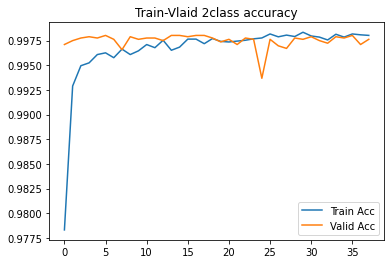

epoch 38 loss: 0.0272: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:49<00:00,  8.42it/s]


train 2class accuracy = 0.99748
[[17207    31]
 [   56 17182]]


epoch 38 loss: 0.0222: 100%|█████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 13.03it/s]


validation 2class accuracy = 0.99737
[[3273   10]
 [  10 4300]]


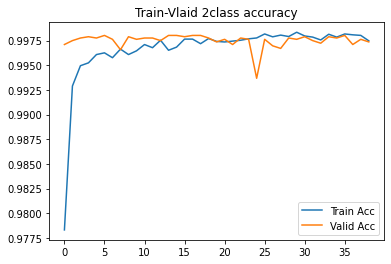

epoch 39 loss: 0.0122: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:50<00:00,  8.40it/s]


train 2class accuracy = 0.99806
[[17211    27]
 [   40 17198]]


epoch 39 loss: 0.0284: 100%|█████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 13.06it/s]


validation 2class accuracy = 0.99750
[[3274    9]
 [  10 4300]]


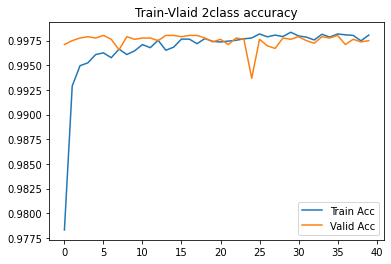

epoch 40 loss: 0.0105: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:49<00:00,  8.42it/s]


train 2class accuracy = 0.99817
[[17220    18]
 [   45 17193]]


epoch 40 loss: 0.0264: 100%|█████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 13.03it/s]


validation 2class accuracy = 0.99763
[[3273   10]
 [   8 4302]]


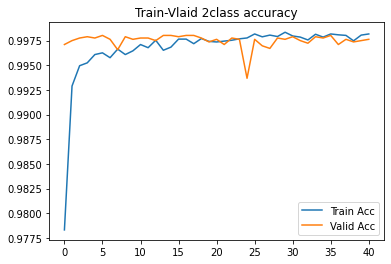

epoch 41 loss: 0.0039: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:50<00:00,  8.40it/s]


train 2class accuracy = 0.99811
[[17210    28]
 [   37 17201]]


epoch 41 loss: 0.0228: 100%|█████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 13.04it/s]


validation 2class accuracy = 0.99789
[[3274    9]
 [   7 4303]]


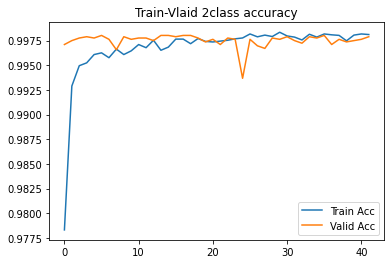

epoch 42 loss: 0.0024: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:49<00:00,  8.42it/s]


train 2class accuracy = 0.99852
[[17220    18]
 [   33 17205]]


epoch 42 loss: 0.0254: 100%|█████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 13.03it/s]


validation 2class accuracy = 0.99710
[[3274    9]
 [  13 4297]]


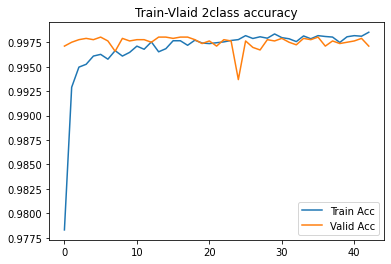

epoch 43 loss: 0.0107: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:49<00:00,  8.42it/s]


train 2class accuracy = 0.99826
[[17215    23]
 [   37 17201]]


epoch 43 loss: 0.0200: 100%|█████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 13.03it/s]


validation 2class accuracy = 0.99802
[[3274    9]
 [   6 4304]]


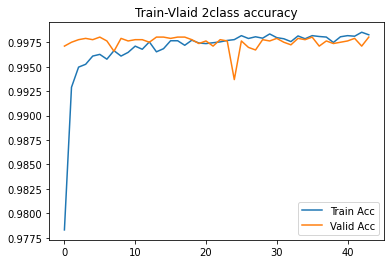

epoch 44 loss: 0.0087: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:49<00:00,  8.41it/s]


train 2class accuracy = 0.99843
[[17219    19]
 [   35 17203]]


epoch 44 loss: 0.0236: 100%|█████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 13.04it/s]


validation 2class accuracy = 0.99723
[[3271   12]
 [   9 4301]]


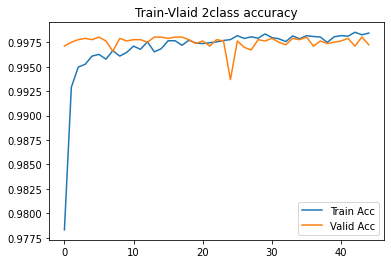

epoch 45 loss: 0.0044: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:49<00:00,  8.41it/s]


train 2class accuracy = 0.99855
[[17222    16]
 [   34 17204]]


epoch 45 loss: 0.0259: 100%|█████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 13.00it/s]


validation 2class accuracy = 0.99750
[[3273   10]
 [   9 4301]]


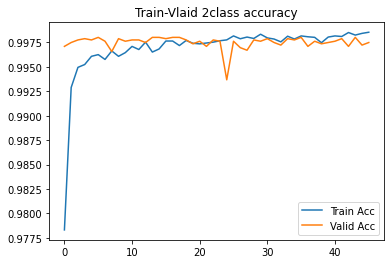

epoch 46 loss: 0.0060: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:50<00:00,  8.41it/s]


train 2class accuracy = 0.99823
[[17216    22]
 [   39 17199]]


epoch 46 loss: 0.0290: 100%|█████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 12.99it/s]


validation 2class accuracy = 0.99710
[[3275    8]
 [  14 4296]]


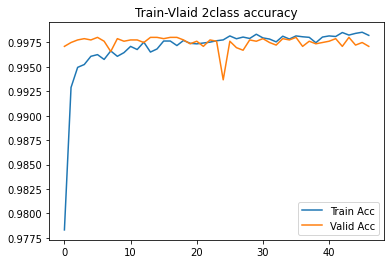

epoch 47 loss: 0.0035: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:50<00:00,  8.40it/s]


train 2class accuracy = 0.99855
[[17223    15]
 [   35 17203]]


epoch 47 loss: 0.0253: 100%|█████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 13.00it/s]


validation 2class accuracy = 0.99763
[[3274    9]
 [   9 4301]]


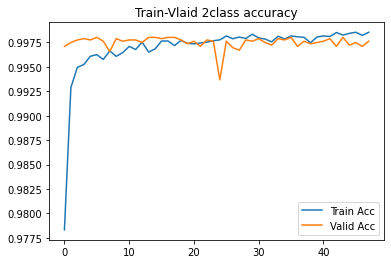

epoch 48 loss: 0.0044: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:49<00:00,  8.42it/s]


train 2class accuracy = 0.99823
[[17216    22]
 [   39 17199]]


epoch 48 loss: 0.0244: 100%|█████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 13.01it/s]

validation 2class accuracy = 0.99763
[[3274    9]
 [   9 4301]]


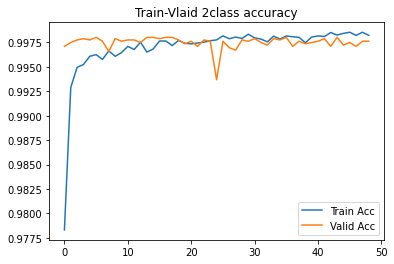

epoch 49 loss: 0.0076: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:43<00:00,  8.54it/s]


train 2class accuracy = 0.99823
[[17216    22]
 [   39 17199]]


epoch 49 loss: 0.0248: 100%|█████████████████████████████████████████████████████████| 760/760 [00:56<00:00, 13.39it/s]


validation 2class accuracy = 0.99763
[[3273   10]
 [   8 4302]]


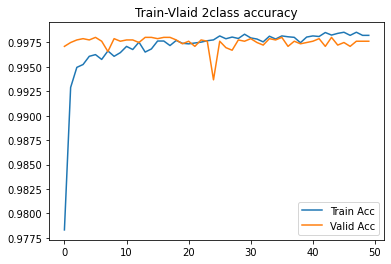

epoch 50 loss: 0.0031: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:43<00:00,  8.55it/s]


train 2class accuracy = 0.99826
[[17211    27]
 [   33 17205]]


epoch 50 loss: 0.0276: 100%|█████████████████████████████████████████████████████████| 760/760 [00:57<00:00, 13.30it/s]


validation 2class accuracy = 0.99776
[[3273   10]
 [   7 4303]]


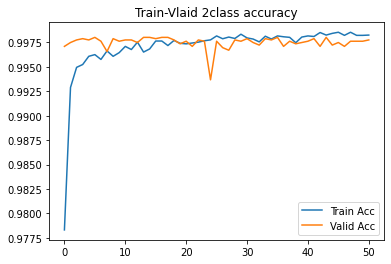

epoch 51 loss: 0.0084: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:45<00:00,  8.51it/s]


train 2class accuracy = 0.99814
[[17212    26]
 [   38 17200]]


epoch 51 loss: 0.0261: 100%|█████████████████████████████████████████████████████████| 760/760 [00:57<00:00, 13.23it/s]


validation 2class accuracy = 0.99723
[[3273   10]
 [  11 4299]]


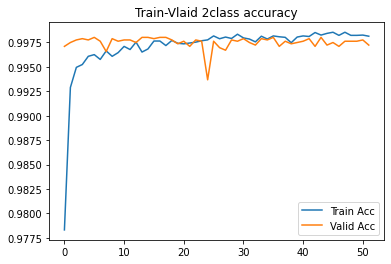

epoch 52 loss: 0.0023: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:47<00:00,  8.47it/s]


train 2class accuracy = 0.99887
[[17224    14]
 [   25 17213]]


epoch 52 loss: 0.0255: 100%|█████████████████████████████████████████████████████████| 760/760 [00:57<00:00, 13.15it/s]

validation 2class accuracy = 0.99658
[[3273   10]
 [  16 4294]]


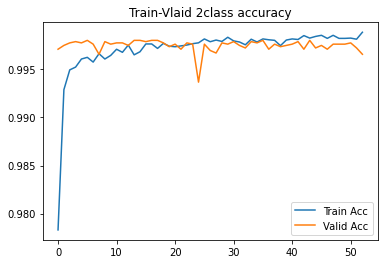

epoch 53 loss: 0.0062: 100%|███████████████████████████████████████████████████████| 3448/3448 [06:48<00:00,  8.45it/s]


train 2class accuracy = 0.99835
[[17223    15]
 [   42 17196]]


epoch 53 loss: 0.0259: 100%|█████████████████████████████████████████████████████████| 760/760 [00:58<00:00, 13.04it/s]


validation 2class accuracy = 0.99763
[[3272   11]
 [   7 4303]]


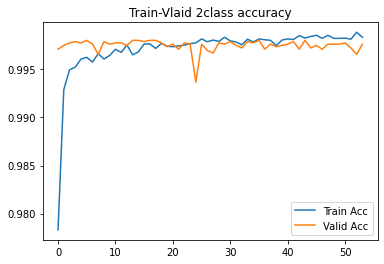

epoch 54 loss: 0.0101:  46%|█████████████████████████▍                             | 1595/3448 [03:09<03:36,  8.55it/s]

In [ ]:
# model_dir = '../models/220630/2class/{}'.format(CFG['model_arch'])
model_dir = '../models/220930/{}'.format(CFG['model_arch'])
train_dir = 'D:/@image_data/nbi_wl(pacs+testvideo)'

wandb.init(project="NBI_classfication", entity="kyungbin")
wandb.run.name = 'pacs+video'

wandb.watch(model)

if __name__ == '__main__':
     # for training only, need nightly build pytorch
    
    seed_everything(CFG['seed'])
    
    if not os.path.isdir(model_dir):
        os.makedirs(model_dir)
    
    folds = StratifiedKFold(n_splits=CFG['fold_num'], shuffle=True, random_state=CFG['seed']).split(np.arange(train.shape[0]), train.label.values)
    
    for fold, (trn_idx, val_idx) in enumerate(folds):
    
        print('Training with {} started'.format(fold))

        print(len(trn_idx), len(val_idx))
        train_loader, val_loader = prepare_dataloader(train, trn_idx, val_idx, data_root=train_dir)

        device = torch.device(CFG['device'])
        
        model = ColonImgClassifier(CFG['model_arch'], train.label.nunique(), pretrained=True).to(device)

        scaler = GradScaler()   
        optimizer = torch.optim.Adam(model.parameters(), lr=CFG['lr'], 
#                                      weight_decay=CFG['weight_decay']
                                    )
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, gamma=0.5, step_size=25)
#         scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
#         scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=CFG['T_0'], T_mult=1, eta_min=CFG['min_lr'], last_epoch=-1)
        #scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer=optimizer, pct_start=0.1, div_factor=25, 
        #                                                max_lr=CFG['lr'], epochs=CFG['epochs'], steps_per_epoch=len(train_loader))
        
        loss_tr = nn.CrossEntropyLoss().to(device) #MyCrossEntropyLoss().to(device)
        loss_fn = nn.CrossEntropyLoss().to(device)
        
        train_acc_list = []
        train_matrix_list = []
        valid_acc_list = []
        valid_matrix_list = []
        
        start = time.time()
        for epoch in range(CFG['epochs']):
            
            train_preds_all, train_acc, train_matrix, train_loss = train_one_epoch(epoch, model, loss_tr, optimizer, train_loader, device, 
                                                                       scheduler=None, schd_batch_update=False)
            
            with torch.no_grad():
                valid_preds_all, valid_acc, valid_matrix,valid_loss= valid_one_epoch(epoch, model, loss_fn, val_loader, device, scheduler=None, schd_loss_update=False)

            torch.save(model.state_dict(), (model_dir+'/pacs+video_{}_fold_{}_{}').format(CFG['model_arch'], fold, epoch))
            
            train_acc_list.append(train_acc)
            train_matrix_list.append(train_matrix)
            valid_acc_list.append(valid_acc)
            valid_matrix_list.append(valid_matrix)
        
            plt.plot(train_acc_list, label='Train Acc')
            plt.plot(valid_acc_list, label='Valid Acc')
            plt.title('Train-Vlaid 2class accuracy')
            plt.legend()
            plt.show()
            
            
            wandb.log({"valid_loss": valid_loss,
          "train_loss": train_loss,
          "valid Acc": valid_acc,
          "train Acc": train_acc})
            
        end = time.time() - start
        time_ = str(datetime.timedelta(seconds=end)).split(".")[0]
        print("time :", time_)
            
        best_index = valid_acc_list.index(max(valid_acc_list))
        print(f'Best Epoch : {best_index}')
        print(f'Best Train Accuracy : {train_acc_list[best_index]:.5f}')
        print(train_matrix_list[best_index])
        print(f'Best Valid Accuracy : {valid_acc_list[best_index]:.5f}')
        print(valid_matrix_list[best_index])
        
        #torch.save(model.cnn_model.state_dict(),'{}/cnn_model_fold_{}_{}'.format(CFG['model_path'], fold, CFG['tag']))
        
        del model, optimizer, train_loader, val_loader, scaler
        torch.cuda.empty_cache()
        
        # we'll train fold 0 first
        #if fold == 0:
            #break 

    train_preds_all = train_preds_all
    valid_preds_all = valid_preds_all

In [115]:
best_index = valid_acc_list.index(max(valid_acc_list))
print(f'Best Epoch : {best_index}')
print(f'Best Train Accuracy : {train_acc_list[best_index]:.5f}')
print(train_matrix_list[best_index])
print(f'Best Valid Accuracy : {valid_acc_list[best_index]:.5f}')
print(valid_matrix_list[best_index])

Best Epoch : 137
Best Train Accuracy : 0.96662
[[2598   98]
 [  82 2614]]
Best Valid Accuracy : 0.94574
[[648  26]
 [ 30 328]]


In [128]:
trainset = train.iloc[trn_idx, :]
trainset

image_id  label
0      AD_S03249_03_N_1.jpg      0
2     SSL_S00833_01_N_1.jpg      1
3      AD_S00905_03_N_1.jpg      0
4      AD_S04287_01_N_1.jpg      0
5      AD_P01054_02_N_2.jpg      0
...                     ...    ...
5151   AD_S05007_03_N_1.jpg      0
5153   AD_P01492_07_N_1.jpg      0
5154   AD_S00061_02_N_1.jpg      0
5155   AD_P00076_06_N_1.jpg      0
5156   AD_S04221_04_N_1.jpg      0

[4125 rows x 2 columns]

In [129]:
trainset.label.value_counts()

0    2607
1    1518
Name: label, dtype: int64

In [130]:
validset = train.iloc[val_idx, :]
validset['pred'] = valid_preds_all
validset

/tmp/ipykernel_1119617/1963754716.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validset['pred'] = valid_preds_all


image_id  label  pred
1     HP_S01276_05_N_1.jpg      1     0
6     AD_S00929_02_N_1.jpg      0     1
13    AD_S04649_02_N_1.jpg      0     0
15    AD_S05695_02_N_1.jpg      0     1
22    AD_S03466_03_N_1.jpg      0     1
...                    ...    ...   ...
5118  HP_P00378_01_N_1.jpg      1     1
5129  AD_S00758_03_N_1.jpg      0     0
5144  AD_S00453_01_N_1.jpg      0     0
5148  AD_P00617_05_N_1.jpg      0     1
5152  AD_P00509_04_N_1.jpg      0     0

[1032 rows x 3 columns]

In [131]:
validset['label'].value_counts()

0    668
1    364
Name: label, dtype: int64

In [62]:
validset[validset['label'] != validset['pred']]

image_id  label  pred
18    AD_S04969_02_N_1.jpg      0     1
19    AD_S06674_06_N_1.jpg      0     1
63    AD_S04377_03_N_1.jpg      0     1
75    HP_P00205_06_N_1.jpg      1     0
77    AD_S04747_05_N_1.jpg      0     1
...                    ...    ...   ...
1545  AD_P01126_07_N_1.jpg      0     1
1547  HP_S06229_03_N_1.jpg      1     0
1585  AD_S05395_01_N_1.jpg      0     1
1591  AD_P01234_07_N_1.jpg      0     1
1599  HP_S04780_04_N_1.jpg      1     0

[86 rows x 3 columns]

In [63]:
validset['pred'].value_counts()

0    170
1    151
Name: pred, dtype: int64